Use average of 10 last iterations as decision for best model, fixed best iter indicator

In [11]:
%matplotlib inline

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import glob
import h5py

In [14]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split

# sklearn functions
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [15]:
import random
from models_ukb import ModelA, ModelB
from hyperparameter_options import params_baseline as hyperparams

In [6]:
torch.__version__

'1.0.0'

In [7]:
gpu = 3
multi_gpus = [3, 4]
zero_one_normalize = False
dtype = np.float64
z_factor = None

In [8]:
# load mask
mask = None

In [9]:
table = "/ritter/share/projects/UKbiobank/Eitel_ICD/tables/participants_transMRI_T1-ICD10_G_binary-under.csv"

In [10]:
# load dataset and show first 5 rows
df = pd.read_csv(table)
df.head()

Unnamed: 0     PTID                                          file_path  \
0           0  1100042  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
1           1  1100675  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
2           2  1180478  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
3           3  1112124  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
4           4  1148079  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   

                                                  T2  \
0  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
1  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
2  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
3  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
4  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   

   Encoded anonymised participant ID  \
0                            1100042   
1                            1100675   
2                            1180478   
3                            1112124   
4                            1148079   

  T1 structural brain images - NIFTI Index: 2.0  \
0                                     20252_2_0   
1                                     20252_2_0   
2                                     20252_2_0   
3                                     20252_2_0   
4                                     20252_2_0   

  T2 FLAIR structural brain images - NIFTI Index: 2.0  \
0                                          20253_2_0    
1                                          20253_2_0    
2                                          20253_2_0    
3                                          20253_2_0    
4                                          20253_2_0    

  Functional brain images - task - NIFTI Index: 2.0     Sex ICD10_F_cat  \
0                                         20249_2_0  Female          []   
1                                         20249_2_0  Female          []   
2                                         20249_2_0  Female          []   
3                                         20249_2_0    Male          []   
4                                         20249_2_0  Female          []   

          ...          Illness2Years2  MoodSwings_diff Sensitivity_diff  \
0         ...                   0None              0YY              0YY   
1         ...                   0None              1NN            9else   
2         ...                   0None              0YY              0YY   
3         ...                   0None            9else              0YY   
4         ...                   3SitY              3NY              0YY   

  Nervous_diff Worrier_diff TenseHighlyStung_diff  Loneliness_diff  \
0          1NN          0YY                   1NN              1NN   
1          1NN          0YY                 9else              1NN   
2          1NN          2YN                   0YY              1NN   
3          0YY          0YY                 9else              1NN   
4          3NY          0YY                   3NY              1NN   

   RiskTaking_diff  Happiness_diff  FamilyRelation_diff  
0              1NN             9Na                  9Na  
1            9else             9Na                  9Na  
2              0YY             9Na                  9Na  
3              1NN             9Na                  9Na  
4              1NN             9Na                  9Na  

[5 rows x 156 columns]

In [11]:
# shuffle the dataset
df = df.sample(frac=0.2, random_state=23)
df.head()

Unnamed: 0     PTID                                          file_path  \
791          791  1109592  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
1705        1705  1197086  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
167          167  1092621  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
331          331  1037619  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
651          651  1161652  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   

                                                     T2  \
791   /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
1705  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
167   /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
331   /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
651   /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   

      Encoded anonymised participant ID  \
791                             1109592   
1705                            1197086   
167                             1092621   
331                             1037619   
651                             1161652   

     T1 structural brain images - NIFTI Index: 2.0  \
791                                      20252_2_0   
1705                                     20252_2_0   
167                                      20252_2_0   
331                                      20252_2_0   
651                                      20252_2_0   

     T2 FLAIR structural brain images - NIFTI Index: 2.0  \
791                                           20253_2_0    
1705                                          20253_2_0    
167                                           20253_2_0    
331                                           20253_2_0    
651                                           20253_2_0    

     Functional brain images - task - NIFTI Index: 2.0     Sex ICD10_F_cat  \
791                                          20249_2_0  Female          []   
1705                                         20249_2_0    Male          []   
167                                          20249_2_0  Female          []   
331                                          20249_2_0    Male          []   
651                                          20249_2_0    Male          []   

             ...          Illness2Years2  MoodSwings_diff Sensitivity_diff  \
791          ...                   0None              1NN              3NY   
1705         ...                   0None              0YY              0YY   
167          ...             4SitR,5DocR              2YN              1NN   
331          ...                   0None              2YN              0YY   
651          ...                   0None              3NY              3NY   

     Nervous_diff Worrier_diff TenseHighlyStung_diff  Loneliness_diff  \
791           1NN          0YY                   1NN              1NN   
1705        9else          2YN                   3NY              0YY   
167           1NN          1NN                   1NN              3NY   
331           3NY          3NY                   1NN              1NN   
651           1NN          0YY                   1NN              3NY   

      RiskTaking_diff  Happiness_diff  FamilyRelation_diff  
791               3NY           MH.VH                VH.VH  
1705              1NN             9Na                  9Na  
167               1NN             9Na                  9Na  
331               0YY             9Na                  9Na  
651               2YN             9Na                  9Na  

[5 rows x 156 columns]

In [12]:
class UKBGDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask=None, z_factor=None):
        self.df = dataframe
        self.transform = transform
        self.mask = mask
        self.z_factor = z_factor
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.FloatTensor):
            idx = idx.item()
        idx = int(idx)
        
        path = self.df.iloc[idx]['file_path']
        path = path.replace("/analysis/ritter", "/ritter/share")
        image = load_nifti(path, mask=self.mask, z_factor=self.z_factor)
        
        # normalize by max
        image /= np.max(image)
        
        label = self.df.iloc[idx]['Sex']
        label = torch.FloatTensor([int(label == "Male")])
        
        if self.transform:
            image = self.transform(image)
        
        sample = {
            "image" : image,
            "label" : label
         }
        return sample

In [13]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

# Define the classifier

In [14]:
def pick_model(name):
    if name == "ModelA":
        net = ModelA()
    elif name == "ModelB":
        net = ModelB()
    elif name == "ModelAPIF":
        net = ModelAPIF()
    elif name == "ModelBPIF":
        net = ModelBPIF()
    return net

def update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold_idx):
    outer_fold_best["final_acc"] = report["val_metrics"][retain_metric][-1]
    outer_fold_best["best_acc"] = np.max(report["val_metrics"][retain_metric][ignore_epochs:])
    outer_fold_best["final_iter"] = len(report["val_metrics"][retain_metric])
    outer_fold_best["best_iter"] = outer_fold_best["final_iter"] - np.argmax(np.flip(np.copy(report["val_metrics"][retain_metric])))
    outer_fold_best["params"] = selected_hyperparams
    outer_fold_best["inner_fold_idx"] = inner_fold_idx
    return outer_fold_best

# Training

In [15]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=None,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    best_metric = []
    all_outer_bests = []
    models = []
    fold = 0
    initial_prepend = None
    
    random_states = np.arange(20, 30) # will be used again to split in testing phase
    
    for outer_fold, r in enumerate(random_states):
        print("###### Starting outer fold {}".format(outer_fold))
        # load new random data split each outer fold
        # separate new test set
        no_test_df = data.sample(frac=0.8, random_state=r) # split according 
         # split train/validation
        train_df = no_test_df.sample(frac=0.8, random_state=32) # can be the same r at each inner fold
        val_df = no_test_df[~no_test_df["PTID"].isin(train_df["PTID"])]
        
        if zero_one_normalize:
            intensity = IntensityRescale()
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask, z_factor=z_factor)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, z_factor=z_factor)
        else:
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask, z_factor=z_factor)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([ToTensor()]), mask=mask, z_factor=z_factor)
        
        print(len(ukb_data_train))
        print(len(ukb_data_val))
        
        print("Shuffled the data..")
        
        outer_fold_best = {
            "final_acc" : 0,
            "best_acc" : 0,
            "final_iter" : 0,
            "best_iter" : 0,
            "params" : {},
            "inner_fold_idx" : 0
        }
        
        for inner_fold in range(5):
            print("###### Starting inner fold {}".format(inner_fold))
            # sample randomly from the hyperparameter options each inner fold
            b = random.choice(hyperparams["batch_size"])
            patience = random.choice(hyperparams["patience"]["small"])
            lr = random.choice(hyperparams["lr"])
            # force each model architecture to occur twice
            if inner_fold < 2:
                model_name = "ModelA"
            elif inner_fold < 4:
                model_name = "ModelB"
            else:
                # only choose model randomly in the last run
                model_name = random.choice(hyperparams["model"])
            
            selected_hyperparams = {
                "model" : model_name,
                "batch_size" : b,
                "patience" : patience,
                "lr" : lr
                }
            print(selected_hyperparams)
            
            # load model
            if multi_gpus is None:
                net = pick_model(model_name).cuda(gpu)
            else:
                net = torch.nn.DataParallel(pick_model(model_name), device_ids=multi_gpus).cuda(gpu)
            print("Trainable model parameters: {}".format(count_parameters(net)))
        
            callbacks = [EarlyStopping(patience=patience, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
                         ModelCheckpoint(path=output_dir,
                                         prepend="outer_{}_inner_{}".format(outer_fold, inner_fold),
                                         store_best=True,
                                         ignore_before=ignore_epochs,
                                         retain_metric=retain_metric)]
        
            # add current fold number to model checkpoint path
            if callbacks is not None:
                for idx, callback in enumerate(callbacks):
                    if isinstance(callback, ModelCheckpoint):
                        if initial_prepend is None:
                            initial_prepend = callbacks[idx].prepend
                        callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
                        initial_prepend = None
            fold += 1

            # set optimizer
            wd = 1e-4
            criterion = nn.BCEWithLogitsLoss().cuda(gpu)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

            train_loader = DataLoader(
                ukb_data_train, batch_size=b, shuffle=True, num_workers=4
            )

            val_loader = DataLoader(
                ukb_data_val, batch_size=2, shuffle=True, num_workers=2
            )

            trainer = Trainer(
                net,
                criterion,
                optimizer,
                metrics=metrics,
                callbacks=callbacks,
                device=gpu
            )
            # train model and store results
            net, report = trainer.train_model(
                train_loader,
                val_loader,
                num_epochs=num_epochs,
                show_train_steps=10,
                show_validation_epochs=1,
            )
            # append validation score of the retain metric
            if isinstance(retain_metric, str):
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric][-10:])
                fold_metric.append(report["val_metrics"][retain_metric][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold)
            else:
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric.__name__][-10:])
                fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric.__name__][-1] > outer_fold_best["final_acc"]:
                if best_val > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric.__name__, selected_hyperparams, inner_fold)

            models.append(net)
            print("Finished inner fold.")

            # visualize result
            trainer.visualize_training(report, metrics)
            trainer.evaluate_model(val_loader, gpu)
        print("Finished outer fold.")
        print(outer_fold_best)
        all_outer_bests.append(outer_fold_best)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    print(all_outer_bests)
    return fold_metric, models

In [16]:
num_epochs = 200
min_iters = 3
ignore_epochs = 30
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [17]:
r = 1

In [18]:
output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/UKB/20_percent/10xrandom_splits/baseline_r2/"

###### Starting outer fold 0
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 1303769
[0,    10] loss: 0.68566
[0,    20] loss: 0.66852
[0,    30] loss: 0.69469
Time elapsed: 0h:0m:27s
train accuracy_score: 56.72 %
train balanced_accuracy: 52.20 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.692630
[1,    10] loss: 0.71743
[1,    20] loss: 0.68252
[1,    30] loss: 0.70681
Time elapsed: 0h:1m:6s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.08 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.709464
[2,    10] loss: 0.68909
[2,    20] loss: 0.71017
[2,    30] loss: 0.69714
Time elapsed: 0h:1m:46s
train accuracy_score: 53.78 %
train balanced_accuracy: 50.02 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.687583
[3,    10] loss: 0.74610
[3,    20] loss: 0.71258
[3,    30] loss: 0.70312
Time elapsed: 0h:2

[33,    20] loss: 0.64050
[33,    30] loss: 0.73461
Time elapsed: 0h:21m:31s
train accuracy_score: 55.04 %
train balanced_accuracy: 48.99 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.693237
[34,    10] loss: 0.69590
[34,    20] loss: 0.69023
[34,    30] loss: 0.67494
Time elapsed: 0h:22m:25s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.88 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.712531
[35,    10] loss: 0.67522
[35,    20] loss: 0.66087
[35,    30] loss: 0.70702
Time elapsed: 0h:23m:19s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.710105
[36,    10] loss: 0.67115
[36,    20] loss: 0.65314
[36,    30] loss: 0.72687
Time elapsed: 0h:24m:13s
train accuracy_score: 55.04 %
train balanced_accuracy: 48.99 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.696866
[37,    10] loss: 0.68850
[37,    20] loss: 0.6767

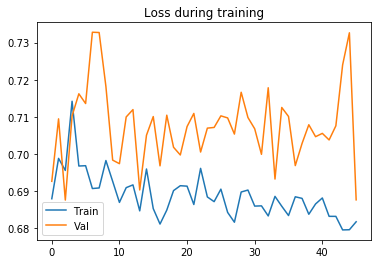

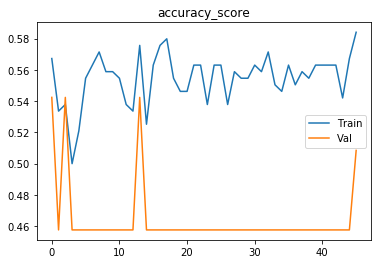

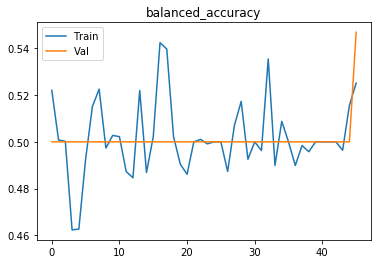

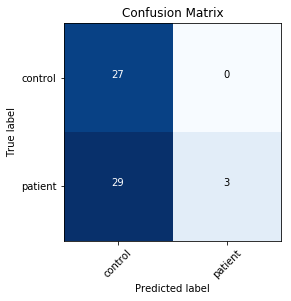

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 1303769
[0,    10] loss: 0.69496
[0,    20] loss: 0.69520
[0,    30] loss: 0.68105
Time elapsed: 0h:0m:25s
train accuracy_score: 54.20 %
train balanced_accuracy: 49.10 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.715825
[1,    10] loss: 0.67265
[1,    20] loss: 0.70534
[1,    30] loss: 0.69303
Time elapsed: 0h:1m:8s
train accuracy_score: 57.14 %
train balanced_accuracy: 50.96 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.698667
[2,    10] loss: 0.68943
[2,    20] loss: 0.70178
[2,    30] loss: 0.67875
Time elapsed: 0h:1m:59s
train accuracy_score: 58.82 %
train balanced_accuracy: 53.64 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.739326
[3,    10] loss: 0.69721
[3,    20] loss: 0.64026
[3,    30] loss: 0.74597
Time elapsed: 0h:2m:54s
train accuracy_score: 56.30 %
train balanced_accura

Time elapsed: 0h:22m:53s
train accuracy_score: 53.78 %
train balanced_accuracy: 47.87 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.701624
[34,    10] loss: 0.68337
[34,    20] loss: 0.66015
[34,    30] loss: 0.70135
Time elapsed: 0h:23m:32s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.59 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.699427
[35,    10] loss: 0.67939
[35,    20] loss: 0.68646
[35,    30] loss: 0.70702
Time elapsed: 0h:24m:9s
train accuracy_score: 55.46 %
train balanced_accuracy: 49.58 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.703463
[36,    10] loss: 0.68567
[36,    20] loss: 0.65898
[36,    30] loss: 0.71546
Time elapsed: 0h:24m:48s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.59 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.698648
[37,    10] loss: 0.67143
[37,    20] loss: 0.70367
[37,    30] loss: 0.67274
Time elapsed: 0h:25m:26s


[67,    10] loss: 0.64418
[67,    20] loss: 0.61386
[67,    30] loss: 0.62158
Time elapsed: 0h:44m:32s
train accuracy_score: 65.55 %
train balanced_accuracy: 63.27 %
val accuracy_score: 76.27 %
val balanced_accuracy: 75.81 %
Val loss: 0.615903
[68,    10] loss: 0.60350
[68,    20] loss: 0.63376
[68,    30] loss: 0.62770
Time elapsed: 0h:45m:10s
train accuracy_score: 66.81 %
train balanced_accuracy: 65.46 %
val accuracy_score: 54.24 %
val balanced_accuracy: 57.52 %
Val loss: 0.650025
[69,    10] loss: 0.66480
[69,    20] loss: 0.61658
[69,    30] loss: 0.60487
Time elapsed: 0h:45m:48s
train accuracy_score: 63.87 %
train balanced_accuracy: 61.78 %
val accuracy_score: 59.32 %
val balanced_accuracy: 62.21 %
Val loss: 0.621476
[70,    10] loss: 0.59761
[70,    20] loss: 0.61986
[70,    30] loss: 0.59907
Time elapsed: 0h:46m:25s
train accuracy_score: 67.23 %
train balanced_accuracy: 65.30 %
val accuracy_score: 76.27 %
val balanced_accuracy: 76.10 %
Val loss: 0.594467
[71,    10] loss: 0.6133

val accuracy_score: 69.49 %
val balanced_accuracy: 70.14 %
Val loss: 0.509903
[101,    10] loss: 0.34220
[101,    20] loss: 0.58013
[101,    30] loss: 0.55213
Time elapsed: 1h:5m:53s
train accuracy_score: 74.79 %
train balanced_accuracy: 74.17 %
val accuracy_score: 71.19 %
val balanced_accuracy: 73.44 %
Val loss: 0.538914
[102,    10] loss: 0.40631
[102,    20] loss: 0.44795
[102,    30] loss: 0.41137
Time elapsed: 1h:6m:30s
train accuracy_score: 79.41 %
train balanced_accuracy: 78.27 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.24 %
Val loss: 0.462396
[103,    10] loss: 0.45290
[103,    20] loss: 0.49399
[103,    30] loss: 0.49134
Time elapsed: 1h:7m:8s
train accuracy_score: 76.47 %
train balanced_accuracy: 75.98 %
val accuracy_score: 79.66 %
val balanced_accuracy: 80.38 %
Val loss: 0.469011
[104,    10] loss: 0.45757
[104,    20] loss: 0.50236
[104,    30] loss: 0.45469
Time elapsed: 1h:7m:46s
train accuracy_score: 76.89 %
train balanced_accuracy: 76.79 %
val accuracy_scor

[134,    10] loss: 0.33674
[134,    20] loss: 0.30485
[134,    30] loss: 0.44779
Time elapsed: 1h:26m:39s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.35 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.95 %
Val loss: 0.408884
[135,    10] loss: 0.39025
[135,    20] loss: 0.35827
[135,    30] loss: 0.30673
Time elapsed: 1h:27m:18s
train accuracy_score: 86.55 %
train balanced_accuracy: 86.34 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.22 %
Val loss: 0.361793
[136,    10] loss: 0.30071
[136,    20] loss: 0.34491
[136,    30] loss: 0.36596
Time elapsed: 1h:27m:55s
train accuracy_score: 86.13 %
train balanced_accuracy: 85.96 %
val accuracy_score: 84.75 %
val balanced_accuracy: 85.65 %
Val loss: 0.393891
[137,    10] loss: 0.27914
[137,    20] loss: 0.28348
[137,    30] loss: 0.38759
Time elapsed: 1h:28m:33s
train accuracy_score: 89.08 %
train balanced_accuracy: 88.90 %
val accuracy_score: 77.97 %
val balanced_accuracy: 79.69 %
Val loss: 0.486711
[138,    10]

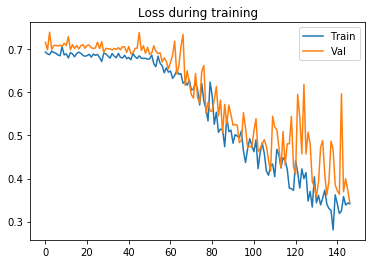

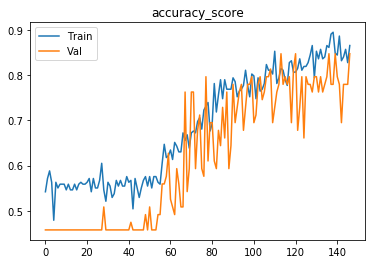

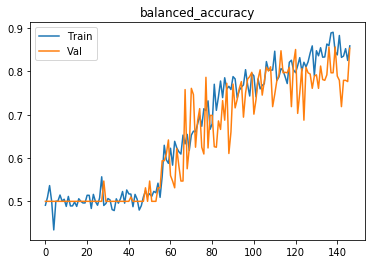

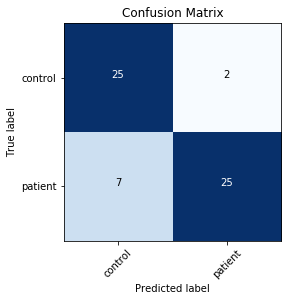

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 787785
[0,    10] loss: 0.68956
[0,    20] loss: 0.68504
[0,    30] loss: 0.69180
[0,    40] loss: 0.67841
[0,    50] loss: 0.68140
Time elapsed: 0h:0m:25s
train accuracy_score: 52.94 %
train balanced_accuracy: 47.45 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.712515
[1,    10] loss: 0.69709
[1,    20] loss: 0.70870
[1,    30] loss: 0.67331
[1,    40] loss: 0.68928
[1,    50] loss: 0.71436
Time elapsed: 0h:1m:3s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.61 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.698380
[2,    10] loss: 0.70059
[2,    20] loss: 0.67146
[2,    30] loss: 0.73011
[2,    40] loss: 0.68240
[2,    50] loss: 0.68059
Time elapsed: 0h:1m:42s
train accuracy_score: 53.78 %
train balanced_accuracy: 48.30 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.704640
[

val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.712414
[28,    10] loss: 0.66769
[28,    20] loss: 0.69084
[28,    30] loss: 0.66279
[28,    40] loss: 0.68530
[28,    50] loss: 0.70724
Time elapsed: 0h:18m:6s
train accuracy_score: 55.04 %
train balanced_accuracy: 49.42 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.695629
[29,    10] loss: 0.69151
[29,    20] loss: 0.68964
[29,    30] loss: 0.64601
[29,    40] loss: 0.69938
[29,    50] loss: 0.69294
Time elapsed: 0h:18m:44s
train accuracy_score: 56.72 %
train balanced_accuracy: 51.23 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.705146
[30,    10] loss: 0.68773
[30,    20] loss: 0.67920
[30,    30] loss: 0.68732
[30,    40] loss: 0.66720
[30,    50] loss: 0.66290
Time elapsed: 0h:19m:23s
train accuracy_score: 60.50 %
train balanced_accuracy: 55.35 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.733140
[31,    10] loss: 0.71459
[31,    2

Time elapsed: 0h:35m:11s
train accuracy_score: 65.55 %
train balanced_accuracy: 64.02 %
val accuracy_score: 54.24 %
val balanced_accuracy: 57.81 %
Val loss: 0.676373
[56,    10] loss: 0.52567
[56,    20] loss: 0.52649
[56,    30] loss: 0.60864
[56,    40] loss: 0.59972
[56,    50] loss: 0.57400
Time elapsed: 0h:35m:49s
train accuracy_score: 71.43 %
train balanced_accuracy: 69.57 %
val accuracy_score: 71.19 %
val balanced_accuracy: 71.41 %
Val loss: 0.593723
[57,    10] loss: 0.56527
[57,    20] loss: 0.52624
[57,    30] loss: 0.61058
[57,    40] loss: 0.61746
[57,    50] loss: 0.65706
Time elapsed: 0h:36m:26s
train accuracy_score: 68.07 %
train balanced_accuracy: 67.12 %
val accuracy_score: 66.10 %
val balanced_accuracy: 68.17 %
Val loss: 0.614048
[58,    10] loss: 0.56969
[58,    20] loss: 0.51273
[58,    30] loss: 0.50026
[58,    40] loss: 0.65759
[58,    50] loss: 0.66884
Time elapsed: 0h:37m:3s
train accuracy_score: 67.65 %
train balanced_accuracy: 66.10 %
val accuracy_score: 71.19

[83,    30] loss: 0.46077
[83,    40] loss: 0.47403
[83,    50] loss: 0.41282
Time elapsed: 0h:52m:49s
train accuracy_score: 79.41 %
train balanced_accuracy: 78.81 %
val accuracy_score: 69.49 %
val balanced_accuracy: 71.59 %
Val loss: 0.576840
[84,    10] loss: 0.45380
[84,    20] loss: 0.58738
[84,    30] loss: 0.50268
[84,    40] loss: 0.35075
[84,    50] loss: 0.41465
Time elapsed: 0h:53m:27s
train accuracy_score: 78.57 %
train balanced_accuracy: 77.85 %
val accuracy_score: 76.27 %
val balanced_accuracy: 77.84 %
Val loss: 0.495107
[85,    10] loss: 0.43373
[85,    20] loss: 0.45553
[85,    30] loss: 0.47500
[85,    40] loss: 0.43977
[85,    50] loss: 0.30815
Time elapsed: 0h:54m:5s
train accuracy_score: 80.67 %
train balanced_accuracy: 79.61 %
val accuracy_score: 81.36 %
val balanced_accuracy: 82.23 %
Val loss: 0.432435
[86,    10] loss: 0.32584
[86,    20] loss: 0.42978
[86,    30] loss: 0.42742
[86,    40] loss: 0.43013
[86,    50] loss: 0.42033
Time elapsed: 0h:54m:43s
train accu

val accuracy_score: 81.36 %
val balanced_accuracy: 81.37 %
Val loss: 0.360335
[111,    10] loss: 0.62160
[111,    20] loss: 0.27869
[111,    30] loss: 0.50375
[111,    40] loss: 0.43785
[111,    50] loss: 0.31556
Time elapsed: 1h:10m:23s
train accuracy_score: 83.19 %
train balanced_accuracy: 83.03 %
val accuracy_score: 74.58 %
val balanced_accuracy: 76.27 %
Val loss: 0.508380
[112,    10] loss: 0.37660
[112,    20] loss: 0.27026
[112,    30] loss: 0.36748
[112,    40] loss: 0.35299
[112,    50] loss: 0.36188
Time elapsed: 1h:11m:0s
train accuracy_score: 84.45 %
train balanced_accuracy: 84.04 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.94 %
Val loss: 0.399965
[113,    10] loss: 0.29277
[113,    20] loss: 0.39922
[113,    30] loss: 0.29130
[113,    40] loss: 0.40039
[113,    50] loss: 0.29495
Time elapsed: 1h:11m:37s
train accuracy_score: 86.13 %
train balanced_accuracy: 86.07 %
val accuracy_score: 77.97 %
val balanced_accuracy: 79.11 %
Val loss: 0.443808
[114,    10] loss: 0

[138,    10] loss: 0.23924
[138,    20] loss: 0.29676
[138,    30] loss: 0.25319
[138,    40] loss: 0.40791
[138,    50] loss: 0.38623
Time elapsed: 1h:27m:8s
train accuracy_score: 85.29 %
train balanced_accuracy: 85.00 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.22 %
Val loss: 0.375049
[139,    10] loss: 0.28422
[139,    20] loss: 0.28159
[139,    30] loss: 0.24352
[139,    40] loss: 0.27587
[139,    50] loss: 0.38474
Time elapsed: 1h:27m:46s
train accuracy_score: 89.50 %
train balanced_accuracy: 89.49 %
val accuracy_score: 81.36 %
val balanced_accuracy: 82.52 %
Val loss: 0.408197
[140,    10] loss: 0.21467
[140,    20] loss: 0.35192
[140,    30] loss: 0.30450
[140,    40] loss: 0.41001
[140,    50] loss: 0.35311
Time elapsed: 1h:28m:23s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.56 %
val accuracy_score: 79.66 %
val balanced_accuracy: 80.96 %
Val loss: 0.400591
[141,    10] loss: 0.19950
[141,    20] loss: 0.28473
[141,    30] loss: 0.47381
[141,    40] loss

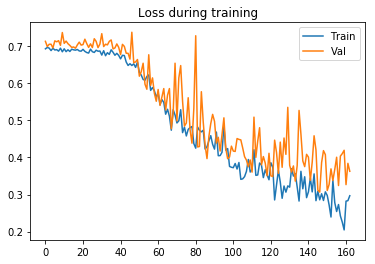

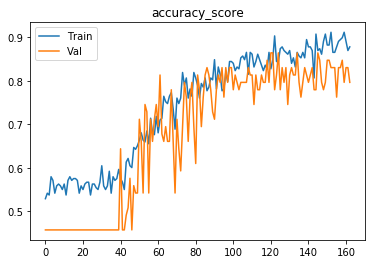

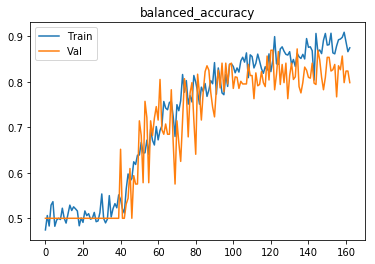

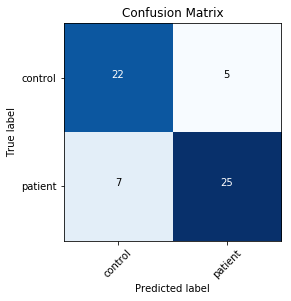

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 787785
[0,    10] loss: 0.70224
[0,    20] loss: 0.70423
[0,    30] loss: 0.71668
Time elapsed: 0h:0m:25s
train accuracy_score: 53.78 %
train balanced_accuracy: 50.34 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.732396
[1,    10] loss: 0.71646
[1,    20] loss: 0.69939
[1,    30] loss: 0.67736
Time elapsed: 0h:1m:2s
train accuracy_score: 51.68 %
train balanced_accuracy: 46.54 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.732781
[2,    10] loss: 0.69991
[2,    20] loss: 0.70318
[2,    30] loss: 0.69208
Time elapsed: 0h:1m:40s
train accuracy_score: 52.94 %
train balanced_accuracy: 48.31 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.709101
[3,    10] loss: 0.69711
[3,    20] loss: 0.70352
[3,    30] loss: 0.69298
Time elapsed: 0h:2m:18s
train accuracy_score: 55.88 %
train balanced_accura

Time elapsed: 0h:21m:50s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.22 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.696922
[34,    10] loss: 0.67524
[34,    20] loss: 0.69044
[34,    30] loss: 0.70257
Time elapsed: 0h:22m:30s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.07 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.704566
[35,    10] loss: 0.68972
[35,    20] loss: 0.69306
[35,    30] loss: 0.66814
Time elapsed: 0h:23m:8s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.19 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.713813
[36,    10] loss: 0.70119
[36,    20] loss: 0.71163
[36,    30] loss: 0.64896
Time elapsed: 0h:23m:45s
train accuracy_score: 52.10 %
train balanced_accuracy: 47.02 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.728943
[37,    10] loss: 0.69155
[37,    20] loss: 0.69255
[37,    30] loss: 0.65881
Time elapsed: 0h:24m:24s


[67,    10] loss: 0.52653
[67,    20] loss: 0.58073
[67,    30] loss: 0.61636
Time elapsed: 0h:45m:58s
train accuracy_score: 72.69 %
train balanced_accuracy: 71.98 %
val accuracy_score: 50.85 %
val balanced_accuracy: 54.69 %
Val loss: 0.766600
[68,    10] loss: 0.60559
[68,    20] loss: 0.67310
[68,    30] loss: 0.60731
Time elapsed: 0h:46m:41s
train accuracy_score: 60.92 %
train balanced_accuracy: 59.92 %
val accuracy_score: 57.63 %
val balanced_accuracy: 60.94 %
Val loss: 0.639907
[69,    10] loss: 0.56457
[69,    20] loss: 0.58966
[69,    30] loss: 0.59698
Time elapsed: 0h:47m:24s
train accuracy_score: 68.49 %
train balanced_accuracy: 65.66 %
val accuracy_score: 72.88 %
val balanced_accuracy: 74.13 %
Val loss: 0.573338
[70,    10] loss: 0.53371
[70,    20] loss: 0.53537
[70,    30] loss: 0.51293
Time elapsed: 0h:48m:8s
train accuracy_score: 75.21 %
train balanced_accuracy: 74.54 %
val accuracy_score: 62.71 %
val balanced_accuracy: 65.62 %
Val loss: 0.615747
[71,    10] loss: 0.48045

val accuracy_score: 84.75 %
val balanced_accuracy: 83.91 %
Val loss: 0.367990
[101,    10] loss: 0.40689
[101,    20] loss: 0.29033
[101,    30] loss: 0.25056
Time elapsed: 1h:8m:14s
train accuracy_score: 84.45 %
train balanced_accuracy: 84.15 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.24 %
Val loss: 0.424773
[102,    10] loss: 0.46002
[102,    20] loss: 0.30771
[102,    30] loss: 0.25485
Time elapsed: 1h:8m:51s
train accuracy_score: 88.24 %
train balanced_accuracy: 88.15 %
val accuracy_score: 81.36 %
val balanced_accuracy: 82.52 %
Val loss: 0.444778
[103,    10] loss: 0.23019
[103,    20] loss: 0.31436
[103,    30] loss: 0.35765
Time elapsed: 1h:9m:28s
train accuracy_score: 86.13 %
train balanced_accuracy: 85.86 %
val accuracy_score: 74.58 %
val balanced_accuracy: 76.27 %
Val loss: 0.470952
[104,    10] loss: 0.29118
[104,    20] loss: 0.34381
[104,    30] loss: 0.33410
Time elapsed: 1h:10m:4s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.63 %
val accuracy_sco

Best result during training: 0.88. Saving model..
Finished inner fold.


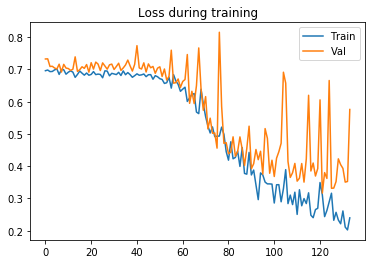

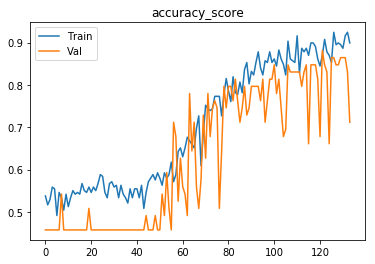

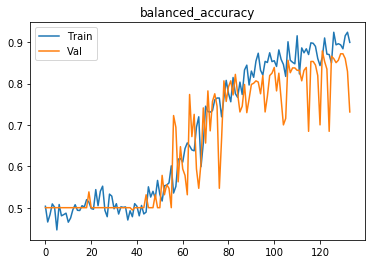

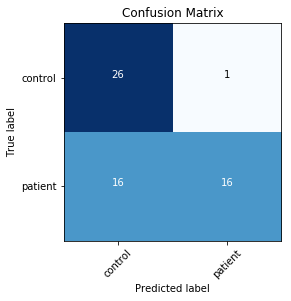

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 1303769
[0,    10] loss: 0.68289
Time elapsed: 0h:0m:25s
train accuracy_score: 54.20 %
train balanced_accuracy: 49.86 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.695889
[1,    10] loss: 0.69006
Time elapsed: 0h:1m:2s
train accuracy_score: 57.14 %
train balanced_accuracy: 52.90 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.702112
[2,    10] loss: 0.68749
Time elapsed: 0h:1m:40s
train accuracy_score: 54.62 %
train balanced_accuracy: 48.51 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.713078
[3,    10] loss: 0.68821
Time elapsed: 0h:2m:23s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.43 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.706355
[4,    10] loss: 0.67149
Time elapsed: 0h:3m:7s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.00 

val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.713591
[43,    10] loss: 0.67219
Time elapsed: 0h:28m:0s
train accuracy_score: 57.98 %
train balanced_accuracy: 53.75 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.707068
[44,    10] loss: 0.67393
Time elapsed: 0h:28m:38s
train accuracy_score: 56.72 %
train balanced_accuracy: 52.10 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.696576
[45,    10] loss: 0.68292
Time elapsed: 0h:29m:15s
train accuracy_score: 55.46 %
train balanced_accuracy: 52.38 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.710650
[46,    10] loss: 0.69304
Time elapsed: 0h:29m:52s
train accuracy_score: 57.56 %
train balanced_accuracy: 52.41 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.701205
[47,    10] loss: 0.69252
Time elapsed: 0h:30m:29s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.23 %
val accuracy_score: 45.76 %
val balanced_

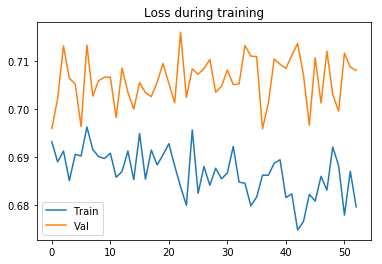

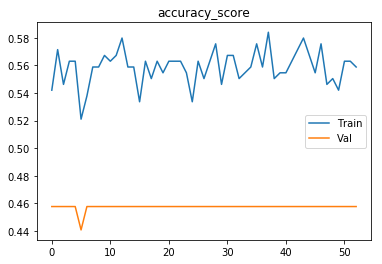

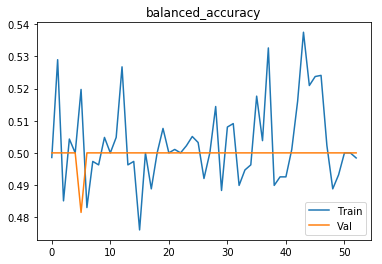

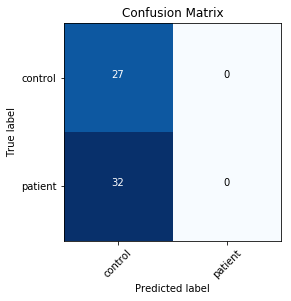

Finished outer fold.
{'final_acc': 0.853587962962963, 'best_acc': 0.8564814814814814, 'final_iter': 147, 'best_iter': 140, 'params': {'model': 'ModelA', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 1}
###### Starting outer fold 1
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 1303769
[0,    10] loss: 0.68026
Time elapsed: 0h:0m:25s
train accuracy_score: 53.78 %
train balanced_accuracy: 49.97 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.681157
[1,    10] loss: 0.69149
Time elapsed: 0h:1m:3s
train accuracy_score: 52.52 %
train balanced_accuracy: 48.59 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.688713
[2,    10] loss: 0.68701
Time elapsed: 0h:1m:41s
train accuracy_score: 53.78 %
train balanced_accuracy: 49.61 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.682704
[3,    10] loss: 0.694

[41,    10] loss: 0.68609
Time elapsed: 0h:26m:35s
train accuracy_score: 57.56 %
train balanced_accuracy: 55.52 %
val accuracy_score: 66.10 %
val balanced_accuracy: 63.71 %
Val loss: 0.665711
[42,    10] loss: 0.66726
Time elapsed: 0h:27m:13s
train accuracy_score: 55.88 %
train balanced_accuracy: 54.11 %
val accuracy_score: 62.71 %
val balanced_accuracy: 58.12 %
Val loss: 0.644502
[43,    10] loss: 0.69340
Time elapsed: 0h:27m:51s
train accuracy_score: 54.62 %
train balanced_accuracy: 54.94 %
val accuracy_score: 64.41 %
val balanced_accuracy: 60.65 %
Val loss: 0.644051
[44,    10] loss: 0.67170
Time elapsed: 0h:28m:30s
train accuracy_score: 57.98 %
train balanced_accuracy: 55.69 %
val accuracy_score: 64.41 %
val balanced_accuracy: 61.18 %
Val loss: 0.645187
[45,    10] loss: 0.67395
Time elapsed: 0h:29m:9s
train accuracy_score: 61.76 %
train balanced_accuracy: 61.67 %
val accuracy_score: 61.02 %
val balanced_accuracy: 54.00 %
Val loss: 0.654914
[46,    10] loss: 0.65935
Time elapsed: 0

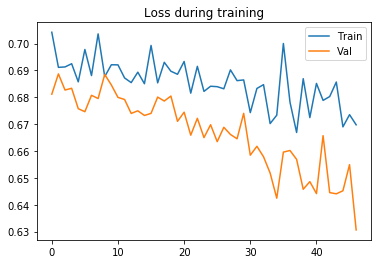

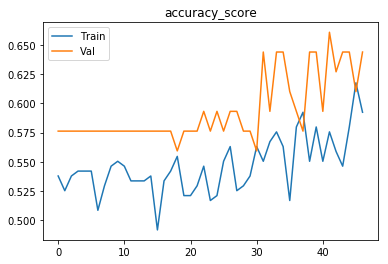

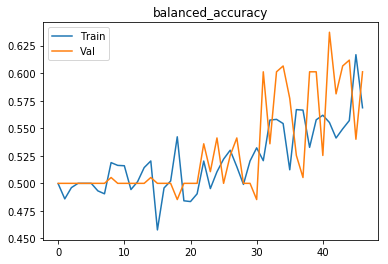

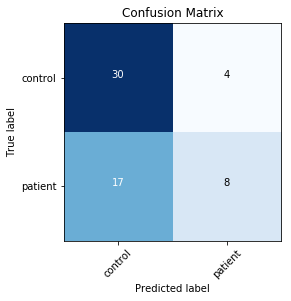

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 1303769
[0,    10] loss: 0.70013
[0,    20] loss: 0.69209
[0,    30] loss: 0.69497
[0,    40] loss: 0.69424
[0,    50] loss: 0.68762
Time elapsed: 0h:0m:24s
train accuracy_score: 53.36 %
train balanced_accuracy: 54.20 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.674988
[1,    10] loss: 0.70518
[1,    20] loss: 0.67325
[1,    30] loss: 0.74045
[1,    40] loss: 0.69666
[1,    50] loss: 0.68197
Time elapsed: 0h:1m:0s
train accuracy_score: 52.52 %
train balanced_accuracy: 50.87 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.685325
[2,    10] loss: 0.71748
[2,    20] loss: 0.71753
[2,    30] loss: 0.71551
[2,    40] loss: 0.69539
[2,    50] loss: 0.71194
Time elapsed: 0h:1m:36s
train accuracy_score: 47.06 %
train balanced_accuracy: 44.19 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.685059


val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.681181
[28,    10] loss: 0.69538
[28,    20] loss: 0.69567
[28,    30] loss: 0.68363
[28,    40] loss: 0.69719
[28,    50] loss: 0.68219
Time elapsed: 0h:17m:26s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.07 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.681164
[29,    10] loss: 0.71067
[29,    20] loss: 0.69752
[29,    30] loss: 0.71218
[29,    40] loss: 0.70206
[29,    50] loss: 0.68110
Time elapsed: 0h:18m:2s
train accuracy_score: 52.94 %
train balanced_accuracy: 50.76 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.676773
[30,    10] loss: 0.67176
[30,    20] loss: 0.70442
[30,    30] loss: 0.67931
[30,    40] loss: 0.68786
[30,    50] loss: 0.72866
Time elapsed: 0h:18m:39s
train accuracy_score: 51.68 %
train balanced_accuracy: 47.75 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.682680
[31,    10] loss: 0.68592
[31,    2

Time elapsed: 0h:34m:0s
train accuracy_score: 52.10 %
train balanced_accuracy: 49.91 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.670342
[56,    10] loss: 0.69210
[56,    20] loss: 0.71296
[56,    30] loss: 0.68425
[56,    40] loss: 0.68774
[56,    50] loss: 0.68697
Time elapsed: 0h:34m:38s
train accuracy_score: 56.30 %
train balanced_accuracy: 53.57 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.675976
[57,    10] loss: 0.71347
[57,    20] loss: 0.68115
[57,    30] loss: 0.69918
[57,    40] loss: 0.66965
[57,    50] loss: 0.68863
Time elapsed: 0h:35m:14s
train accuracy_score: 51.26 %
train balanced_accuracy: 48.28 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.668027
[58,    10] loss: 0.65634
[58,    20] loss: 0.68387
[58,    30] loss: 0.70125
[58,    40] loss: 0.70196
[58,    50] loss: 0.68967
Time elapsed: 0h:35m:51s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.00 %
val accuracy_score: 57.63

[83,    30] loss: 0.62677
[83,    40] loss: 0.62895
[83,    50] loss: 0.67928
Time elapsed: 0h:51m:12s
train accuracy_score: 65.13 %
train balanced_accuracy: 64.34 %
val accuracy_score: 76.27 %
val balanced_accuracy: 74.65 %
Val loss: 0.623657
[84,    10] loss: 0.61571
[84,    20] loss: 0.66503
[84,    30] loss: 0.64957
[84,    40] loss: 0.62010
[84,    50] loss: 0.66278
Time elapsed: 0h:51m:49s
train accuracy_score: 60.50 %
train balanced_accuracy: 58.30 %
val accuracy_score: 72.88 %
val balanced_accuracy: 70.65 %
Val loss: 0.621073
[85,    10] loss: 0.67290
[85,    20] loss: 0.64876
[85,    30] loss: 0.66244
[85,    40] loss: 0.66763
[85,    50] loss: 0.64415
Time elapsed: 0h:52m:25s
train accuracy_score: 57.56 %
train balanced_accuracy: 56.66 %
val accuracy_score: 66.10 %
val balanced_accuracy: 61.59 %
Val loss: 0.606115
[86,    10] loss: 0.62830
[86,    20] loss: 0.68112
[86,    30] loss: 0.66241
[86,    40] loss: 0.65258
[86,    50] loss: 0.68317
Time elapsed: 0h:53m:1s
train accu

val accuracy_score: 81.36 %
val balanced_accuracy: 79.59 %
Val loss: 0.474454
[111,    10] loss: 0.55984
[111,    20] loss: 0.57642
[111,    30] loss: 0.55687
[111,    40] loss: 0.59852
[111,    50] loss: 0.48428
Time elapsed: 1h:8m:25s
train accuracy_score: 71.85 %
train balanced_accuracy: 71.19 %
val accuracy_score: 83.05 %
val balanced_accuracy: 81.06 %
Val loss: 0.446729
[112,    10] loss: 0.58846
[112,    20] loss: 0.49010
[112,    30] loss: 0.48704
[112,    40] loss: 0.53665
[112,    50] loss: 0.64579
Time elapsed: 1h:9m:2s
train accuracy_score: 73.11 %
train balanced_accuracy: 72.70 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.65 %
Val loss: 0.430485
[113,    10] loss: 0.47439
[113,    20] loss: 0.56330
[113,    30] loss: 0.51106
[113,    40] loss: 0.53158
[113,    50] loss: 0.55164
Time elapsed: 1h:9m:39s
train accuracy_score: 72.69 %
train balanced_accuracy: 71.96 %
val accuracy_score: 79.66 %
val balanced_accuracy: 76.53 %
Val loss: 0.449202
[114,    10] loss: 0.55

[138,    10] loss: 0.41960
[138,    20] loss: 0.41975
[138,    30] loss: 0.36293
[138,    40] loss: 0.44639
[138,    50] loss: 0.43876
Time elapsed: 1h:24m:53s
train accuracy_score: 83.19 %
train balanced_accuracy: 82.58 %
val accuracy_score: 89.83 %
val balanced_accuracy: 91.18 %
Val loss: 0.333252
[139,    10] loss: 0.41733
[139,    20] loss: 0.49972
[139,    30] loss: 0.41344
[139,    40] loss: 0.40843
[139,    50] loss: 0.38128
Time elapsed: 1h:25m:30s
train accuracy_score: 77.31 %
train balanced_accuracy: 77.08 %
val accuracy_score: 88.14 %
val balanced_accuracy: 86.53 %
Val loss: 0.280242
[140,    10] loss: 0.40852
[140,    20] loss: 0.55911
[140,    30] loss: 0.51997
[140,    40] loss: 0.39687
[140,    50] loss: 0.38587
Time elapsed: 1h:26m:9s
train accuracy_score: 78.57 %
train balanced_accuracy: 78.17 %
val accuracy_score: 91.53 %
val balanced_accuracy: 92.12 %
Val loss: 0.301010
[141,    10] loss: 0.41355
[141,    20] loss: 0.38643
[141,    30] loss: 0.33864
[141,    40] loss

[165,    40] loss: 0.35121
[165,    50] loss: 0.45321
Time elapsed: 1h:41m:31s
train accuracy_score: 81.09 %
train balanced_accuracy: 80.64 %
val accuracy_score: 93.22 %
val balanced_accuracy: 93.06 %
Val loss: 0.195020
[166,    10] loss: 0.35872
[166,    20] loss: 0.24820
[166,    30] loss: 0.39302
[166,    40] loss: 0.37128
[166,    50] loss: 0.33829
Time elapsed: 1h:42m:8s
train accuracy_score: 86.13 %
train balanced_accuracy: 86.00 %
val accuracy_score: 84.75 %
val balanced_accuracy: 82.00 %
Val loss: 0.278652
[167,    10] loss: 0.36689
[167,    20] loss: 0.36963
[167,    30] loss: 0.50550
[167,    40] loss: 0.26913
[167,    50] loss: 0.38630
Time elapsed: 1h:42m:45s
train accuracy_score: 85.29 %
train balanced_accuracy: 85.23 %
val accuracy_score: 93.22 %
val balanced_accuracy: 93.06 %
Val loss: 0.214976
[168,    10] loss: 0.29086
[168,    20] loss: 0.31453
[168,    30] loss: 0.17939
[168,    40] loss: 0.31957
[168,    50] loss: 0.24184
Time elapsed: 1h:43m:23s
train accuracy_scor

val accuracy_score: 93.22 %
val balanced_accuracy: 94.12 %
Val loss: 0.259083
[193,    10] loss: 0.43734
[193,    20] loss: 0.30650
[193,    30] loss: 0.20851
[193,    40] loss: 0.44664
[193,    50] loss: 0.40580
Time elapsed: 1h:58m:45s
train accuracy_score: 82.77 %
train balanced_accuracy: 82.83 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.59 %
Val loss: 0.177031
[194,    10] loss: 0.15054
[194,    20] loss: 0.40964
[194,    30] loss: 0.35049
[194,    40] loss: 0.31657
[194,    50] loss: 0.29701
Time elapsed: 1h:59m:22s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.48 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.59 %
Val loss: 0.178453
[195,    10] loss: 0.19955
[195,    20] loss: 0.19621
[195,    30] loss: 0.31707
[195,    40] loss: 0.32854
[195,    50] loss: 0.22385
Time elapsed: 1h:59m:59s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.55 %
val accuracy_score: 93.22 %
val balanced_accuracy: 94.12 %
Val loss: 0.217811
[196,    10] loss: 

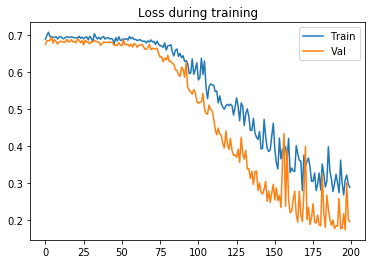

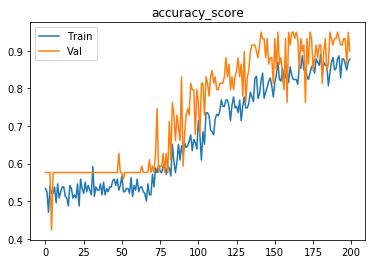

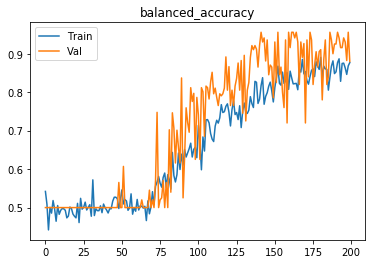

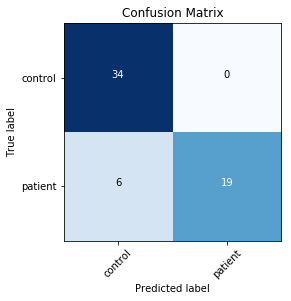

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 787785
[0,    10] loss: 0.69178
Time elapsed: 0h:0m:26s
train accuracy_score: 51.68 %
train balanced_accuracy: 49.17 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.678950
[1,    10] loss: 0.69276
Time elapsed: 0h:1m:4s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.21 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.684049
[2,    10] loss: 0.68638
Time elapsed: 0h:1m:43s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.00 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.685430
[3,    10] loss: 0.69436
Time elapsed: 0h:2m:22s
train accuracy_score: 57.14 %
train balanced_accuracy: 55.27 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.688634
[4,    10] loss: 0.68510
Time elapsed: 0h:3m:0s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.07 %

val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.670095
[43,    10] loss: 0.69544
Time elapsed: 0h:28m:3s
train accuracy_score: 53.78 %
train balanced_accuracy: 51.32 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.669957
[44,    10] loss: 0.68433
Time elapsed: 0h:28m:41s
train accuracy_score: 56.30 %
train balanced_accuracy: 52.51 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.670909
[45,    10] loss: 0.68327
Time elapsed: 0h:29m:19s
train accuracy_score: 53.36 %
train balanced_accuracy: 51.29 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.669855
[46,    10] loss: 0.66949
Time elapsed: 0h:29m:57s
train accuracy_score: 60.50 %
train balanced_accuracy: 57.81 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.670141
[47,    10] loss: 0.68003
Time elapsed: 0h:30m:35s
train accuracy_score: 55.04 %
train balanced_accuracy: 52.20 %
val accuracy_score: 61.02 %
val balanced_

val accuracy_score: 77.97 %
val balanced_accuracy: 77.71 %
Val loss: 0.561295
[86,    10] loss: 0.62769
Time elapsed: 0h:55m:37s
train accuracy_score: 65.97 %
train balanced_accuracy: 65.33 %
val accuracy_score: 74.58 %
val balanced_accuracy: 71.59 %
Val loss: 0.556137
[87,    10] loss: 0.60747
Time elapsed: 0h:56m:15s
train accuracy_score: 66.39 %
train balanced_accuracy: 65.51 %
val accuracy_score: 76.27 %
val balanced_accuracy: 73.59 %
Val loss: 0.539416
[88,    10] loss: 0.60411
Time elapsed: 0h:56m:54s
train accuracy_score: 69.75 %
train balanced_accuracy: 70.88 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.18 %
Val loss: 0.549905
[89,    10] loss: 0.58495
Time elapsed: 0h:57m:32s
train accuracy_score: 73.53 %
train balanced_accuracy: 72.52 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.65 %
Val loss: 0.534488
[90,    10] loss: 0.58524
Time elapsed: 0h:58m:10s
train accuracy_score: 68.91 %
train balanced_accuracy: 67.62 %
val accuracy_score: 79.66 %
val balanced

val accuracy_score: 86.44 %
val balanced_accuracy: 87.18 %
Val loss: 0.402106
[129,    10] loss: 0.45263
Time elapsed: 1h:23m:12s
train accuracy_score: 79.41 %
train balanced_accuracy: 78.95 %
val accuracy_score: 83.05 %
val balanced_accuracy: 84.24 %
Val loss: 0.418653
[130,    10] loss: 0.43774
Time elapsed: 1h:23m:50s
train accuracy_score: 79.83 %
train balanced_accuracy: 79.12 %
val accuracy_score: 86.44 %
val balanced_accuracy: 87.18 %
Val loss: 0.384119
[131,    10] loss: 0.44335
Time elapsed: 1h:24m:29s
train accuracy_score: 77.73 %
train balanced_accuracy: 77.18 %
val accuracy_score: 86.44 %
val balanced_accuracy: 87.18 %
Val loss: 0.371339
[132,    10] loss: 0.44956
Time elapsed: 1h:25m:7s
train accuracy_score: 80.25 %
train balanced_accuracy: 80.00 %
val accuracy_score: 84.75 %
val balanced_accuracy: 85.71 %
Val loss: 0.377328
[133,    10] loss: 0.52019
Time elapsed: 1h:25m:46s
train accuracy_score: 76.89 %
train balanced_accuracy: 76.76 %
val accuracy_score: 81.36 %
val bala

Time elapsed: 1h:50m:9s
train accuracy_score: 76.47 %
train balanced_accuracy: 76.30 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.12 %
Val loss: 0.295173
[172,    10] loss: 0.41776
Time elapsed: 1h:50m:48s
train accuracy_score: 80.25 %
train balanced_accuracy: 80.08 %
val accuracy_score: 84.75 %
val balanced_accuracy: 85.71 %
Val loss: 0.330067
[173,    10] loss: 0.39028
Time elapsed: 1h:51m:26s
train accuracy_score: 79.83 %
train balanced_accuracy: 79.19 %
val accuracy_score: 81.36 %
val balanced_accuracy: 82.76 %
Val loss: 0.389947
[174,    10] loss: 0.38046
Time elapsed: 1h:52m:5s
train accuracy_score: 83.19 %
train balanced_accuracy: 83.14 %
val accuracy_score: 84.75 %
val balanced_accuracy: 85.71 %
Val loss: 0.339920
[175,    10] loss: 0.37408
Time elapsed: 1h:52m:43s
train accuracy_score: 81.51 %
train balanced_accuracy: 81.24 %
val accuracy_score: 86.44 %
val balanced_accuracy: 87.18 %
Val loss: 0.311911
[176,    10] loss: 0.38533
Time elapsed: 1h:53m:21s
train accura

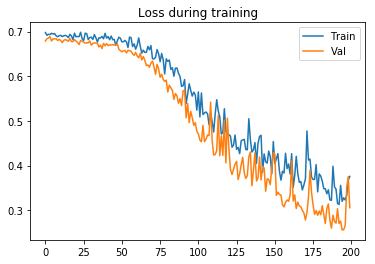

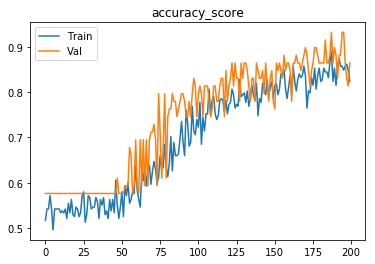

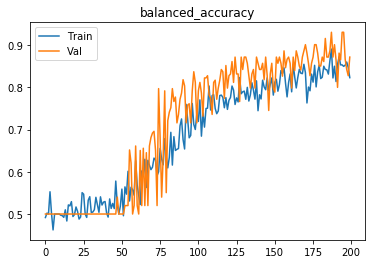

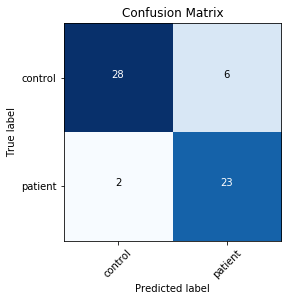

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 787785
[0,    10] loss: 0.68459
[0,    20] loss: 0.72846
[0,    30] loss: 0.69229
Time elapsed: 0h:0m:24s
train accuracy_score: 52.10 %
train balanced_accuracy: 49.48 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.680898
[1,    10] loss: 0.70508
[1,    20] loss: 0.69710
[1,    30] loss: 0.69424
Time elapsed: 0h:1m:1s
train accuracy_score: 51.68 %
train balanced_accuracy: 50.73 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.681552
[2,    10] loss: 0.69366
[2,    20] loss: 0.65796
[2,    30] loss: 0.69726
Time elapsed: 0h:1m:39s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.50 %
val accuracy_score: 42.37 %
val balanced_accuracy: 50.00 %
Val loss: 0.694678
[3,    10] loss: 0.68967
[3,    20] loss: 0.71401
[3,    30] loss: 0.69749
Time elapsed: 0h:2m:17s
train accuracy_score: 50.84 %
train balanced_accura

Time elapsed: 0h:20m:54s
train accuracy_score: 51.68 %
train balanced_accuracy: 47.67 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.677664
[34,    10] loss: 0.68896
[34,    20] loss: 0.68147
[34,    30] loss: 0.70929
Time elapsed: 0h:21m:31s
train accuracy_score: 53.36 %
train balanced_accuracy: 49.58 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.677938
[35,    10] loss: 0.67609
[35,    20] loss: 0.68919
[35,    30] loss: 0.67891
Time elapsed: 0h:22m:7s
train accuracy_score: 53.78 %
train balanced_accuracy: 50.68 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.670010
[36,    10] loss: 0.66349
[36,    20] loss: 0.68578
[36,    30] loss: 0.72132
Time elapsed: 0h:22m:44s
train accuracy_score: 52.52 %
train balanced_accuracy: 49.59 %
val accuracy_score: 67.80 %
val balanced_accuracy: 67.82 %
Val loss: 0.684474
[37,    10] loss: 0.68604
[37,    20] loss: 0.66672
[37,    30] loss: 0.69108
Time elapsed: 0h:23m:22s


[67,    10] loss: 0.50115
[67,    20] loss: 0.61170
[67,    30] loss: 0.61705
Time elapsed: 0h:42m:2s
train accuracy_score: 71.01 %
train balanced_accuracy: 70.27 %
val accuracy_score: 72.88 %
val balanced_accuracy: 74.35 %
Val loss: 0.505902
[68,    10] loss: 0.52112
[68,    20] loss: 0.53063
[68,    30] loss: 0.60678
Time elapsed: 0h:42m:40s
train accuracy_score: 72.69 %
train balanced_accuracy: 72.17 %
val accuracy_score: 77.97 %
val balanced_accuracy: 79.29 %
Val loss: 0.469109
[69,    10] loss: 0.60653
[69,    20] loss: 0.47998
[69,    30] loss: 0.50785
Time elapsed: 0h:43m:17s
train accuracy_score: 73.53 %
train balanced_accuracy: 73.09 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.12 %
Val loss: 0.433639
[70,    10] loss: 0.48124
[70,    20] loss: 0.57202
[70,    30] loss: 0.58262
Time elapsed: 0h:43m:54s
train accuracy_score: 71.43 %
train balanced_accuracy: 71.15 %
val accuracy_score: 77.97 %
val balanced_accuracy: 79.82 %
Val loss: 0.474385
[71,    10] loss: 0.56897

val accuracy_score: 89.83 %
val balanced_accuracy: 90.65 %
Val loss: 0.297401
[101,    10] loss: 0.35806
[101,    20] loss: 0.45349
[101,    30] loss: 0.34760
Time elapsed: 1h:3m:18s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.85 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.18 %
Val loss: 0.310990
[102,    10] loss: 0.29603
[102,    20] loss: 0.34937
[102,    30] loss: 0.33275
Time elapsed: 1h:3m:55s
train accuracy_score: 81.93 %
train balanced_accuracy: 81.77 %
val accuracy_score: 86.44 %
val balanced_accuracy: 88.24 %
Val loss: 0.318227
[103,    10] loss: 0.46471
[103,    20] loss: 0.42365
[103,    30] loss: 0.29895
Time elapsed: 1h:4m:32s
train accuracy_score: 83.61 %
train balanced_accuracy: 83.46 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.71 %
Val loss: 0.303490
[104,    10] loss: 0.23719
[104,    20] loss: 0.38336
[104,    30] loss: 0.29275
Time elapsed: 1h:5m:8s
train accuracy_score: 85.29 %
train balanced_accuracy: 84.94 %
val accuracy_scor

[134,    10] loss: 0.24391
[134,    20] loss: 0.16801
[134,    30] loss: 0.23704
Time elapsed: 1h:23m:41s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.39 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.59 %
Val loss: 0.203282
[135,    10] loss: 0.16723
[135,    20] loss: 0.25018
[135,    30] loss: 0.32864
Time elapsed: 1h:24m:18s
train accuracy_score: 89.92 %
train balanced_accuracy: 89.70 %
val accuracy_score: 89.83 %
val balanced_accuracy: 91.18 %
Val loss: 0.289643
[136,    10] loss: 0.23693
[136,    20] loss: 0.21374
[136,    30] loss: 0.32274
Time elapsed: 1h:24m:55s
train accuracy_score: 89.50 %
train balanced_accuracy: 89.39 %
val accuracy_score: 94.92 %
val balanced_accuracy: 95.59 %
Val loss: 0.234896
[137,    10] loss: 0.20723
[137,    20] loss: 0.19526
[137,    30] loss: 0.17856
Time elapsed: 1h:25m:33s
train accuracy_score: 90.76 %
train balanced_accuracy: 90.69 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.06 %
Val loss: 0.205081
[138,    10]

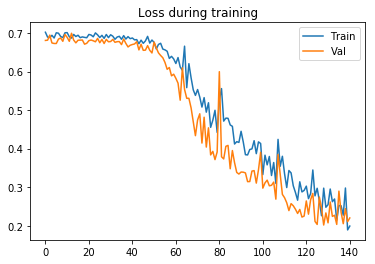

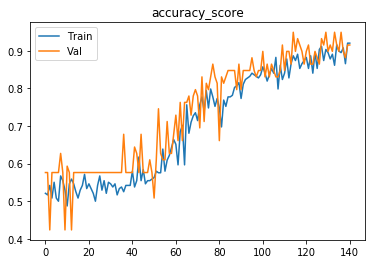

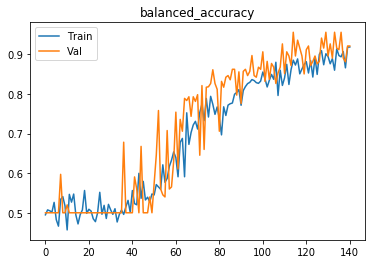

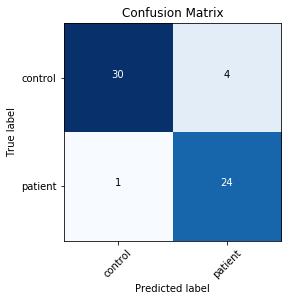

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 787785
[0,    10] loss: 0.69455
Time elapsed: 0h:0m:25s
train accuracy_score: 52.10 %
train balanced_accuracy: 50.62 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.685283
[1,    10] loss: 0.70718
Time elapsed: 0h:1m:3s
train accuracy_score: 49.58 %
train balanced_accuracy: 46.95 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.679879
[2,    10] loss: 0.70930
Time elapsed: 0h:1m:42s
train accuracy_score: 50.84 %
train balanced_accuracy: 47.25 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.676536
[3,    10] loss: 0.69045
Time elapsed: 0h:2m:20s
train accuracy_score: 55.04 %
train balanced_accuracy: 51.91 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.674459
[4,    10] loss: 0.69381
Time elapsed: 0h:2m:58s
train accuracy_score: 54.20 %
train balanced_accuracy: 52.13

val accuracy_score: 69.49 %
val balanced_accuracy: 68.24 %
Val loss: 0.677884
[43,    10] loss: 0.69341
Time elapsed: 0h:27m:56s
train accuracy_score: 54.20 %
train balanced_accuracy: 51.85 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.663897
[44,    10] loss: 0.67494
Time elapsed: 0h:28m:34s
train accuracy_score: 56.30 %
train balanced_accuracy: 53.00 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.667121
[45,    10] loss: 0.69304
Time elapsed: 0h:29m:12s
train accuracy_score: 53.78 %
train balanced_accuracy: 51.60 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.664307
[46,    10] loss: 0.69575
Time elapsed: 0h:29m:51s
train accuracy_score: 51.26 %
train balanced_accuracy: 47.78 %
val accuracy_score: 59.32 %
val balanced_accuracy: 52.00 %
Val loss: 0.667204
[47,    10] loss: 0.68190
Time elapsed: 0h:30m:30s
train accuracy_score: 52.94 %
train balanced_accuracy: 53.67 %
val accuracy_score: 57.63 %
val balanced

val accuracy_score: 79.66 %
val balanced_accuracy: 77.06 %
Val loss: 0.471330
[86,    10] loss: 0.49667
Time elapsed: 0h:55m:33s
train accuracy_score: 76.47 %
train balanced_accuracy: 75.88 %
val accuracy_score: 79.66 %
val balanced_accuracy: 81.82 %
Val loss: 0.520530
[87,    10] loss: 0.60680
Time elapsed: 0h:56m:11s
train accuracy_score: 71.85 %
train balanced_accuracy: 71.54 %
val accuracy_score: 81.36 %
val balanced_accuracy: 82.24 %
Val loss: 0.488769
[88,    10] loss: 0.52773
Time elapsed: 0h:56m:50s
train accuracy_score: 72.69 %
train balanced_accuracy: 72.25 %
val accuracy_score: 84.75 %
val balanced_accuracy: 85.18 %
Val loss: 0.453909
[89,    10] loss: 0.48642
Time elapsed: 0h:57m:28s
train accuracy_score: 76.05 %
train balanced_accuracy: 75.56 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.06 %
Val loss: 0.397121
[90,    10] loss: 0.48505
Time elapsed: 0h:58m:8s
train accuracy_score: 76.47 %
train balanced_accuracy: 75.81 %
val accuracy_score: 86.44 %
val balanced_

val accuracy_score: 91.53 %
val balanced_accuracy: 90.53 %
Val loss: 0.219325
[129,    10] loss: 0.32007
Time elapsed: 1h:23m:7s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.62 %
val accuracy_score: 93.22 %
val balanced_accuracy: 93.59 %
Val loss: 0.204742
[130,    10] loss: 0.33813
Time elapsed: 1h:23m:46s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.71 %
val accuracy_score: 94.92 %
val balanced_accuracy: 94.53 %
Val loss: 0.174871
[131,    10] loss: 0.31310
Time elapsed: 1h:24m:25s
train accuracy_score: 86.55 %
train balanced_accuracy: 86.46 %
val accuracy_score: 88.14 %
val balanced_accuracy: 86.00 %
Val loss: 0.204922
[132,    10] loss: 0.30646
Time elapsed: 1h:25m:3s
train accuracy_score: 83.19 %
train balanced_accuracy: 83.14 %
val accuracy_score: 94.92 %
val balanced_accuracy: 94.53 %
Val loss: 0.187398
[133,    10] loss: 0.24163
Time elapsed: 1h:25m:42s
train accuracy_score: 90.76 %
train balanced_accuracy: 90.55 %
val accuracy_score: 94.92 %
val balan

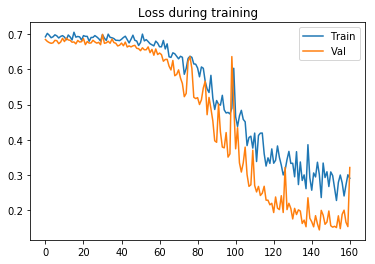

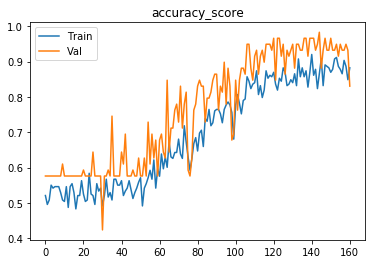

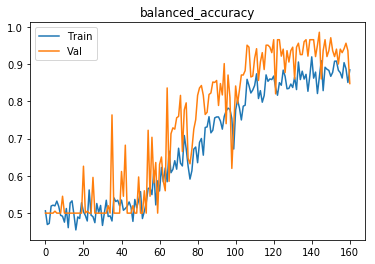

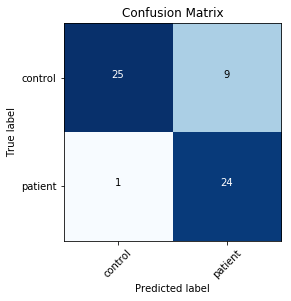

Finished outer fold.
{'final_acc': 0.8476470588235295, 'best_acc': 0.9852941176470589, 'final_iter': 161, 'best_iter': 145, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 4}
###### Starting outer fold 2
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 1303769
[0,    10] loss: 0.68591
Time elapsed: 0h:0m:25s
train accuracy_score: 57.14 %
train balanced_accuracy: 49.77 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.684352
[1,    10] loss: 0.69707
Time elapsed: 0h:1m:4s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.47 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.683815
[2,    10] loss: 0.69858
Time elapsed: 0h:1m:42s
train accuracy_score: 54.20 %
train balanced_accuracy: 47.08 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.684424
[3,    10] loss: 0

[41,    10] loss: 0.67139
Time elapsed: 0h:26m:38s
train accuracy_score: 57.98 %
train balanced_accuracy: 50.50 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.682919
[42,    10] loss: 0.68600
Time elapsed: 0h:27m:17s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.685909
[43,    10] loss: 0.66370
Time elapsed: 0h:27m:55s
train accuracy_score: 57.14 %
train balanced_accuracy: 50.29 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.681761
[44,    10] loss: 0.68484
Time elapsed: 0h:28m:34s
train accuracy_score: 56.72 %
train balanced_accuracy: 49.27 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.684881
[45,    10] loss: 0.69309
Time elapsed: 0h:29m:12s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.681089
[46,    10] loss: 0.69092
Time elapsed: 

[84,    10] loss: 0.60227
Time elapsed: 0h:54m:5s
train accuracy_score: 67.23 %
train balanced_accuracy: 66.20 %
val accuracy_score: 59.32 %
val balanced_accuracy: 53.85 %
Val loss: 0.634693
[85,    10] loss: 0.63049
Time elapsed: 0h:54m:45s
train accuracy_score: 65.97 %
train balanced_accuracy: 63.54 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.666878
[86,    10] loss: 0.55897
Time elapsed: 0h:55m:23s
train accuracy_score: 71.43 %
train balanced_accuracy: 69.33 %
val accuracy_score: 74.58 %
val balanced_accuracy: 73.19 %
Val loss: 0.529994
[87,    10] loss: 0.61670
Time elapsed: 0h:56m:2s
train accuracy_score: 65.97 %
train balanced_accuracy: 64.71 %
val accuracy_score: 76.27 %
val balanced_accuracy: 73.89 %
Val loss: 0.523611
[88,    10] loss: 0.59138
Time elapsed: 0h:56m:41s
train accuracy_score: 70.17 %
train balanced_accuracy: 68.75 %
val accuracy_score: 72.88 %
val balanced_accuracy: 69.64 %
Val loss: 0.507649
[89,    10] loss: 0.57649
Time elapsed: 0h

[127,    10] loss: 0.36042
Time elapsed: 1h:22m:3s
train accuracy_score: 82.35 %
train balanced_accuracy: 82.20 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.58 %
Val loss: 0.226255
[128,    10] loss: 0.35135
Time elapsed: 1h:22m:42s
train accuracy_score: 86.55 %
train balanced_accuracy: 85.98 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.58 %
Val loss: 0.234036
[129,    10] loss: 0.24893
Time elapsed: 1h:23m:22s
train accuracy_score: 86.13 %
train balanced_accuracy: 85.87 %
val accuracy_score: 88.14 %
val balanced_accuracy: 89.39 %
Val loss: 0.271420
[130,    10] loss: 0.32941
Time elapsed: 1h:24m:2s
train accuracy_score: 83.19 %
train balanced_accuracy: 83.06 %
val accuracy_score: 89.83 %
val balanced_accuracy: 90.09 %
Val loss: 0.208774
[131,    10] loss: 0.27910
Time elapsed: 1h:24m:41s
train accuracy_score: 86.13 %
train balanced_accuracy: 85.74 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.58 %
Val loss: 0.224324
[132,    10] loss: 0.29624
Time elaps

val accuracy_score: 91.53 %
val balanced_accuracy: 91.61 %
Val loss: 0.153650
[170,    10] loss: 0.21302
Time elapsed: 1h:50m:3s
train accuracy_score: 89.92 %
train balanced_accuracy: 89.68 %
val accuracy_score: 91.53 %
val balanced_accuracy: 92.02 %
Val loss: 0.161366
[171,    10] loss: 0.19360
Time elapsed: 1h:50m:42s
train accuracy_score: 93.28 %
train balanced_accuracy: 93.25 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.61 %
Val loss: 0.154601
[172,    10] loss: 0.16189
Time elapsed: 1h:51m:20s
train accuracy_score: 91.18 %
train balanced_accuracy: 90.77 %
val accuracy_score: 93.22 %
val balanced_accuracy: 93.94 %
Val loss: 0.166097
[173,    10] loss: 0.18673
Time elapsed: 1h:52m:0s
train accuracy_score: 92.44 %
train balanced_accuracy: 92.52 %
val accuracy_score: 93.22 %
val balanced_accuracy: 92.72 %
Val loss: 0.175422
[174,    10] loss: 0.17377
Time elapsed: 1h:52m:39s
train accuracy_score: 92.02 %
train balanced_accuracy: 91.37 %
val accuracy_score: 94.92 %
val balan

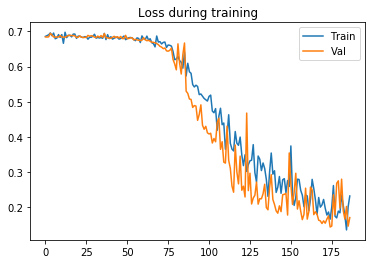

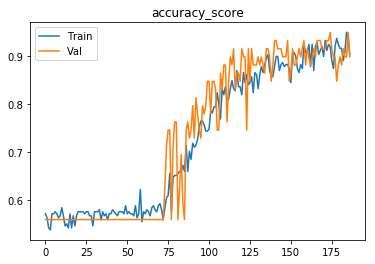

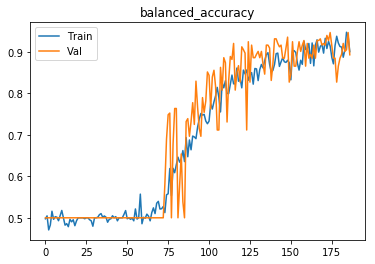

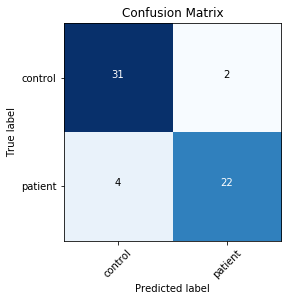

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 1303769
[0,    10] loss: 0.70348
[0,    20] loss: 0.70772
[0,    30] loss: 0.69230
Time elapsed: 0h:0m:25s
train accuracy_score: 50.00 %
train balanced_accuracy: 45.25 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.684108
[1,    10] loss: 0.67834
[1,    20] loss: 0.70585
[1,    30] loss: 0.69191
Time elapsed: 0h:1m:3s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.687498
[2,    10] loss: 0.67945
[2,    20] loss: 0.67714
[2,    30] loss: 0.65470
Time elapsed: 0h:1m:41s
train accuracy_score: 57.14 %
train balanced_accuracy: 49.64 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.691201
[3,    10] loss: 0.71230
[3,    20] loss: 0.69284
[3,    30] loss: 0.69512
Time elapsed: 0h:2m:18s
train accuracy_score: 55.46 %
train balanced_accura

Time elapsed: 0h:21m:24s
train accuracy_score: 57.14 %
train balanced_accuracy: 49.77 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.673131
[34,    10] loss: 0.68835
[34,    20] loss: 0.66983
[34,    30] loss: 0.65071
Time elapsed: 0h:22m:2s
train accuracy_score: 58.82 %
train balanced_accuracy: 52.53 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.681907
[35,    10] loss: 0.65780
[35,    20] loss: 0.62324
[35,    30] loss: 0.69725
Time elapsed: 0h:22m:40s
train accuracy_score: 59.66 %
train balanced_accuracy: 53.78 %
val accuracy_score: 66.10 %
val balanced_accuracy: 66.03 %
Val loss: 0.673085
[36,    10] loss: 0.69272
[36,    20] loss: 0.64937
[36,    30] loss: 0.73159
Time elapsed: 0h:23m:18s
train accuracy_score: 58.82 %
train balanced_accuracy: 56.82 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.670874
[37,    10] loss: 0.64038
[37,    20] loss: 0.63923
[37,    30] loss: 0.70440
Time elapsed: 0h:23m:56s


[67,    10] loss: 0.49709
[67,    20] loss: 0.67610
[67,    30] loss: 0.53518
Time elapsed: 0h:42m:56s
train accuracy_score: 73.11 %
train balanced_accuracy: 71.70 %
val accuracy_score: 67.80 %
val balanced_accuracy: 63.87 %
Val loss: 0.568224
[68,    10] loss: 0.66265
[68,    20] loss: 0.64069
[68,    30] loss: 0.61602
Time elapsed: 0h:43m:33s
train accuracy_score: 63.03 %
train balanced_accuracy: 60.60 %
val accuracy_score: 69.49 %
val balanced_accuracy: 65.79 %
Val loss: 0.579496
[69,    10] loss: 0.54117
[69,    20] loss: 0.61567
[69,    30] loss: 0.57923
Time elapsed: 0h:44m:12s
train accuracy_score: 70.59 %
train balanced_accuracy: 68.47 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.15 %
Val loss: 0.534258
[70,    10] loss: 0.61659
[70,    20] loss: 0.58158
[70,    30] loss: 0.56152
Time elapsed: 0h:44m:50s
train accuracy_score: 69.75 %
train balanced_accuracy: 66.96 %
val accuracy_score: 74.58 %
val balanced_accuracy: 76.46 %
Val loss: 0.584008
[71,    10] loss: 0.5811

val accuracy_score: 81.36 %
val balanced_accuracy: 81.70 %
Val loss: 0.475577
[101,    10] loss: 0.55053
[101,    20] loss: 0.53466
[101,    30] loss: 0.48676
Time elapsed: 1h:4m:33s
train accuracy_score: 75.21 %
train balanced_accuracy: 74.30 %
val accuracy_score: 81.36 %
val balanced_accuracy: 80.07 %
Val loss: 0.498344
[102,    10] loss: 0.57395
[102,    20] loss: 0.47105
[102,    30] loss: 0.47629
Time elapsed: 1h:5m:11s
train accuracy_score: 77.31 %
train balanced_accuracy: 75.74 %
val accuracy_score: 79.66 %
val balanced_accuracy: 77.33 %
Val loss: 0.465125
[103,    10] loss: 0.50534
[103,    20] loss: 0.50283
[103,    30] loss: 0.46634
Time elapsed: 1h:5m:49s
train accuracy_score: 75.63 %
train balanced_accuracy: 73.50 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.43 %
Val loss: 0.464982
[104,    10] loss: 0.55206
[104,    20] loss: 0.51750
[104,    30] loss: 0.51163
Time elapsed: 1h:6m:27s
train accuracy_score: 72.27 %
train balanced_accuracy: 70.71 %
val accuracy_sco

[134,    10] loss: 0.54068
[134,    20] loss: 0.52466
[134,    30] loss: 0.44173
Time elapsed: 1h:25m:33s
train accuracy_score: 76.89 %
train balanced_accuracy: 76.15 %
val accuracy_score: 76.27 %
val balanced_accuracy: 73.48 %
Val loss: 0.501664
[135,    10] loss: 0.43653
[135,    20] loss: 0.43438
[135,    30] loss: 0.47890
Time elapsed: 1h:26m:11s
train accuracy_score: 77.31 %
train balanced_accuracy: 76.26 %
val accuracy_score: 77.97 %
val balanced_accuracy: 75.41 %
Val loss: 0.435636
[136,    10] loss: 0.49084
[136,    20] loss: 0.40664
[136,    30] loss: 0.51281
Time elapsed: 1h:26m:49s
train accuracy_score: 76.89 %
train balanced_accuracy: 75.24 %
val accuracy_score: 79.66 %
val balanced_accuracy: 80.19 %
Val loss: 0.407550
[137,    10] loss: 0.46186
[137,    20] loss: 0.36333
[137,    30] loss: 0.48877
Time elapsed: 1h:27m:27s
train accuracy_score: 75.21 %
train balanced_accuracy: 73.78 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.73 %
Val loss: 0.389873
[138,    10]

[167,    30] loss: 0.37708
Time elapsed: 1h:46m:27s
train accuracy_score: 82.35 %
train balanced_accuracy: 81.68 %
val accuracy_score: 79.66 %
val balanced_accuracy: 77.33 %
Val loss: 0.362229
[168,    10] loss: 0.43885
[168,    20] loss: 0.37009
[168,    30] loss: 0.33701
Time elapsed: 1h:47m:4s
train accuracy_score: 80.25 %
train balanced_accuracy: 79.07 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.40 %
Val loss: 0.338988
[169,    10] loss: 0.30878
[169,    20] loss: 0.39941
[169,    30] loss: 0.34128
Time elapsed: 1h:47m:43s
train accuracy_score: 83.61 %
train balanced_accuracy: 82.90 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.25 %
Val loss: 0.309360
[170,    10] loss: 0.37266
[170,    20] loss: 0.28995
[170,    30] loss: 0.36739
Time elapsed: 1h:48m:21s
train accuracy_score: 82.77 %
train balanced_accuracy: 82.30 %
val accuracy_score: 79.66 %
val balanced_accuracy: 77.33 %
Val loss: 0.366809
[171,    10] loss: 0.28658
[171,    20] loss: 0.47126
[171,    30] 

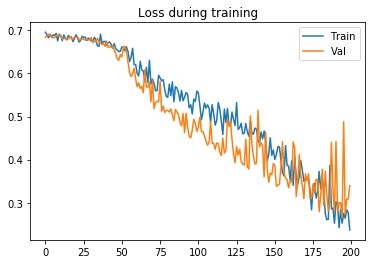

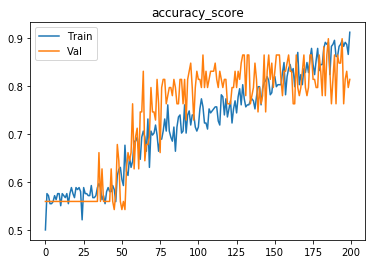

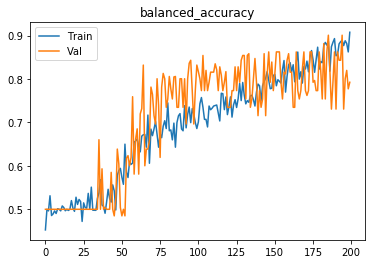

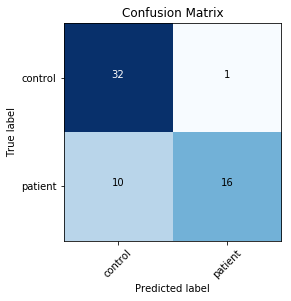

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 787785
[0,    10] loss: 0.71120
[0,    20] loss: 0.69140
[0,    30] loss: 0.72403
[0,    40] loss: 0.69163
[0,    50] loss: 0.70122
Time elapsed: 0h:0m:25s
train accuracy_score: 55.04 %
train balanced_accuracy: 48.20 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.689372
[1,    10] loss: 0.73912
[1,    20] loss: 0.71852
[1,    30] loss: 0.70158
[1,    40] loss: 0.67974
[1,    50] loss: 0.65456
Time elapsed: 0h:1m:1s
train accuracy_score: 56.72 %
train balanced_accuracy: 49.66 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.685981
[2,    10] loss: 0.67814
[2,    20] loss: 0.66965
[2,    30] loss: 0.69410
[2,    40] loss: 0.71215
[2,    50] loss: 0.68255
Time elapsed: 0h:1m:39s
train accuracy_score: 55.46 %
train balanced_accuracy: 48.31 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.685103


val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.674606
[28,    10] loss: 0.68279
[28,    20] loss: 0.69445
[28,    30] loss: 0.70652
[28,    40] loss: 0.67208
[28,    50] loss: 0.68111
Time elapsed: 0h:18m:2s
train accuracy_score: 56.72 %
train balanced_accuracy: 49.79 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.682332
[29,    10] loss: 0.68758
[29,    20] loss: 0.64794
[29,    30] loss: 0.70033
[29,    40] loss: 0.69233
[29,    50] loss: 0.69516
Time elapsed: 0h:18m:39s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.08 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.678741
[30,    10] loss: 0.65444
[30,    20] loss: 0.73229
[30,    30] loss: 0.65403
[30,    40] loss: 0.68651
[30,    50] loss: 0.70046
Time elapsed: 0h:19m:17s
train accuracy_score: 58.40 %
train balanced_accuracy: 51.12 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.672738
[31,    10] loss: 0.63416
[31,    2

Time elapsed: 0h:35m:1s
train accuracy_score: 76.47 %
train balanced_accuracy: 75.14 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.58 %
Val loss: 0.393266
[56,    10] loss: 0.38266
[56,    20] loss: 0.41329
[56,    30] loss: 0.53064
[56,    40] loss: 0.51793
[56,    50] loss: 0.49394
Time elapsed: 0h:35m:39s
train accuracy_score: 78.57 %
train balanced_accuracy: 77.09 %
val accuracy_score: 84.75 %
val balanced_accuracy: 85.55 %
Val loss: 0.405149
[57,    10] loss: 0.49893
[57,    20] loss: 0.59122
[57,    30] loss: 0.56472
[57,    40] loss: 0.59671
[57,    50] loss: 0.50135
Time elapsed: 0h:36m:17s
train accuracy_score: 71.85 %
train balanced_accuracy: 71.38 %
val accuracy_score: 83.05 %
val balanced_accuracy: 81.18 %
Val loss: 0.391745
[58,    10] loss: 0.48826
[58,    20] loss: 0.38230
[58,    30] loss: 0.39291
[58,    40] loss: 0.42228
[58,    50] loss: 0.47216
Time elapsed: 0h:36m:55s
train accuracy_score: 79.83 %
train balanced_accuracy: 78.84 %
val accuracy_score: 89.83

[83,    30] loss: 0.36621
[83,    40] loss: 0.59896
[83,    50] loss: 0.29200
Time elapsed: 0h:52m:40s
train accuracy_score: 85.71 %
train balanced_accuracy: 85.38 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.17 %
Val loss: 0.268153
[84,    10] loss: 0.29168
[84,    20] loss: 0.33905
[84,    30] loss: 0.44045
[84,    40] loss: 0.49754
[84,    50] loss: 0.24666
Time elapsed: 0h:53m:18s
train accuracy_score: 82.77 %
train balanced_accuracy: 82.04 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.28 %
Val loss: 0.301498
[85,    10] loss: 0.24975
[85,    20] loss: 0.26718
[85,    30] loss: 0.22872
[85,    40] loss: 0.37896
[85,    50] loss: 0.28611
Time elapsed: 0h:53m:55s
train accuracy_score: 87.82 %
train balanced_accuracy: 86.81 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.58 %
Val loss: 0.267832
[86,    10] loss: 0.26555
[86,    20] loss: 0.30094
[86,    30] loss: 0.34611
[86,    40] loss: 0.25298
[86,    50] loss: 0.33819
Time elapsed: 0h:54m:33s
train acc

val accuracy_score: 88.14 %
val balanced_accuracy: 86.95 %
Val loss: 0.313708
[111,    10] loss: 0.17999
[111,    20] loss: 0.21651
[111,    30] loss: 0.39019
[111,    40] loss: 0.45424
[111,    50] loss: 0.20624
Time elapsed: 1h:10m:17s
train accuracy_score: 86.13 %
train balanced_accuracy: 85.61 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.25 %
Val loss: 0.258562
[112,    10] loss: 0.17555
[112,    20] loss: 0.18671
[112,    30] loss: 0.17146
[112,    40] loss: 0.29356
[112,    50] loss: 0.24519
Time elapsed: 1h:10m:55s
train accuracy_score: 90.76 %
train balanced_accuracy: 90.67 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.25 %
Val loss: 0.269426
[113,    10] loss: 0.25562
[113,    20] loss: 0.23279
[113,    30] loss: 0.26700
[113,    40] loss: 0.26663
[113,    50] loss: 0.16431
Time elapsed: 1h:11m:33s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.40 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.25 %
Val loss: 0.295739
[114,    10] loss: 

[138,    10] loss: 0.16697
[138,    20] loss: 0.15441
[138,    30] loss: 0.19119
[138,    40] loss: 0.15973
[138,    50] loss: 0.33735
Time elapsed: 1h:27m:13s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.40 %
val accuracy_score: 91.53 %
val balanced_accuracy: 92.42 %
Val loss: 0.245992
[139,    10] loss: 0.15193
[139,    20] loss: 0.35792
[139,    30] loss: 0.14417
[139,    40] loss: 0.24654
[139,    50] loss: 0.20284
Time elapsed: 1h:27m:50s
train accuracy_score: 92.02 %
train balanced_accuracy: 92.03 %
val accuracy_score: 83.05 %
val balanced_accuracy: 81.59 %
Val loss: 0.328808
[140,    10] loss: 0.12482
[140,    20] loss: 0.07738
[140,    30] loss: 0.20902
[140,    40] loss: 0.16637
[140,    50] loss: 0.21185
Time elapsed: 1h:28m:27s
train accuracy_score: 93.70 %
train balanced_accuracy: 93.35 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.17 %
Val loss: 0.212952
[141,    10] loss: 0.16016
[141,    20] loss: 0.13730
[141,    30] loss: 0.13786
[141,    40] los

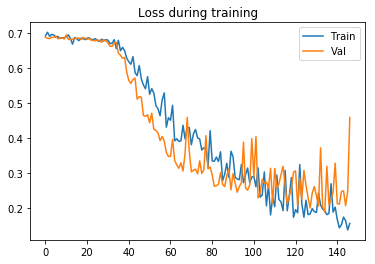

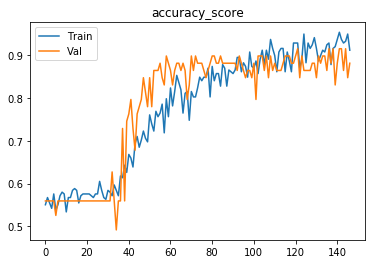

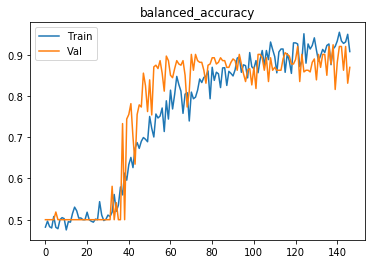

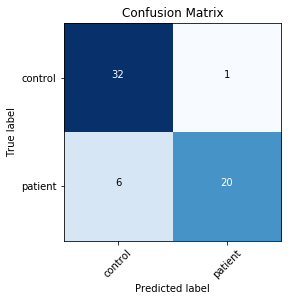

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 787785
[0,    10] loss: 0.68840
Time elapsed: 0h:0m:27s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.07 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.689317
[1,    10] loss: 0.67899
Time elapsed: 0h:1m:6s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.682729
[2,    10] loss: 0.68480
Time elapsed: 0h:1m:45s
train accuracy_score: 56.72 %
train balanced_accuracy: 49.27 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.686552
[3,    10] loss: 0.66786
Time elapsed: 0h:2m:24s
train accuracy_score: 57.14 %
train balanced_accuracy: 49.64 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.686538
[4,    10] loss: 0.67954
Time elapsed: 0h:3m:2s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %

val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.668675
[43,    10] loss: 0.68402
Time elapsed: 0h:28m:19s
train accuracy_score: 57.14 %
train balanced_accuracy: 50.81 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.678664
[44,    10] loss: 0.69445
Time elapsed: 0h:28m:58s
train accuracy_score: 57.14 %
train balanced_accuracy: 50.81 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.669492
[45,    10] loss: 0.66840
Time elapsed: 0h:29m:36s
train accuracy_score: 59.66 %
train balanced_accuracy: 52.74 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.665978
[46,    10] loss: 0.65871
Time elapsed: 0h:30m:14s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.65 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.664067
[47,    10] loss: 0.68019
Time elapsed: 0h:30m:54s
train accuracy_score: 57.14 %
train balanced_accuracy: 55.88 %
val accuracy_score: 55.93 %
val balanced

val accuracy_score: 69.49 %
val balanced_accuracy: 65.79 %
Val loss: 0.546411
[86,    10] loss: 0.58893
Time elapsed: 0h:56m:14s
train accuracy_score: 69.75 %
train balanced_accuracy: 68.65 %
val accuracy_score: 62.71 %
val balanced_accuracy: 58.10 %
Val loss: 0.621812
[87,    10] loss: 0.58279
Time elapsed: 0h:56m:53s
train accuracy_score: 72.69 %
train balanced_accuracy: 71.46 %
val accuracy_score: 62.71 %
val balanced_accuracy: 57.69 %
Val loss: 0.668901
[88,    10] loss: 0.52532
Time elapsed: 0h:57m:31s
train accuracy_score: 71.43 %
train balanced_accuracy: 69.98 %
val accuracy_score: 64.41 %
val balanced_accuracy: 60.02 %
Val loss: 0.579688
[89,    10] loss: 0.61644
Time elapsed: 0h:58m:11s
train accuracy_score: 69.33 %
train balanced_accuracy: 67.89 %
val accuracy_score: 59.32 %
val balanced_accuracy: 53.85 %
Val loss: 0.735249
[90,    10] loss: 0.60145
Time elapsed: 0h:58m:49s
train accuracy_score: 73.11 %
train balanced_accuracy: 71.96 %
val accuracy_score: 62.71 %
val balanced

val accuracy_score: 72.88 %
val balanced_accuracy: 70.05 %
Val loss: 0.473491
[129,    10] loss: 0.54559
Time elapsed: 1h:24m:8s
train accuracy_score: 73.95 %
train balanced_accuracy: 73.47 %
val accuracy_score: 64.41 %
val balanced_accuracy: 59.62 %
Val loss: 0.640247
[130,    10] loss: 0.53632
Time elapsed: 1h:24m:47s
train accuracy_score: 72.69 %
train balanced_accuracy: 71.59 %
val accuracy_score: 67.80 %
val balanced_accuracy: 63.87 %
Val loss: 0.502986
[131,    10] loss: 0.40534
Time elapsed: 1h:25m:26s
train accuracy_score: 80.67 %
train balanced_accuracy: 79.70 %
val accuracy_score: 72.88 %
val balanced_accuracy: 69.64 %
Val loss: 0.464355
[132,    10] loss: 0.45863
Time elapsed: 1h:26m:5s
train accuracy_score: 81.93 %
train balanced_accuracy: 80.92 %
val accuracy_score: 72.88 %
val balanced_accuracy: 70.05 %
Val loss: 0.436780
[133,    10] loss: 0.44854
Time elapsed: 1h:26m:44s
train accuracy_score: 78.15 %
train balanced_accuracy: 76.60 %
val accuracy_score: 86.44 %
val balan

Time elapsed: 1h:51m:27s
train accuracy_score: 84.87 %
train balanced_accuracy: 83.35 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.99 %
Val loss: 0.321116
[172,    10] loss: 0.39773
Time elapsed: 1h:52m:6s
train accuracy_score: 82.35 %
train balanced_accuracy: 81.68 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.40 %
Val loss: 0.329163
[173,    10] loss: 0.33797
Time elapsed: 1h:52m:45s
train accuracy_score: 83.19 %
train balanced_accuracy: 82.80 %
val accuracy_score: 84.75 %
val balanced_accuracy: 83.51 %
Val loss: 0.350969
[174,    10] loss: 0.36307
Time elapsed: 1h:53m:24s
train accuracy_score: 79.83 %
train balanced_accuracy: 78.71 %
val accuracy_score: 76.27 %
val balanced_accuracy: 73.48 %
Val loss: 0.416825
[175,    10] loss: 0.35062
Time elapsed: 1h:54m:4s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.13 %
val accuracy_score: 81.36 %
val balanced_accuracy: 79.25 %
Val loss: 0.360245
[176,    10] loss: 0.34571
Time elapsed: 1h:54m:43s
train accura

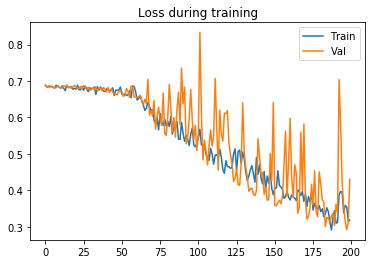

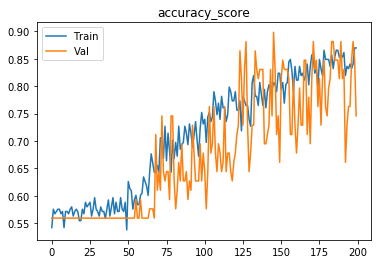

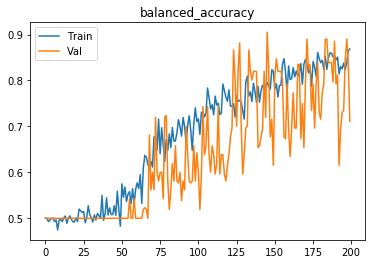

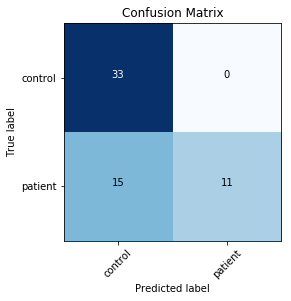

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 787785
[0,    10] loss: 0.69656
[0,    20] loss: 0.68127
[0,    30] loss: 0.68255
[0,    40] loss: 0.70614
[0,    50] loss: 0.67889
Time elapsed: 0h:0m:25s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.688604
[1,    10] loss: 0.70128
[1,    20] loss: 0.67550
[1,    30] loss: 0.69475
[1,    40] loss: 0.66826
[1,    50] loss: 0.69461
Time elapsed: 0h:1m:3s
train accuracy_score: 57.98 %
train balanced_accuracy: 50.50 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.689304
[2,    10] loss: 0.70465
[2,    20] loss: 0.67269
[2,    30] loss: 0.65451
[2,    40] loss: 0.68714
[2,    50] loss: 0.71909
Time elapsed: 0h:1m:41s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.683948
[

val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.680170
[28,    10] loss: 0.65440
[28,    20] loss: 0.63456
[28,    30] loss: 0.74684
[28,    40] loss: 0.63991
[28,    50] loss: 0.71658
Time elapsed: 0h:17m:59s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.680573
[29,    10] loss: 0.68613
[29,    20] loss: 0.68461
[29,    30] loss: 0.68728
[29,    40] loss: 0.69913
[29,    50] loss: 0.66937
Time elapsed: 0h:18m:37s
train accuracy_score: 55.46 %
train balanced_accuracy: 48.96 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.678016
[30,    10] loss: 0.68315
[30,    20] loss: 0.70050
[30,    30] loss: 0.63990
[30,    40] loss: 0.61321
[30,    50] loss: 0.67104
Time elapsed: 0h:19m:15s
train accuracy_score: 57.98 %
train balanced_accuracy: 50.76 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.686278
[31,    10] loss: 0.70364
[31,    

Time elapsed: 0h:34m:59s
train accuracy_score: 64.71 %
train balanced_accuracy: 60.63 %
val accuracy_score: 76.27 %
val balanced_accuracy: 73.89 %
Val loss: 0.624825
[56,    10] loss: 0.67130
[56,    20] loss: 0.62641
[56,    30] loss: 0.64578
[56,    40] loss: 0.62646
[56,    50] loss: 0.62549
Time elapsed: 0h:35m:37s
train accuracy_score: 59.66 %
train balanced_accuracy: 54.82 %
val accuracy_score: 62.71 %
val balanced_accuracy: 58.10 %
Val loss: 0.620564
[57,    10] loss: 0.63819
[57,    20] loss: 0.70230
[57,    30] loss: 0.56854
[57,    40] loss: 0.74457
[57,    50] loss: 0.62516
Time elapsed: 0h:36m:15s
train accuracy_score: 64.71 %
train balanced_accuracy: 61.80 %
val accuracy_score: 72.88 %
val balanced_accuracy: 69.64 %
Val loss: 0.615867
[58,    10] loss: 0.65006
[58,    20] loss: 0.65349
[58,    30] loss: 0.68067
[58,    40] loss: 0.59840
[58,    50] loss: 0.59813
Time elapsed: 0h:36m:52s
train accuracy_score: 62.18 %
train balanced_accuracy: 57.53 %
val accuracy_score: 57.6

[83,    30] loss: 0.50317
[83,    40] loss: 0.52752
[83,    50] loss: 0.50576
Time elapsed: 0h:52m:50s
train accuracy_score: 76.89 %
train balanced_accuracy: 75.89 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.43 %
Val loss: 0.428571
[84,    10] loss: 0.50226
[84,    20] loss: 0.45489
[84,    30] loss: 0.66698
[84,    40] loss: 0.48730
[84,    50] loss: 0.51792
Time elapsed: 0h:53m:27s
train accuracy_score: 73.53 %
train balanced_accuracy: 72.45 %
val accuracy_score: 88.14 %
val balanced_accuracy: 87.76 %
Val loss: 0.409872
[85,    10] loss: 0.51774
[85,    20] loss: 0.49144
[85,    30] loss: 0.54954
[85,    40] loss: 0.48813
[85,    50] loss: 0.47332
Time elapsed: 0h:54m:4s
train accuracy_score: 74.37 %
train balanced_accuracy: 73.44 %
val accuracy_score: 77.97 %
val balanced_accuracy: 75.82 %
Val loss: 0.409624
[86,    10] loss: 0.41323
[86,    20] loss: 0.55500
[86,    30] loss: 0.39699
[86,    40] loss: 0.40207
[86,    50] loss: 0.55954
Time elapsed: 0h:54m:41s
train accu

val accuracy_score: 86.44 %
val balanced_accuracy: 85.43 %
Val loss: 0.311885
[111,    10] loss: 0.43573
[111,    20] loss: 0.42226
[111,    30] loss: 0.38199
[111,    40] loss: 0.45902
[111,    50] loss: 0.45884
Time elapsed: 1h:11m:17s
train accuracy_score: 78.99 %
train balanced_accuracy: 78.63 %
val accuracy_score: 83.05 %
val balanced_accuracy: 81.59 %
Val loss: 0.348791
[112,    10] loss: 0.61816
[112,    20] loss: 0.38136
[112,    30] loss: 0.32974
[112,    40] loss: 0.33377
[112,    50] loss: 0.46313
Time elapsed: 1h:11m:54s
train accuracy_score: 81.09 %
train balanced_accuracy: 80.32 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.69 %
Val loss: 0.323215
[113,    10] loss: 0.48620
[113,    20] loss: 0.53035
[113,    30] loss: 0.44104
[113,    40] loss: 0.45556
[113,    50] loss: 0.51541
Time elapsed: 1h:12m:35s
train accuracy_score: 76.05 %
train balanced_accuracy: 74.64 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.69 %
Val loss: 0.299671
[114,    10] loss: 

[138,    10] loss: 0.37746
[138,    20] loss: 0.39562
[138,    30] loss: 0.38965
[138,    40] loss: 0.39144
[138,    50] loss: 0.46039
Time elapsed: 1h:28m:49s
train accuracy_score: 81.93 %
train balanced_accuracy: 81.44 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.20 %
Val loss: 0.266621
[139,    10] loss: 0.41928
[139,    20] loss: 0.35218
[139,    30] loss: 0.50270
[139,    40] loss: 0.38380
[139,    50] loss: 0.30074
Time elapsed: 1h:29m:34s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.13 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.20 %
Val loss: 0.254973
[140,    10] loss: 0.52884
[140,    20] loss: 0.29658
[140,    30] loss: 0.26864
[140,    40] loss: 0.36734
[140,    50] loss: 0.27355
Time elapsed: 1h:30m:14s
train accuracy_score: 88.24 %
train balanced_accuracy: 87.31 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.17 %
Val loss: 0.243596
[141,    10] loss: 0.36575
[141,    20] loss: 0.37229
[141,    30] loss: 0.32559
[141,    40] los

[165,    40] loss: 0.41589
[165,    50] loss: 0.30116
Time elapsed: 1h:46m:36s
train accuracy_score: 85.29 %
train balanced_accuracy: 84.75 %
val accuracy_score: 89.83 %
val balanced_accuracy: 90.09 %
Val loss: 0.204634
[166,    10] loss: 0.18364
[166,    20] loss: 0.31547
[166,    30] loss: 0.33221
[166,    40] loss: 0.19555
[166,    50] loss: 0.38700
Time elapsed: 1h:47m:14s
train accuracy_score: 88.24 %
train balanced_accuracy: 88.09 %
val accuracy_score: 89.83 %
val balanced_accuracy: 90.09 %
Val loss: 0.199919
[167,    10] loss: 0.33165
[167,    20] loss: 0.32760
[167,    30] loss: 0.32499
[167,    40] loss: 0.29679
[167,    50] loss: 0.24350
Time elapsed: 1h:47m:52s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.26 %
val accuracy_score: 89.83 %
val balanced_accuracy: 90.09 %
Val loss: 0.201638
[168,    10] loss: 0.25956
[168,    20] loss: 0.41765
[168,    30] loss: 0.26789
[168,    40] loss: 0.22344
[168,    50] loss: 0.19509
Time elapsed: 1h:48m:29s
train accuracy_sco

val accuracy_score: 91.53 %
val balanced_accuracy: 91.61 %
Val loss: 0.194181
[193,    10] loss: 0.20301
[193,    20] loss: 0.19999
[193,    30] loss: 0.20708
[193,    40] loss: 0.26684
[193,    50] loss: 0.26494
Time elapsed: 2h:4m:32s
train accuracy_score: 89.92 %
train balanced_accuracy: 89.81 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.61 %
Val loss: 0.184372
[194,    10] loss: 0.22505
[194,    20] loss: 0.15056
[194,    30] loss: 0.23915
[194,    40] loss: 0.40974
[194,    50] loss: 0.17755
Time elapsed: 2h:5m:10s
train accuracy_score: 89.08 %
train balanced_accuracy: 88.43 %
val accuracy_score: 91.53 %
val balanced_accuracy: 92.02 %
Val loss: 0.199152
[195,    10] loss: 0.26050
[195,    20] loss: 0.28140
[195,    30] loss: 0.24017
[195,    40] loss: 0.27743
[195,    50] loss: 0.17072
Time elapsed: 2h:5m:47s
train accuracy_score: 89.92 %
train balanced_accuracy: 89.68 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.61 %
Val loss: 0.190410
[196,    10] loss: 0.2

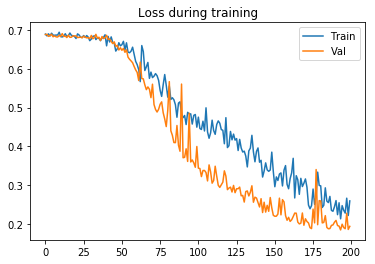

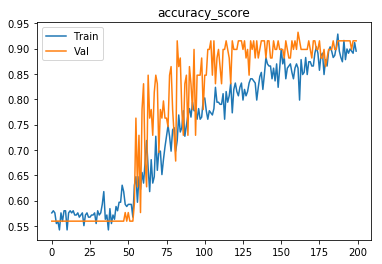

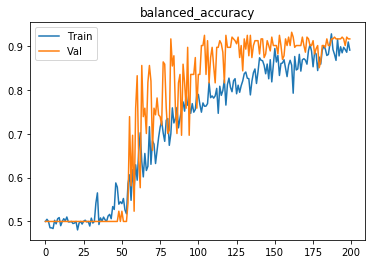

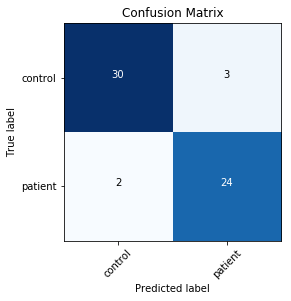

Finished outer fold.
{'final_acc': 0.916083916083916, 'best_acc': 0.9312354312354313, 'final_iter': 200, 'best_iter': 162, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 4}
###### Starting outer fold 3
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 1303769
[0,    10] loss: 0.70946
[0,    20] loss: 0.70648
[0,    30] loss: 0.69681
[0,    40] loss: 0.68572
[0,    50] loss: 0.73535
Time elapsed: 0h:0m:24s
train accuracy_score: 55.04 %
train balanced_accuracy: 51.55 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.726125
[1,    10] loss: 0.69212
[1,    20] loss: 0.74485
[1,    30] loss: 0.68478
[1,    40] loss: 0.71182
[1,    50] loss: 0.66971
Time elapsed: 0h:1m:2s
train accuracy_score: 55.46 %
train balanced_accuracy: 51.93 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.711250
[2,    10] l

val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.695930
[27,    10] loss: 0.68525
[27,    20] loss: 0.69957
[27,    30] loss: 0.67596
[27,    40] loss: 0.65650
[27,    50] loss: 0.68094
Time elapsed: 0h:18m:13s
train accuracy_score: 55.46 %
train balanced_accuracy: 49.62 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.710307
[28,    10] loss: 0.70220
[28,    20] loss: 0.68366
[28,    30] loss: 0.69190
[28,    40] loss: 0.66332
[28,    50] loss: 0.69643
Time elapsed: 0h:18m:51s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.700930
[29,    10] loss: 0.68760
[29,    20] loss: 0.70049
[29,    30] loss: 0.67455
[29,    40] loss: 0.69076
[29,    50] loss: 0.68102
Time elapsed: 0h:19m:28s
train accuracy_score: 55.04 %
train balanced_accuracy: 49.35 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.701806
[30,    10] loss: 0.66710
[30,    

Time elapsed: 0h:35m:10s
train accuracy_score: 57.56 %
train balanced_accuracy: 55.31 %
val accuracy_score: 59.32 %
val balanced_accuracy: 57.32 %
Val loss: 0.652999
[55,    10] loss: 0.66764
[55,    20] loss: 0.64584
[55,    30] loss: 0.67643
[55,    40] loss: 0.65907
[55,    50] loss: 0.63980
Time elapsed: 0h:35m:47s
train accuracy_score: 63.45 %
train balanced_accuracy: 62.78 %
val accuracy_score: 61.02 %
val balanced_accuracy: 62.90 %
Val loss: 0.652213
[56,    10] loss: 0.62727
[56,    20] loss: 0.67674
[56,    30] loss: 0.59982
[56,    40] loss: 0.65598
[56,    50] loss: 0.67089
Time elapsed: 0h:36m:25s
train accuracy_score: 64.71 %
train balanced_accuracy: 62.31 %
val accuracy_score: 61.02 %
val balanced_accuracy: 62.56 %
Val loss: 0.648738
[57,    10] loss: 0.58220
[57,    20] loss: 0.57345
[57,    30] loss: 0.72423
[57,    40] loss: 0.68317
[57,    50] loss: 0.74093
Time elapsed: 0h:37m:4s
train accuracy_score: 65.13 %
train balanced_accuracy: 63.18 %
val accuracy_score: 62.71

[82,    30] loss: 0.39839
[82,    40] loss: 0.40160
[82,    50] loss: 0.34936
Time elapsed: 0h:53m:3s
train accuracy_score: 82.77 %
train balanced_accuracy: 82.28 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.53 %
Val loss: 0.428158
[83,    10] loss: 0.50934
[83,    20] loss: 0.37196
[83,    30] loss: 0.52824
[83,    40] loss: 0.26982
[83,    50] loss: 0.33125
Time elapsed: 0h:53m:41s
train accuracy_score: 83.19 %
train balanced_accuracy: 83.16 %
val accuracy_score: 81.36 %
val balanced_accuracy: 82.09 %
Val loss: 0.470259
[84,    10] loss: 0.32815
[84,    20] loss: 0.37033
[84,    30] loss: 0.39722
[84,    40] loss: 0.46996
[84,    50] loss: 0.40132
Time elapsed: 0h:54m:18s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.81 %
val accuracy_score: 76.27 %
val balanced_accuracy: 77.25 %
Val loss: 0.485104
[85,    10] loss: 0.24692
[85,    20] loss: 0.29699
[85,    30] loss: 0.35519
[85,    40] loss: 0.38948
[85,    50] loss: 0.33862
Time elapsed: 0h:54m:55s
train accu

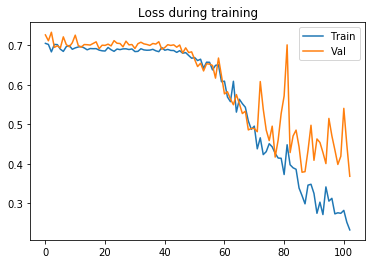

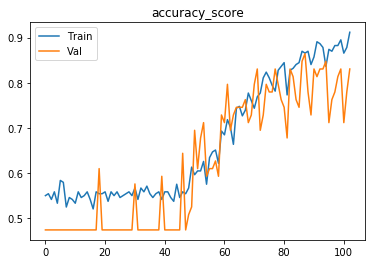

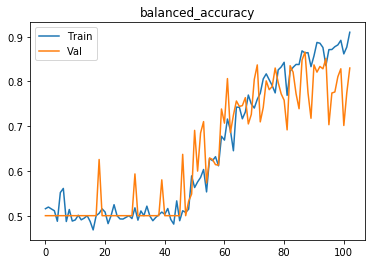

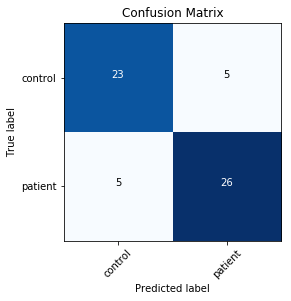

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 1303769
[0,    10] loss: 0.66043
Time elapsed: 0h:0m:28s
train accuracy_score: 54.20 %
train balanced_accuracy: 48.50 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.707843
[1,    10] loss: 0.68885
Time elapsed: 0h:1m:9s
train accuracy_score: 48.74 %
train balanced_accuracy: 49.12 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.693953
[2,    10] loss: 0.70014
Time elapsed: 0h:1m:53s
train accuracy_score: 56.30 %
train balanced_accuracy: 51.18 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.700206
[3,    10] loss: 0.68380
Time elapsed: 0h:2m:36s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.700382
[4,    10] loss: 0.69925
Time elapsed: 0h:3m:18s
train accuracy_score: 51.68 %
train balanced_accuracy: 47.14

val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.698026
[43,    10] loss: 0.68608
Time elapsed: 0h:28m:56s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.95 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.701012
[44,    10] loss: 0.68999
Time elapsed: 0h:29m:35s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.88 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.698860
[45,    10] loss: 0.69535
Time elapsed: 0h:30m:15s
train accuracy_score: 57.14 %
train balanced_accuracy: 52.23 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.697299
[46,    10] loss: 0.68682
Time elapsed: 0h:30m:55s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.30 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.701141
[47,    10] loss: 0.69253
Time elapsed: 0h:31m:35s
train accuracy_score: 55.46 %
train balanced_accuracy: 50.33 %
val accuracy_score: 47.46 %
val balanced

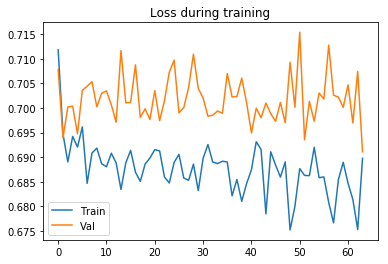

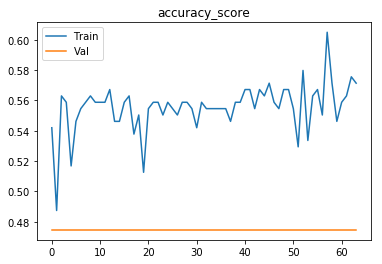

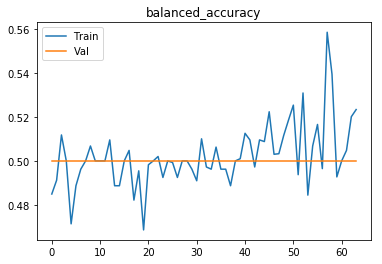

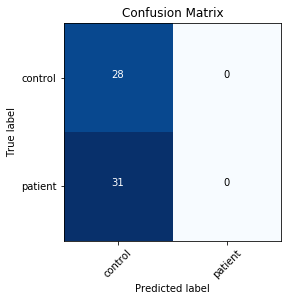

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 787785
[0,    10] loss: 0.69714
[0,    20] loss: 0.67678
[0,    30] loss: 0.69608
Time elapsed: 0h:0m:26s
train accuracy_score: 55.04 %
train balanced_accuracy: 49.55 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.707645
[1,    10] loss: 0.66724
[1,    20] loss: 0.69853
[1,    30] loss: 0.69989
Time elapsed: 0h:1m:5s
train accuracy_score: 54.20 %
train balanced_accuracy: 49.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.695874
[2,    10] loss: 0.67799
[2,    20] loss: 0.68746
[2,    30] loss: 0.71137
Time elapsed: 0h:1m:43s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.30 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.696752
[3,    10] loss: 0.69603
[3,    20] loss: 0.69768
[3,    30] loss: 0.68756
Time elapsed: 0h:2m:22s
train accuracy_score: 52.94 %
train balanced_accurac

Time elapsed: 0h:21m:34s
train accuracy_score: 56.72 %
train balanced_accuracy: 51.45 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.704407
[34,    10] loss: 0.68556
[34,    20] loss: 0.65825
[34,    30] loss: 0.67378
Time elapsed: 0h:22m:13s
train accuracy_score: 56.72 %
train balanced_accuracy: 51.35 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.699909
[35,    10] loss: 0.69359
[35,    20] loss: 0.69149
[35,    30] loss: 0.71308
Time elapsed: 0h:22m:52s
train accuracy_score: 54.62 %
train balanced_accuracy: 48.97 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.691854
[36,    10] loss: 0.68136
[36,    20] loss: 0.68191
[36,    30] loss: 0.68259
Time elapsed: 0h:23m:30s
train accuracy_score: 55.04 %
train balanced_accuracy: 49.25 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.695996
[37,    10] loss: 0.66582
[37,    20] loss: 0.66989
[37,    30] loss: 0.70750
Time elapsed: 0h:24m:12s

[67,    10] loss: 0.57895
[67,    20] loss: 0.54003
[67,    30] loss: 0.50405
Time elapsed: 0h:44m:1s
train accuracy_score: 70.17 %
train balanced_accuracy: 68.60 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.57 %
Val loss: 0.547025
[68,    10] loss: 0.57395
[68,    20] loss: 0.52493
[68,    30] loss: 0.57484
Time elapsed: 0h:44m:43s
train accuracy_score: 73.11 %
train balanced_accuracy: 72.53 %
val accuracy_score: 66.10 %
val balanced_accuracy: 67.74 %
Val loss: 0.574850
[69,    10] loss: 0.59064
[69,    20] loss: 0.55081
[69,    30] loss: 0.52303
Time elapsed: 0h:45m:23s
train accuracy_score: 74.79 %
train balanced_accuracy: 74.24 %
val accuracy_score: 72.88 %
val balanced_accuracy: 74.19 %
Val loss: 0.570832
[70,    10] loss: 0.51954
[70,    20] loss: 0.57025
[70,    30] loss: 0.48940
Time elapsed: 0h:46m:5s
train accuracy_score: 72.27 %
train balanced_accuracy: 71.08 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.18 %
Val loss: 0.505180
[71,    10] loss: 0.56675


val accuracy_score: 81.36 %
val balanced_accuracy: 81.57 %
Val loss: 0.398432
[101,    10] loss: 0.43741
[101,    20] loss: 0.48149
[101,    30] loss: 0.29211
Time elapsed: 1h:6m:29s
train accuracy_score: 84.45 %
train balanced_accuracy: 83.88 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.02 %
Val loss: 0.352105
[102,    10] loss: 0.35432
[102,    20] loss: 0.39083
[102,    30] loss: 0.44789
Time elapsed: 1h:7m:7s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.71 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.97 %
Val loss: 0.357897
[103,    10] loss: 0.33257
[103,    20] loss: 0.41934
[103,    30] loss: 0.38048
Time elapsed: 1h:7m:46s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.36 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.39 %
Val loss: 0.356792
[104,    10] loss: 0.34895
[104,    20] loss: 0.43358
[104,    30] loss: 0.44450
Time elapsed: 1h:8m:24s
train accuracy_score: 82.77 %
train balanced_accuracy: 82.28 %
val accuracy_scor

[134,    10] loss: 0.28030
[134,    20] loss: 0.24692
[134,    30] loss: 0.24145
Time elapsed: 1h:27m:29s
train accuracy_score: 86.13 %
train balanced_accuracy: 85.89 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.36 %
Val loss: 0.272743
[135,    10] loss: 0.32718
[135,    20] loss: 0.36208
[135,    30] loss: 0.19800
Time elapsed: 1h:28m:8s
train accuracy_score: 89.92 %
train balanced_accuracy: 89.77 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.98 %
Val loss: 0.268647
[136,    10] loss: 0.27871
[136,    20] loss: 0.32557
[136,    30] loss: 0.31133
Time elapsed: 1h:28m:45s
train accuracy_score: 86.55 %
train balanced_accuracy: 85.96 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.98 %
Val loss: 0.277008
[137,    10] loss: 0.30821
[137,    20] loss: 0.34650
[137,    30] loss: 0.28289
Time elapsed: 1h:29m:23s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.52 %
val accuracy_score: 86.44 %
val balanced_accuracy: 87.10 %
Val loss: 0.314793
[138,    10] 

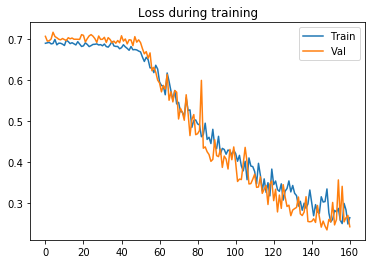

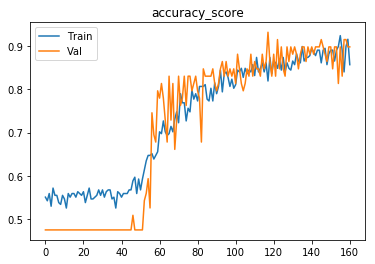

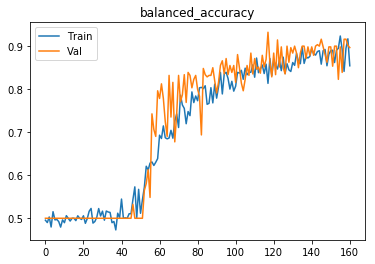

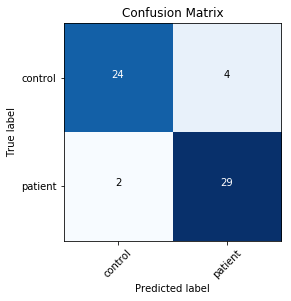

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 787785
[0,    10] loss: 0.69882
Time elapsed: 0h:0m:27s
train accuracy_score: 51.68 %
train balanced_accuracy: 48.55 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.699950
[1,    10] loss: 0.69614
Time elapsed: 0h:1m:6s
train accuracy_score: 53.36 %
train balanced_accuracy: 49.05 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.704355
[2,    10] loss: 0.71302
Time elapsed: 0h:1m:45s
train accuracy_score: 52.10 %
train balanced_accuracy: 46.92 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.703239
[3,    10] loss: 0.68905
Time elapsed: 0h:2m:24s
train accuracy_score: 55.04 %
train balanced_accuracy: 49.55 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.707314
[4,    10] loss: 0.69036
Time elapsed: 0h:3m:3s
train accuracy_score: 57.14 %
train balanced_accuracy: 51.53 

val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.702941
[43,    10] loss: 0.69886
Time elapsed: 0h:28m:58s
train accuracy_score: 57.14 %
train balanced_accuracy: 52.23 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.695515
[44,    10] loss: 0.68767
Time elapsed: 0h:29m:38s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.95 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.696470
[45,    10] loss: 0.67525
Time elapsed: 0h:30m:17s
train accuracy_score: 55.46 %
train balanced_accuracy: 49.92 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.691785
[46,    10] loss: 0.67112
Time elapsed: 0h:30m:57s
train accuracy_score: 61.34 %
train balanced_accuracy: 58.60 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.700614
[47,    10] loss: 0.67162
Time elapsed: 0h:31m:36s
train accuracy_score: 57.56 %
train balanced_accuracy: 52.21 %
val accuracy_score: 64.41 %
val balanced

val accuracy_score: 79.66 %
val balanced_accuracy: 80.13 %
Val loss: 0.419018
[86,    10] loss: 0.44567
Time elapsed: 0h:58m:21s
train accuracy_score: 80.25 %
train balanced_accuracy: 79.92 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.27 %
Val loss: 0.402828
[87,    10] loss: 0.48400
Time elapsed: 0h:59m:1s
train accuracy_score: 77.73 %
train balanced_accuracy: 76.77 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.01 %
Val loss: 0.417587
[88,    10] loss: 0.50959
Time elapsed: 0h:59m:40s
train accuracy_score: 76.89 %
train balanced_accuracy: 76.12 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.18 %
Val loss: 0.390870
[89,    10] loss: 0.42556
Time elapsed: 1h:0m:19s
train accuracy_score: 81.93 %
train balanced_accuracy: 81.83 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.18 %
Val loss: 0.412002
[90,    10] loss: 0.45651
Time elapsed: 1h:0m:59s
train accuracy_score: 78.15 %
train balanced_accuracy: 77.54 %
val accuracy_score: 81.36 %
val balanced_ac

val accuracy_score: 84.75 %
val balanced_accuracy: 84.45 %
Val loss: 0.315351
[129,    10] loss: 0.30689
Time elapsed: 1h:27m:28s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.22 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.06 %
Val loss: 0.296534
[130,    10] loss: 0.34176
Time elapsed: 1h:28m:6s
train accuracy_score: 86.55 %
train balanced_accuracy: 86.47 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.27 %
Val loss: 0.344422
[131,    10] loss: 0.37029
Time elapsed: 1h:28m:45s
train accuracy_score: 86.13 %
train balanced_accuracy: 85.49 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.27 %
Val loss: 0.298728
[132,    10] loss: 0.27113
Time elapsed: 1h:29m:25s
train accuracy_score: 85.29 %
train balanced_accuracy: 85.44 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.83 %
Val loss: 0.305700
[133,    10] loss: 0.28553
Time elapsed: 1h:30m:4s
train accuracy_score: 86.13 %
train balanced_accuracy: 85.69 %
val accuracy_score: 84.75 %
val balan

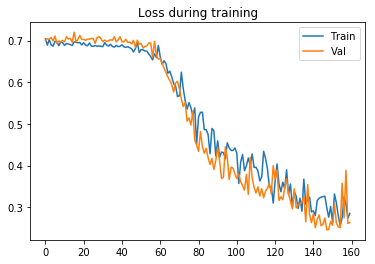

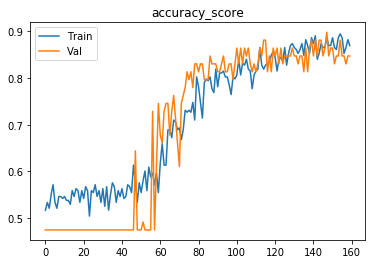

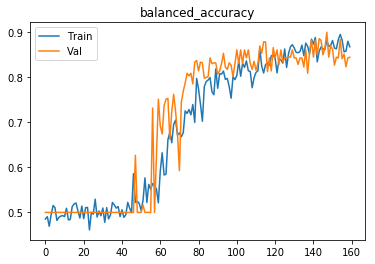

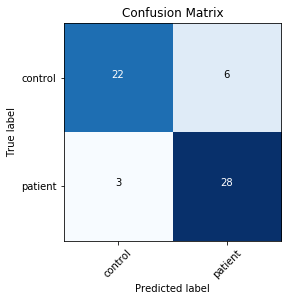

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 787785
[0,    10] loss: 0.69971
Time elapsed: 0h:0m:28s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.75 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.710427
[1,    10] loss: 0.69847
Time elapsed: 0h:1m:7s
train accuracy_score: 55.04 %
train balanced_accuracy: 50.95 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.704963
[2,    10] loss: 0.67290
Time elapsed: 0h:1m:48s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.58 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.702774
[3,    10] loss: 0.69236
Time elapsed: 0h:2m:28s
train accuracy_score: 50.00 %
train balanced_accuracy: 47.04 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.704024
[4,    10] loss: 0.70508
Time elapsed: 0h:3m:8s
train accuracy_score: 55.46 %
train balanced_accuracy: 49.72 

val accuracy_score: 77.97 %
val balanced_accuracy: 78.00 %
Val loss: 0.596696
[43,    10] loss: 0.58157
Time elapsed: 0h:29m:12s
train accuracy_score: 70.17 %
train balanced_accuracy: 68.60 %
val accuracy_score: 76.27 %
val balanced_accuracy: 76.38 %
Val loss: 0.584290
[44,    10] loss: 0.60605
Time elapsed: 0h:29m:53s
train accuracy_score: 69.75 %
train balanced_accuracy: 68.62 %
val accuracy_score: 71.19 %
val balanced_accuracy: 72.24 %
Val loss: 0.602518
[45,    10] loss: 0.60036
Time elapsed: 0h:30m:34s
train accuracy_score: 69.33 %
train balanced_accuracy: 68.75 %
val accuracy_score: 67.80 %
val balanced_accuracy: 69.35 %
Val loss: 0.586212
[46,    10] loss: 0.59051
Time elapsed: 0h:31m:14s
train accuracy_score: 70.17 %
train balanced_accuracy: 69.60 %
val accuracy_score: 62.71 %
val balanced_accuracy: 64.52 %
Val loss: 0.639997
[47,    10] loss: 0.56460
Time elapsed: 0h:31m:54s
train accuracy_score: 68.07 %
train balanced_accuracy: 66.22 %
val accuracy_score: 79.66 %
val balanced

val accuracy_score: 84.75 %
val balanced_accuracy: 84.10 %
Val loss: 0.380631
[86,    10] loss: 0.41409
Time elapsed: 0h:57m:51s
train accuracy_score: 80.25 %
train balanced_accuracy: 79.92 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.71 %
Val loss: 0.357375
[87,    10] loss: 0.40459
Time elapsed: 0h:58m:32s
train accuracy_score: 81.93 %
train balanced_accuracy: 81.93 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.70 %
Val loss: 0.383674
[88,    10] loss: 0.36349
Time elapsed: 0h:59m:11s
train accuracy_score: 81.93 %
train balanced_accuracy: 81.43 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.54 %
Val loss: 0.316190
[89,    10] loss: 0.37176
Time elapsed: 0h:59m:51s
train accuracy_score: 84.45 %
train balanced_accuracy: 84.09 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.54 %
Val loss: 0.328725
[90,    10] loss: 0.34074
Time elapsed: 1h:0m:30s
train accuracy_score: 80.25 %
train balanced_accuracy: 79.62 %
val accuracy_score: 84.75 %
val balanced_

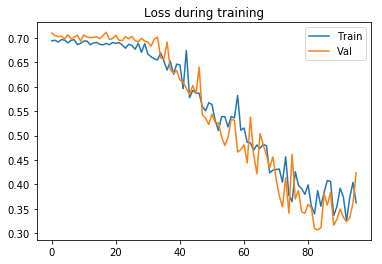

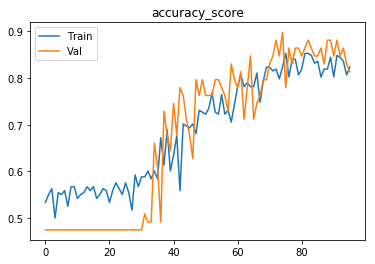

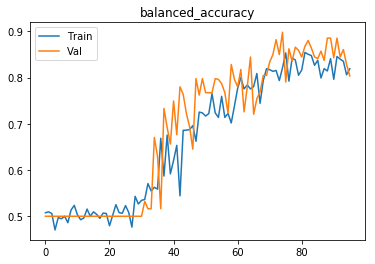

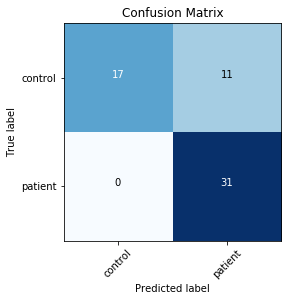

Finished outer fold.
{'final_acc': 0.8963133640552995, 'best_acc': 0.9320276497695852, 'final_iter': 161, 'best_iter': 118, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 2}
###### Starting outer fold 4
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 1303769
[0,    10] loss: 0.68579
[0,    20] loss: 0.75775
[0,    30] loss: 0.70358
[0,    40] loss: 0.69990
[0,    50] loss: 0.67263
Time elapsed: 0h:0m:25s
train accuracy_score: 49.58 %
train balanced_accuracy: 48.52 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.691376
[1,    10] loss: 0.67153
[1,    20] loss: 0.66853
[1,    30] loss: 0.66078
[1,    40] loss: 0.73235
[1,    50] loss: 0.67591
Time elapsed: 0h:1m:2s
train accuracy_score: 57.14 %
train balanced_accuracy: 54.27 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.694087
[2,    10] l

val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.687991
[27,    10] loss: 0.70042
[27,    20] loss: 0.69089
[27,    30] loss: 0.67170
[27,    40] loss: 0.71491
[27,    50] loss: 0.68430
Time elapsed: 0h:17m:20s
train accuracy_score: 55.04 %
train balanced_accuracy: 51.17 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.687008
[28,    10] loss: 0.69734
[28,    20] loss: 0.69799
[28,    30] loss: 0.66965
[28,    40] loss: 0.70260
[28,    50] loss: 0.67574
Time elapsed: 0h:17m:58s
train accuracy_score: 53.78 %
train balanced_accuracy: 49.39 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.683132
[29,    10] loss: 0.67997
[29,    20] loss: 0.69733
[29,    30] loss: 0.67854
[29,    40] loss: 0.64423
[29,    50] loss: 0.73469
Time elapsed: 0h:18m:35s
train accuracy_score: 54.62 %
train balanced_accuracy: 51.96 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.688303
[30,    10] loss: 0.69758
[30,    

Time elapsed: 0h:34m:10s
train accuracy_score: 60.08 %
train balanced_accuracy: 59.78 %
val accuracy_score: 67.80 %
val balanced_accuracy: 68.29 %
Val loss: 0.642998
[55,    10] loss: 0.63916
[55,    20] loss: 0.70834
[55,    30] loss: 0.62575
[55,    40] loss: 0.61304
[55,    50] loss: 0.56192
Time elapsed: 0h:34m:48s
train accuracy_score: 67.65 %
train balanced_accuracy: 66.39 %
val accuracy_score: 72.88 %
val balanced_accuracy: 72.97 %
Val loss: 0.622733
[56,    10] loss: 0.56682
[56,    20] loss: 0.53674
[56,    30] loss: 0.63709
[56,    40] loss: 0.65697
[56,    50] loss: 0.62125
Time elapsed: 0h:35m:25s
train accuracy_score: 71.01 %
train balanced_accuracy: 70.72 %
val accuracy_score: 59.32 %
val balanced_accuracy: 57.58 %
Val loss: 0.627918
[57,    10] loss: 0.63551
[57,    20] loss: 0.56924
[57,    30] loss: 0.61675
[57,    40] loss: 0.64192
[57,    50] loss: 0.64525
Time elapsed: 0h:36m:3s
train accuracy_score: 63.03 %
train balanced_accuracy: 62.16 %
val accuracy_score: 54.24

[82,    30] loss: 0.40860
[82,    40] loss: 0.33807
[82,    50] loss: 0.43119
Time elapsed: 0h:51m:42s
train accuracy_score: 81.09 %
train balanced_accuracy: 81.20 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.37 %
Val loss: 0.473149
[83,    10] loss: 0.47055
[83,    20] loss: 0.43598
[83,    30] loss: 0.50711
[83,    40] loss: 0.36680
[83,    50] loss: 0.30534
Time elapsed: 0h:52m:20s
train accuracy_score: 81.51 %
train balanced_accuracy: 81.35 %
val accuracy_score: 77.97 %
val balanced_accuracy: 76.22 %
Val loss: 0.547007
[84,    10] loss: 0.45805
[84,    20] loss: 0.45268
[84,    30] loss: 0.34486
[84,    40] loss: 0.49418
[84,    50] loss: 0.34457
Time elapsed: 0h:52m:57s
train accuracy_score: 79.83 %
train balanced_accuracy: 79.42 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.37 %
Val loss: 0.467418
[85,    10] loss: 0.42188
[85,    20] loss: 0.52537
[85,    30] loss: 0.31386
[85,    40] loss: 0.47901
[85,    50] loss: 0.33568
Time elapsed: 0h:53m:35s
train acc

[110,    10] loss: 0.33263
[110,    20] loss: 0.35421
[110,    30] loss: 0.25805
[110,    40] loss: 0.30225
[110,    50] loss: 0.34682
Time elapsed: 1h:9m:12s
train accuracy_score: 86.97 %
train balanced_accuracy: 86.90 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.37 %
Val loss: 0.407890
[111,    10] loss: 0.24246
[111,    20] loss: 0.37828
[111,    30] loss: 0.23882
[111,    40] loss: 0.49346
[111,    50] loss: 0.26824
Time elapsed: 1h:9m:49s
train accuracy_score: 86.13 %
train balanced_accuracy: 85.90 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.37 %
Val loss: 0.401305
[112,    10] loss: 0.24908
[112,    20] loss: 0.43231
[112,    30] loss: 0.37952
[112,    40] loss: 0.28626
[112,    50] loss: 0.27287
Time elapsed: 1h:10m:27s
train accuracy_score: 85.71 %
train balanced_accuracy: 85.75 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.08 %
Val loss: 0.479299
[113,    10] loss: 0.33739
[113,    20] loss: 0.38936
[113,    30] loss: 0.28357
[113,    40] loss:

[137,    40] loss: 0.35141
[137,    50] loss: 0.28005
Time elapsed: 1h:26m:5s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.59 %
val accuracy_score: 83.05 %
val balanced_accuracy: 81.77 %
Val loss: 0.532269
[138,    10] loss: 0.28639
[138,    20] loss: 0.25876
[138,    30] loss: 0.15183
[138,    40] loss: 0.27553
[138,    50] loss: 0.27673
Time elapsed: 1h:26m:43s
train accuracy_score: 88.24 %
train balanced_accuracy: 88.06 %
val accuracy_score: 81.36 %
val balanced_accuracy: 80.21 %
Val loss: 0.426528
[139,    10] loss: 0.18197
[139,    20] loss: 0.32394
[139,    30] loss: 0.15783
[139,    40] loss: 0.35949
[139,    50] loss: 0.26816
Time elapsed: 1h:27m:20s
train accuracy_score: 88.24 %
train balanced_accuracy: 88.06 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.37 %
Val loss: 0.379072
[140,    10] loss: 0.28958
[140,    20] loss: 0.16196
[140,    30] loss: 0.20479
[140,    40] loss: 0.15544
[140,    50] loss: 0.16008
Time elapsed: 1h:27m:57s
train accuracy_scor

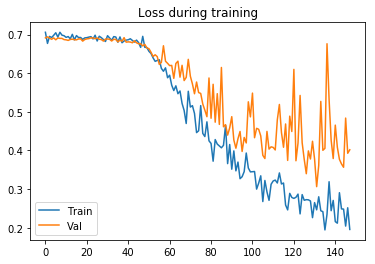

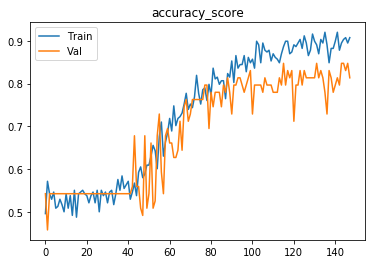

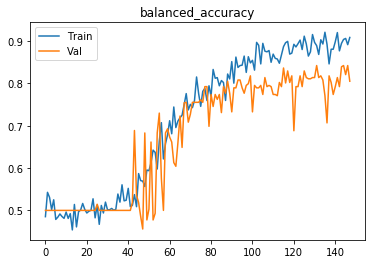

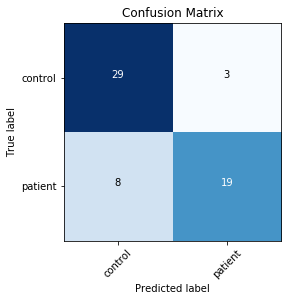

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 1303769
[0,    10] loss: 0.70012
Time elapsed: 0h:0m:25s
train accuracy_score: 49.58 %
train balanced_accuracy: 46.17 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.687185
[1,    10] loss: 0.68978
Time elapsed: 0h:1m:4s
train accuracy_score: 51.26 %
train balanced_accuracy: 47.86 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.690827
[2,    10] loss: 0.69516
Time elapsed: 0h:1m:43s
train accuracy_score: 53.78 %
train balanced_accuracy: 51.35 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.692755
[3,    10] loss: 0.70485
Time elapsed: 0h:2m:22s
train accuracy_score: 51.68 %
train balanced_accuracy: 48.80 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.696156
[4,    10] loss: 0.71826
Time elapsed: 0h:3m:2s
train accuracy_score: 53.78 %
train balanced_accuracy: 50.88

val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.689290
[43,    10] loss: 0.67696
Time elapsed: 0h:28m:19s
train accuracy_score: 55.04 %
train balanced_accuracy: 51.09 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.678994
[44,    10] loss: 0.68930
Time elapsed: 0h:28m:59s
train accuracy_score: 55.88 %
train balanced_accuracy: 54.05 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.679433
[45,    10] loss: 0.67957
Time elapsed: 0h:29m:38s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.40 %
val accuracy_score: 52.54 %
val balanced_accuracy: 49.31 %
Val loss: 0.680974
[46,    10] loss: 0.66847
Time elapsed: 0h:30m:18s
train accuracy_score: 60.92 %
train balanced_accuracy: 59.29 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.29 %
Val loss: 0.677254
[47,    10] loss: 0.70077
Time elapsed: 0h:30m:57s
train accuracy_score: 56.72 %
train balanced_accuracy: 56.39 %
val accuracy_score: 52.54 %
val balanced

val accuracy_score: 69.49 %
val balanced_accuracy: 67.82 %
Val loss: 0.580894
[86,    10] loss: 0.48302
Time elapsed: 0h:56m:16s
train accuracy_score: 79.83 %
train balanced_accuracy: 79.66 %
val accuracy_score: 72.88 %
val balanced_accuracy: 71.24 %
Val loss: 0.516329
[87,    10] loss: 0.42534
Time elapsed: 0h:56m:56s
train accuracy_score: 82.35 %
train balanced_accuracy: 81.97 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.66 %
Val loss: 0.484936
[88,    10] loss: 0.40222
Time elapsed: 0h:57m:35s
train accuracy_score: 80.67 %
train balanced_accuracy: 80.11 %
val accuracy_score: 76.27 %
val balanced_accuracy: 76.10 %
Val loss: 0.491507
[89,    10] loss: 0.44579
Time elapsed: 0h:58m:14s
train accuracy_score: 78.15 %
train balanced_accuracy: 77.73 %
val accuracy_score: 72.88 %
val balanced_accuracy: 72.11 %
Val loss: 0.491083
[90,    10] loss: 0.34053
Time elapsed: 0h:58m:53s
train accuracy_score: 84.45 %
train balanced_accuracy: 83.97 %
val accuracy_score: 79.66 %
val balanced

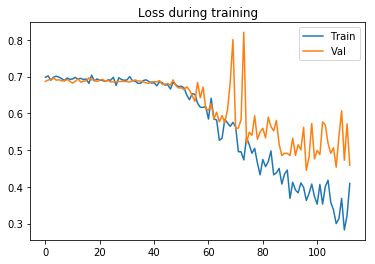

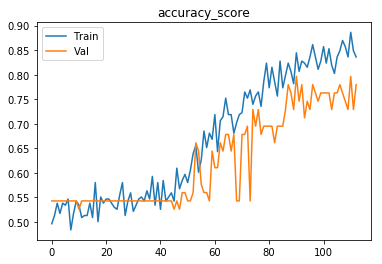

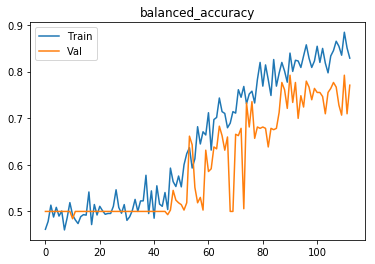

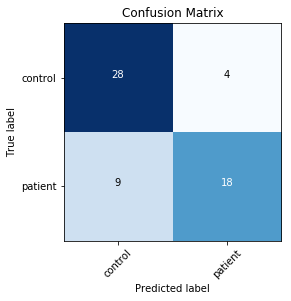

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 787785
[0,    10] loss: 0.67417
[0,    20] loss: 0.68980
[0,    30] loss: 0.69923
[0,    40] loss: 0.68687
[0,    50] loss: 0.70187
Time elapsed: 0h:0m:25s
train accuracy_score: 58.40 %
train balanced_accuracy: 56.05 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.728397
[1,    10] loss: 0.70917
[1,    20] loss: 0.69794
[1,    30] loss: 0.69866
[1,    40] loss: 0.70302
[1,    50] loss: 0.69511
Time elapsed: 0h:1m:3s
train accuracy_score: 53.78 %
train balanced_accuracy: 52.21 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.699344
[2,    10] loss: 0.68483
[2,    20] loss: 0.70336
[2,    30] loss: 0.70166
[2,    40] loss: 0.71500
[2,    50] loss: 0.59856
Time elapsed: 0h:1m:41s
train accuracy_score: 56.72 %
train balanced_accuracy: 55.84 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.680859


val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.688222
[28,    10] loss: 0.66473
[28,    20] loss: 0.66265
[28,    30] loss: 0.70979
[28,    40] loss: 0.67622
[28,    50] loss: 0.67360
Time elapsed: 0h:18m:7s
train accuracy_score: 58.40 %
train balanced_accuracy: 54.79 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.685908
[29,    10] loss: 0.70719
[29,    20] loss: 0.67889
[29,    30] loss: 0.64264
[29,    40] loss: 0.71894
[29,    50] loss: 0.66945
Time elapsed: 0h:18m:44s
train accuracy_score: 50.42 %
train balanced_accuracy: 49.13 %
val accuracy_score: 54.24 %
val balanced_accuracy: 52.03 %
Val loss: 0.685010
[30,    10] loss: 0.70737
[30,    20] loss: 0.68054
[30,    30] loss: 0.66712
[30,    40] loss: 0.67640
[30,    50] loss: 0.67226
Time elapsed: 0h:19m:21s
train accuracy_score: 52.94 %
train balanced_accuracy: 49.72 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.689347
[31,    10] loss: 0.66095
[31,    2

Time elapsed: 0h:35m:6s
train accuracy_score: 78.15 %
train balanced_accuracy: 77.88 %
val accuracy_score: 77.97 %
val balanced_accuracy: 79.11 %
Val loss: 0.531756
[56,    10] loss: 0.49944
[56,    20] loss: 0.58847
[56,    30] loss: 0.49664
[56,    40] loss: 0.34438
[56,    50] loss: 0.40139
Time elapsed: 0h:35m:44s
train accuracy_score: 78.99 %
train balanced_accuracy: 78.81 %
val accuracy_score: 62.71 %
val balanced_accuracy: 59.55 %
Val loss: 0.633081
[57,    10] loss: 0.64197
[57,    20] loss: 0.54134
[57,    30] loss: 0.47971
[57,    40] loss: 0.54473
[57,    50] loss: 0.41534
Time elapsed: 0h:36m:21s
train accuracy_score: 73.11 %
train balanced_accuracy: 72.72 %
val accuracy_score: 62.71 %
val balanced_accuracy: 60.13 %
Val loss: 0.638551
[58,    10] loss: 0.50365
[58,    20] loss: 0.44875
[58,    30] loss: 0.46483
[58,    40] loss: 0.41783
[58,    50] loss: 0.32746
Time elapsed: 0h:36m:59s
train accuracy_score: 78.99 %
train balanced_accuracy: 78.34 %
val accuracy_score: 71.19

[83,    30] loss: 0.33487
[83,    40] loss: 0.28567
[83,    50] loss: 0.31874
Time elapsed: 0h:52m:46s
train accuracy_score: 83.19 %
train balanced_accuracy: 82.89 %
val accuracy_score: 72.88 %
val balanced_accuracy: 72.97 %
Val loss: 0.658934
[84,    10] loss: 0.32104
[84,    20] loss: 0.24528
[84,    30] loss: 0.48174
[84,    40] loss: 0.41133
[84,    50] loss: 0.26190
Time elapsed: 0h:53m:24s
train accuracy_score: 84.45 %
train balanced_accuracy: 83.97 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.05 %
Val loss: 0.407538
[85,    10] loss: 0.28292
[85,    20] loss: 0.28151
[85,    30] loss: 0.36296
[85,    40] loss: 0.34908
[85,    50] loss: 0.32368
Time elapsed: 0h:54m:2s
train accuracy_score: 82.77 %
train balanced_accuracy: 82.51 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.49 %
Val loss: 0.459799
[86,    10] loss: 0.25314
[86,    20] loss: 0.31918
[86,    30] loss: 0.34168
[86,    40] loss: 0.23253
[86,    50] loss: 0.37197
Time elapsed: 0h:54m:40s
train accu

val accuracy_score: 83.05 %
val balanced_accuracy: 82.64 %
Val loss: 0.419699
Early stopping in epoch 111
Total time elapsed: 1h:10m:0s
Writing model to disk...
Best result during training: 0.86. Saving model..
Finished inner fold.


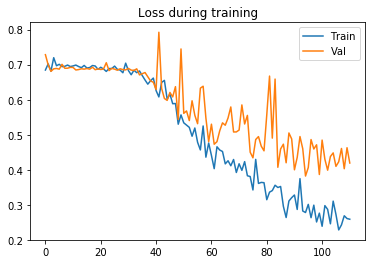

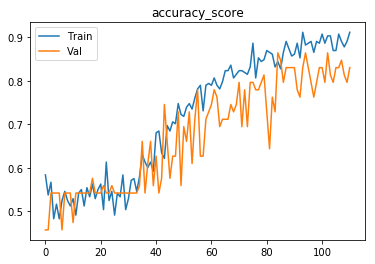

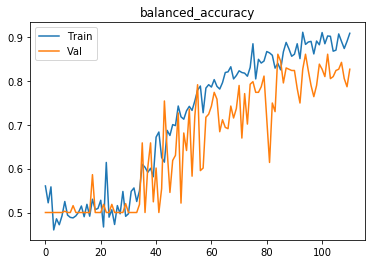

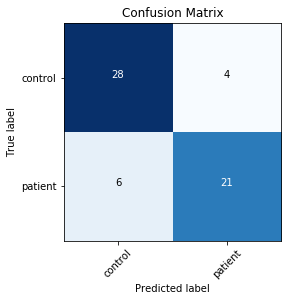

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 787785
[0,    10] loss: 0.70209
Time elapsed: 0h:0m:27s
train accuracy_score: 51.26 %
train balanced_accuracy: 52.64 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.684857
[1,    10] loss: 0.68426
Time elapsed: 0h:1m:6s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.08 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.684184
[2,    10] loss: 0.69199
Time elapsed: 0h:1m:46s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.10 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.687345
[3,    10] loss: 0.69753
Time elapsed: 0h:2m:26s
train accuracy_score: 49.16 %
train balanced_accuracy: 47.43 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.687852
[4,    10] loss: 0.68629
Time elapsed: 0h:3m:5s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.08 %

val accuracy_score: 52.54 %
val balanced_accuracy: 48.73 %
Val loss: 0.689183
[43,    10] loss: 0.68417
Time elapsed: 0h:28m:37s
train accuracy_score: 56.72 %
train balanced_accuracy: 53.80 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.686967
[44,    10] loss: 0.68237
Time elapsed: 0h:29m:15s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.08 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.687393
[45,    10] loss: 0.68706
Time elapsed: 0h:29m:54s
train accuracy_score: 55.88 %
train balanced_accuracy: 51.78 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.684363
[46,    10] loss: 0.67905
Time elapsed: 0h:30m:34s
train accuracy_score: 55.46 %
train balanced_accuracy: 51.40 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.678215
[47,    10] loss: 0.68401
Time elapsed: 0h:31m:14s
train accuracy_score: 52.94 %
train balanced_accuracy: 48.85 %
val accuracy_score: 54.24 %
val balanced

val accuracy_score: 59.32 %
val balanced_accuracy: 56.13 %
Val loss: 0.632851
[86,    10] loss: 0.58615
Time elapsed: 0h:56m:46s
train accuracy_score: 72.27 %
train balanced_accuracy: 72.42 %
val accuracy_score: 69.49 %
val balanced_accuracy: 70.14 %
Val loss: 0.659193
[87,    10] loss: 0.58596
Time elapsed: 0h:57m:25s
train accuracy_score: 65.55 %
train balanced_accuracy: 63.68 %
val accuracy_score: 67.80 %
val balanced_accuracy: 68.58 %
Val loss: 0.687446
[88,    10] loss: 0.64818
Time elapsed: 0h:58m:4s
train accuracy_score: 68.07 %
train balanced_accuracy: 67.87 %
val accuracy_score: 61.02 %
val balanced_accuracy: 58.56 %
Val loss: 0.626225
[89,    10] loss: 0.57577
Time elapsed: 0h:58m:44s
train accuracy_score: 71.01 %
train balanced_accuracy: 70.56 %
val accuracy_score: 61.02 %
val balanced_accuracy: 58.56 %
Val loss: 0.631014
[90,    10] loss: 0.55357
Time elapsed: 0h:59m:23s
train accuracy_score: 73.53 %
train balanced_accuracy: 72.48 %
val accuracy_score: 66.10 %
val balanced_

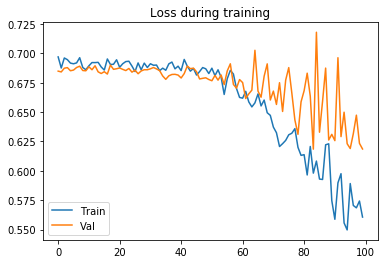

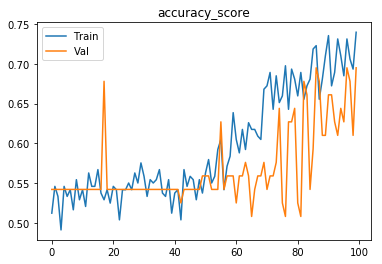

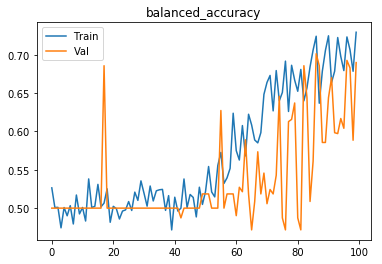

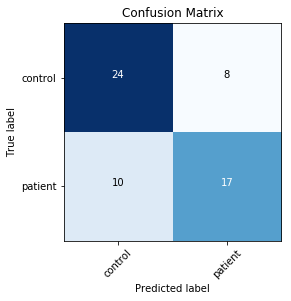

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 1303769
[0,    10] loss: 0.69876
[0,    20] loss: 0.72366
[0,    30] loss: 0.72374
Time elapsed: 0h:0m:25s
train accuracy_score: 52.94 %
train balanced_accuracy: 52.69 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.695438
[1,    10] loss: 0.71080
[1,    20] loss: 0.68078
[1,    30] loss: 0.71015
Time elapsed: 0h:1m:2s
train accuracy_score: 55.46 %
train balanced_accuracy: 52.57 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.692217
[2,    10] loss: 0.70443
[2,    20] loss: 0.69572
[2,    30] loss: 0.67701
Time elapsed: 0h:1m:40s
train accuracy_score: 51.68 %
train balanced_accuracy: 48.40 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.692050
[3,    10] loss: 0.70103
[3,    20] loss: 0.68277
[3,    30] loss: 0.71997
Time elapsed: 0h:2m:18s
train accuracy_score: 55.88 %
train balanced_accur

Time elapsed: 0h:21m:12s
train accuracy_score: 68.49 %
train balanced_accuracy: 68.02 %
val accuracy_score: 64.41 %
val balanced_accuracy: 64.58 %
Val loss: 0.695891
[34,    10] loss: 0.57639
[34,    20] loss: 0.56638
[34,    30] loss: 0.65837
Time elapsed: 0h:21m:51s
train accuracy_score: 66.81 %
train balanced_accuracy: 66.17 %
val accuracy_score: 62.71 %
val balanced_accuracy: 62.73 %
Val loss: 0.697291
[35,    10] loss: 0.54997
[35,    20] loss: 0.55811
[35,    30] loss: 0.65985
Time elapsed: 0h:22m:29s
train accuracy_score: 68.49 %
train balanced_accuracy: 67.94 %
val accuracy_score: 66.10 %
val balanced_accuracy: 64.12 %
Val loss: 0.702742
[36,    10] loss: 0.60778
[36,    20] loss: 0.57326
[36,    30] loss: 0.56690
Time elapsed: 0h:23m:7s
train accuracy_score: 68.91 %
train balanced_accuracy: 68.64 %
val accuracy_score: 67.80 %
val balanced_accuracy: 65.68 %
Val loss: 0.653358
[37,    10] loss: 0.62089
[37,    20] loss: 0.46706
[37,    30] loss: 0.52798
Time elapsed: 0h:23m:44s


[67,    10] loss: 0.22153
[67,    20] loss: 0.26724
[67,    30] loss: 0.39889
Time elapsed: 0h:42m:48s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.36 %
val accuracy_score: 84.75 %
val balanced_accuracy: 85.07 %
Val loss: 0.427269
[68,    10] loss: 0.18959
[68,    20] loss: 0.23621
[68,    30] loss: 0.38919
Time elapsed: 0h:43m:27s
train accuracy_score: 86.55 %
train balanced_accuracy: 86.44 %
val accuracy_score: 72.88 %
val balanced_accuracy: 70.37 %
Val loss: 0.643235
[69,    10] loss: 0.27539
[69,    20] loss: 0.36160
[69,    30] loss: 0.32798
Time elapsed: 0h:44m:5s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.13 %
val accuracy_score: 72.88 %
val balanced_accuracy: 70.95 %
Val loss: 0.620024
[70,    10] loss: 0.22672
[70,    20] loss: 0.21194
[70,    30] loss: 0.32424
Time elapsed: 0h:44m:43s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.44 %
val accuracy_score: 76.27 %
val balanced_accuracy: 75.23 %
Val loss: 0.536775
[71,    10] loss: 0.26616

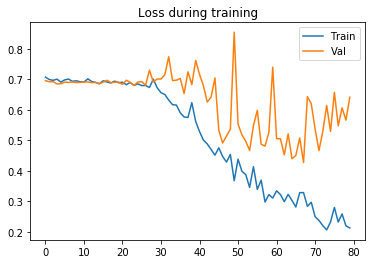

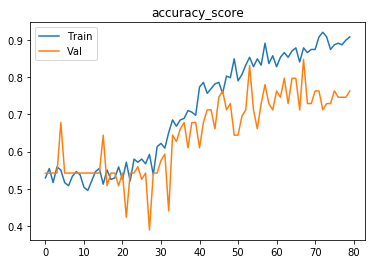

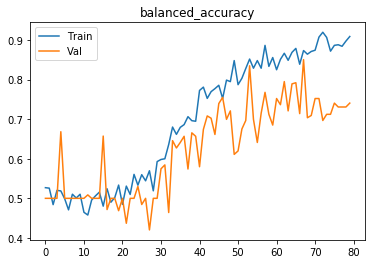

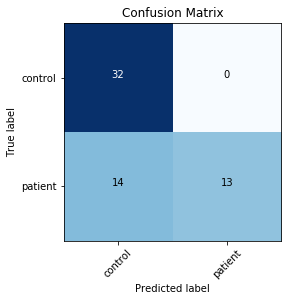

Finished outer fold.
{'final_acc': 0.8263888888888888, 'best_acc': 0.8605324074074074, 'final_iter': 111, 'best_iter': 103, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 2}
###### Starting outer fold 5
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 1303769
[0,    10] loss: 0.64651
[0,    20] loss: 0.71477
[0,    30] loss: 0.72148
[0,    40] loss: 0.67878
[0,    50] loss: 0.74244
Time elapsed: 0h:0m:25s
train accuracy_score: 54.20 %
train balanced_accuracy: 49.12 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.717387
[1,    10] loss: 0.77288
[1,    20] loss: 0.68788
[1,    30] loss: 0.65540
[1,    40] loss: 0.71823
[1,    50] loss: 0.67064
Time elapsed: 0h:1m:2s
train accuracy_score: 58.40 %
train balanced_accuracy: 49.45 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.694711
[2,    10]

val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.692980
[27,    10] loss: 0.63168
[27,    20] loss: 0.68914
[27,    30] loss: 0.69890
[27,    40] loss: 0.67140
[27,    50] loss: 0.68735
Time elapsed: 0h:17m:21s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.694782
[28,    10] loss: 0.68488
[28,    20] loss: 0.71052
[28,    30] loss: 0.66655
[28,    40] loss: 0.67265
[28,    50] loss: 0.65660
Time elapsed: 0h:17m:59s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.694275
[29,    10] loss: 0.70099
[29,    20] loss: 0.68291
[29,    30] loss: 0.68223
[29,    40] loss: 0.63115
[29,    50] loss: 0.65846
Time elapsed: 0h:18m:38s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.16 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.706538
[30,    10] loss: 0.66698
[30,    

Time elapsed: 0h:34m:47s
train accuracy_score: 74.37 %
train balanced_accuracy: 72.10 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.42 %
Val loss: 0.496111
[55,    10] loss: 0.60553
[55,    20] loss: 0.50294
[55,    30] loss: 0.53261
[55,    40] loss: 0.43844
[55,    50] loss: 0.47108
Time elapsed: 0h:35m:24s
train accuracy_score: 75.21 %
train balanced_accuracy: 73.13 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.00 %
Val loss: 0.481205
[56,    10] loss: 0.46010
[56,    20] loss: 0.45890
[56,    30] loss: 0.64673
[56,    40] loss: 0.63976
[56,    50] loss: 0.46491
Time elapsed: 0h:36m:3s
train accuracy_score: 73.53 %
train balanced_accuracy: 71.23 %
val accuracy_score: 76.27 %
val balanced_accuracy: 75.00 %
Val loss: 0.507317
[57,    10] loss: 0.52585
[57,    20] loss: 0.44036
[57,    30] loss: 0.60554
[57,    40] loss: 0.43266
[57,    50] loss: 0.48575
Time elapsed: 0h:36m:40s
train accuracy_score: 72.69 %
train balanced_accuracy: 70.52 %
val accuracy_score: 71.19

[82,    30] loss: 0.43058
[82,    40] loss: 0.51730
[82,    50] loss: 0.42279
Time elapsed: 0h:52m:36s
train accuracy_score: 85.29 %
train balanced_accuracy: 84.21 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.23 %
Val loss: 0.334907
[83,    10] loss: 0.31929
[83,    20] loss: 0.32186
[83,    30] loss: 0.54056
[83,    40] loss: 0.31996
[83,    50] loss: 0.32582
Time elapsed: 0h:53m:15s
train accuracy_score: 84.45 %
train balanced_accuracy: 83.18 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.45 %
Val loss: 0.343546
[84,    10] loss: 0.16516
[84,    20] loss: 0.25412
[84,    30] loss: 0.37362
[84,    40] loss: 0.26651
[84,    50] loss: 0.29190
Time elapsed: 0h:53m:53s
train accuracy_score: 89.08 %
train balanced_accuracy: 88.85 %
val accuracy_score: 81.36 %
val balanced_accuracy: 80.70 %
Val loss: 0.451454
[85,    10] loss: 0.27023
[85,    20] loss: 0.49251
[85,    30] loss: 0.24751
[85,    40] loss: 0.43241
[85,    50] loss: 0.24612
Time elapsed: 0h:54m:31s
train acc

[110,    10] loss: 0.15660
[110,    20] loss: 0.33485
[110,    30] loss: 0.34346
[110,    40] loss: 0.24137
[110,    50] loss: 0.24494
Time elapsed: 1h:10m:37s
train accuracy_score: 89.08 %
train balanced_accuracy: 88.85 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.45 %
Val loss: 0.373514
[111,    10] loss: 0.11799
[111,    20] loss: 0.36102
[111,    30] loss: 0.14723
[111,    40] loss: 0.23515
[111,    50] loss: 0.23212
Time elapsed: 1h:11m:16s
train accuracy_score: 92.02 %
train balanced_accuracy: 91.33 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.79 %
Val loss: 0.365169
[112,    10] loss: 0.33467
[112,    20] loss: 0.36853
[112,    30] loss: 0.13984
[112,    40] loss: 0.26007
[112,    50] loss: 0.20428
Time elapsed: 1h:11m:55s
train accuracy_score: 88.66 %
train balanced_accuracy: 88.50 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.92 %
Val loss: 0.518645
[113,    10] loss: 0.17270
[113,    20] loss: 0.22267
[113,    30] loss: 0.11065
[113,    40] los

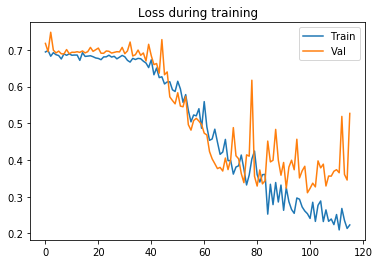

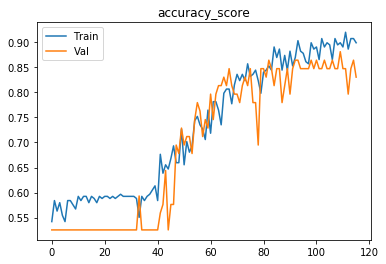

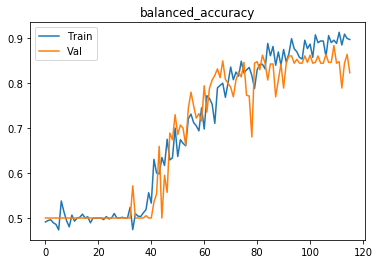

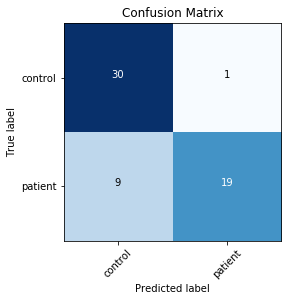

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 1303769
[0,    10] loss: 0.69532
[0,    20] loss: 0.67724
[0,    30] loss: 0.66950
Time elapsed: 0h:0m:26s
train accuracy_score: 57.98 %
train balanced_accuracy: 49.42 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.727477
[1,    10] loss: 0.69656
[1,    20] loss: 0.66792
[1,    30] loss: 0.69778
Time elapsed: 0h:1m:5s
train accuracy_score: 57.14 %
train balanced_accuracy: 48.87 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.709484
[2,    10] loss: 0.71946
[2,    20] loss: 0.66560
[2,    30] loss: 0.71214
Time elapsed: 0h:1m:43s
train accuracy_score: 57.98 %
train balanced_accuracy: 49.42 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.704812
[3,    10] loss: 0.70092
[3,    20] loss: 0.69862
[3,    30] loss: 0.66295
Time elapsed: 0h:2m:22s
train accuracy_score: 58.82 %
train balanced_accura

Time elapsed: 0h:21m:53s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.16 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.700633
[34,    10] loss: 0.65576
[34,    20] loss: 0.66822
[34,    30] loss: 0.65319
Time elapsed: 0h:22m:32s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.697522
[35,    10] loss: 0.69186
[35,    20] loss: 0.66568
[35,    30] loss: 0.67568
Time elapsed: 0h:23m:12s
train accuracy_score: 57.56 %
train balanced_accuracy: 48.58 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.692510
[36,    10] loss: 0.68550
[36,    20] loss: 0.68603
[36,    30] loss: 0.67356
Time elapsed: 0h:23m:50s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.16 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.689327
[37,    10] loss: 0.70696
[37,    20] loss: 0.65905
[37,    30] loss: 0.67686
Time elapsed: 0h:24m:28s

[67,    10] loss: 0.57920
[67,    20] loss: 0.52141
[67,    30] loss: 0.59380
Time elapsed: 0h:44m:9s
train accuracy_score: 73.11 %
train balanced_accuracy: 72.32 %
val accuracy_score: 64.41 %
val balanced_accuracy: 62.50 %
Val loss: 0.632863
[68,    10] loss: 0.58280
[68,    20] loss: 0.56510
[68,    30] loss: 0.51758
Time elapsed: 0h:44m:48s
train accuracy_score: 70.59 %
train balanced_accuracy: 68.10 %
val accuracy_score: 69.49 %
val balanced_accuracy: 68.38 %
Val loss: 0.551191
[69,    10] loss: 0.54778
[69,    20] loss: 0.55453
[69,    30] loss: 0.53756
Time elapsed: 0h:45m:28s
train accuracy_score: 74.79 %
train balanced_accuracy: 71.32 %
val accuracy_score: 72.88 %
val balanced_accuracy: 72.81 %
Val loss: 0.543561
[70,    10] loss: 0.53539
[70,    20] loss: 0.54292
[70,    30] loss: 0.58400
Time elapsed: 0h:46m:7s
train accuracy_score: 70.17 %
train balanced_accuracy: 66.94 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.17 %
Val loss: 0.515039
[71,    10] loss: 0.52078


val accuracy_score: 77.97 %
val balanced_accuracy: 77.82 %
Val loss: 0.456702
[101,    10] loss: 0.47289
[101,    20] loss: 0.41490
[101,    30] loss: 0.53121
Time elapsed: 1h:6m:26s
train accuracy_score: 77.73 %
train balanced_accuracy: 76.38 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.48 %
Val loss: 0.485167
[102,    10] loss: 0.46176
[102,    20] loss: 0.43314
[102,    30] loss: 0.46726
Time elapsed: 1h:7m:6s
train accuracy_score: 78.99 %
train balanced_accuracy: 77.28 %
val accuracy_score: 76.27 %
val balanced_accuracy: 75.69 %
Val loss: 0.491300
[103,    10] loss: 0.37740
[103,    20] loss: 0.47700
[103,    30] loss: 0.38853
Time elapsed: 1h:7m:45s
train accuracy_score: 80.25 %
train balanced_accuracy: 78.83 %
val accuracy_score: 76.27 %
val balanced_accuracy: 75.52 %
Val loss: 0.520305
[104,    10] loss: 0.57043
[104,    20] loss: 0.45942
[104,    30] loss: 0.43859
Time elapsed: 1h:8m:25s
train accuracy_score: 78.99 %
train balanced_accuracy: 77.44 %
val accuracy_scor

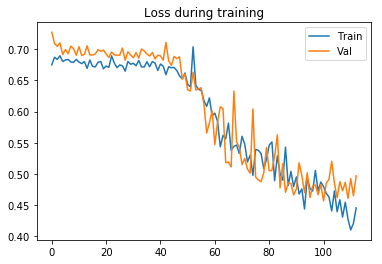

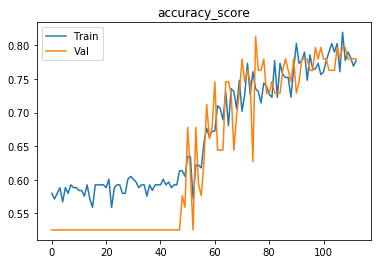

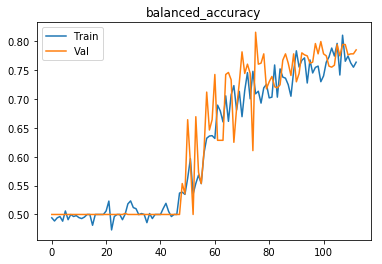

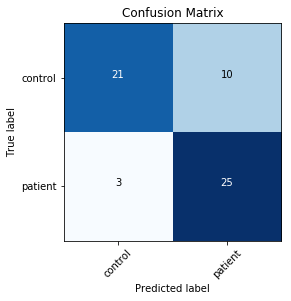

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 787785
[0,    10] loss: 0.69264
[0,    20] loss: 0.67668
[0,    30] loss: 0.67376
Time elapsed: 0h:0m:26s
train accuracy_score: 57.14 %
train balanced_accuracy: 49.19 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.699022
[1,    10] loss: 0.66410
[1,    20] loss: 0.71841
[1,    30] loss: 0.67248
Time elapsed: 0h:1m:6s
train accuracy_score: 57.14 %
train balanced_accuracy: 48.39 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.692506
[2,    10] loss: 0.70204
[2,    20] loss: 0.66533
[2,    30] loss: 0.65591
Time elapsed: 0h:1m:45s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.710063
[3,    10] loss: 0.67692
[3,    20] loss: 0.67249
[3,    30] loss: 0.69280
Time elapsed: 0h:2m:25s
train accuracy_score: 57.14 %
train balanced_accurac

Time elapsed: 0h:22m:14s
train accuracy_score: 59.66 %
train balanced_accuracy: 51.16 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.684676
[34,    10] loss: 0.68423
[34,    20] loss: 0.65917
[34,    30] loss: 0.64158
Time elapsed: 0h:22m:54s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.48 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.695460
[35,    10] loss: 0.68499
[35,    20] loss: 0.68750
[35,    30] loss: 0.65604
Time elapsed: 0h:23m:34s
train accuracy_score: 59.66 %
train balanced_accuracy: 50.52 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.692293
[36,    10] loss: 0.66619
[36,    20] loss: 0.68750
[36,    30] loss: 0.69812
Time elapsed: 0h:24m:13s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.682072
[37,    10] loss: 0.63114
[37,    20] loss: 0.70823
[37,    30] loss: 0.67173
Time elapsed: 0h:24m:53s

[67,    10] loss: 0.53678
[67,    20] loss: 0.53024
[67,    30] loss: 0.58642
Time elapsed: 0h:44m:55s
train accuracy_score: 76.05 %
train balanced_accuracy: 72.87 %
val accuracy_score: 72.88 %
val balanced_accuracy: 71.95 %
Val loss: 0.536065
[68,    10] loss: 0.61590
[68,    20] loss: 0.55263
[68,    30] loss: 0.49740
Time elapsed: 0h:45m:34s
train accuracy_score: 71.85 %
train balanced_accuracy: 68.68 %
val accuracy_score: 72.88 %
val balanced_accuracy: 71.95 %
Val loss: 0.539283
[69,    10] loss: 0.51357
[69,    20] loss: 0.57600
[69,    30] loss: 0.58932
Time elapsed: 0h:46m:14s
train accuracy_score: 72.69 %
train balanced_accuracy: 70.68 %
val accuracy_score: 76.27 %
val balanced_accuracy: 75.69 %
Val loss: 0.522889
[70,    10] loss: 0.54212
[70,    20] loss: 0.54473
[70,    30] loss: 0.48590
Time elapsed: 0h:46m:53s
train accuracy_score: 75.21 %
train balanced_accuracy: 72.48 %
val accuracy_score: 76.27 %
val balanced_accuracy: 75.86 %
Val loss: 0.503301
[71,    10] loss: 0.5641

val accuracy_score: 84.75 %
val balanced_accuracy: 84.79 %
Val loss: 0.355319
[101,    10] loss: 0.36377
[101,    20] loss: 0.44807
[101,    30] loss: 0.40104
Time elapsed: 1h:7m:25s
train accuracy_score: 80.67 %
train balanced_accuracy: 79.99 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.32 %
Val loss: 0.364231
[102,    10] loss: 0.45375
[102,    20] loss: 0.36419
[102,    30] loss: 0.39641
Time elapsed: 1h:8m:4s
train accuracy_score: 82.77 %
train balanced_accuracy: 80.64 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.75 %
Val loss: 0.385898
[103,    10] loss: 0.31818
[103,    20] loss: 0.39497
[103,    30] loss: 0.32356
Time elapsed: 1h:8m:44s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.50 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.23 %
Val loss: 0.329818
[104,    10] loss: 0.38754
[104,    20] loss: 0.31560
[104,    30] loss: 0.39310
Time elapsed: 1h:9m:24s
train accuracy_score: 83.19 %
train balanced_accuracy: 81.96 %
val accuracy_scor

[134,    10] loss: 0.28897
[134,    20] loss: 0.28595
[134,    30] loss: 0.39184
Time elapsed: 1h:29m:20s
train accuracy_score: 82.77 %
train balanced_accuracy: 82.40 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.98 %
Val loss: 0.354333
[135,    10] loss: 0.44460
[135,    20] loss: 0.31213
[135,    30] loss: 0.40445
Time elapsed: 1h:30m:0s
train accuracy_score: 82.77 %
train balanced_accuracy: 81.76 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.66 %
Val loss: 0.346712
[136,    10] loss: 0.42524
[136,    20] loss: 0.33836
[136,    30] loss: 0.47356
Time elapsed: 1h:30m:41s
train accuracy_score: 83.19 %
train balanced_accuracy: 82.76 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.45 %
Val loss: 0.289815
[137,    10] loss: 0.33971
[137,    20] loss: 0.28759
[137,    30] loss: 0.33105
Time elapsed: 1h:31m:20s
train accuracy_score: 85.29 %
train balanced_accuracy: 83.57 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.19 %
Val loss: 0.262636
[138,    10] 

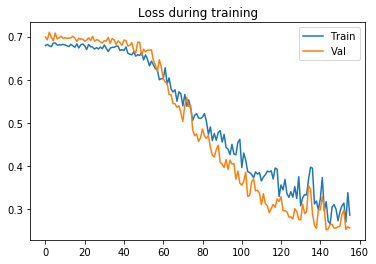

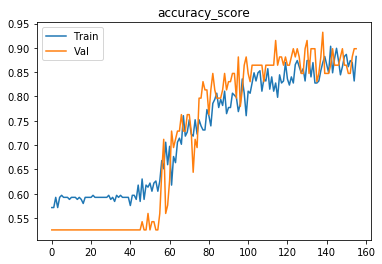

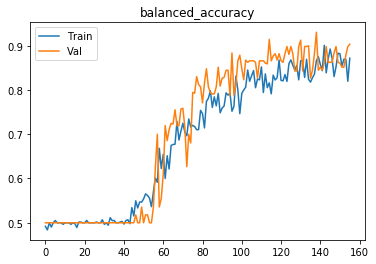

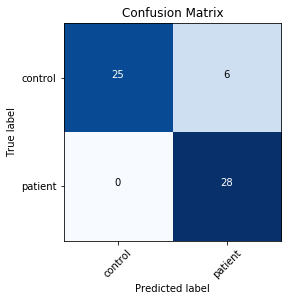

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 787785
[0,    10] loss: 0.67358
[0,    20] loss: 0.70985
[0,    30] loss: 0.67798
[0,    40] loss: 0.67397
[0,    50] loss: 0.72093
Time elapsed: 0h:0m:25s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.691695
[1,    10] loss: 0.68887
[1,    20] loss: 0.67555
[1,    30] loss: 0.69505
[1,    40] loss: 0.67867
[1,    50] loss: 0.63892
Time elapsed: 0h:1m:4s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.699297
[2,    10] loss: 0.73670
[2,    20] loss: 0.68860
[2,    30] loss: 0.68785
[2,    40] loss: 0.68585
[2,    50] loss: 0.68836
Time elapsed: 0h:1m:44s
train accuracy_score: 57.14 %
train balanced_accuracy: 48.39 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.693373
[

val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.693897
[28,    10] loss: 0.65767
[28,    20] loss: 0.60290
[28,    30] loss: 0.68351
[28,    40] loss: 0.71464
[28,    50] loss: 0.66142
Time elapsed: 0h:18m:53s
train accuracy_score: 59.66 %
train balanced_accuracy: 51.64 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.687223
[29,    10] loss: 0.64517
[29,    20] loss: 0.73164
[29,    30] loss: 0.60462
[29,    40] loss: 0.69698
[29,    50] loss: 0.70961
Time elapsed: 0h:19m:33s
train accuracy_score: 59.66 %
train balanced_accuracy: 51.16 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.686256
[30,    10] loss: 0.66895
[30,    20] loss: 0.67671
[30,    30] loss: 0.66272
[30,    40] loss: 0.72670
[30,    50] loss: 0.67315
Time elapsed: 0h:20m:13s
train accuracy_score: 58.40 %
train balanced_accuracy: 49.45 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.692080
[31,    10] loss: 0.67489
[31,    

Time elapsed: 0h:36m:46s
train accuracy_score: 60.50 %
train balanced_accuracy: 53.15 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.667687
[56,    10] loss: 0.61210
[56,    20] loss: 0.67400
[56,    30] loss: 0.72353
[56,    40] loss: 0.70106
[56,    50] loss: 0.62584
Time elapsed: 0h:37m:26s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.16 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.667490
[57,    10] loss: 0.66315
[57,    20] loss: 0.64635
[57,    30] loss: 0.66711
[57,    40] loss: 0.66602
[57,    50] loss: 0.64064
Time elapsed: 0h:38m:5s
train accuracy_score: 61.76 %
train balanced_accuracy: 54.06 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.677628
[58,    10] loss: 0.67877
[58,    20] loss: 0.63447
[58,    30] loss: 0.68253
[58,    40] loss: 0.65228
[58,    50] loss: 0.64430
Time elapsed: 0h:38m:45s
train accuracy_score: 60.08 %
train balanced_accuracy: 51.35 %
val accuracy_score: 54.24

[83,    30] loss: 0.54452
[83,    40] loss: 0.45945
[83,    50] loss: 0.50108
Time elapsed: 0h:55m:21s
train accuracy_score: 73.95 %
train balanced_accuracy: 71.10 %
val accuracy_score: 71.19 %
val balanced_accuracy: 70.51 %
Val loss: 0.471136
[84,    10] loss: 0.45526
[84,    20] loss: 0.48656
[84,    30] loss: 0.57505
[84,    40] loss: 0.52193
[84,    50] loss: 0.55254
Time elapsed: 0h:56m:0s
train accuracy_score: 74.37 %
train balanced_accuracy: 73.86 %
val accuracy_score: 77.97 %
val balanced_accuracy: 76.96 %
Val loss: 0.492656
[85,    10] loss: 0.46208
[85,    20] loss: 0.38933
[85,    30] loss: 0.47636
[85,    40] loss: 0.52883
[85,    50] loss: 0.56804
Time elapsed: 0h:56m:41s
train accuracy_score: 73.95 %
train balanced_accuracy: 71.26 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.25 %
Val loss: 0.453716
[86,    10] loss: 0.56307
[86,    20] loss: 0.49783
[86,    30] loss: 0.38036
[86,    40] loss: 0.52849
[86,    50] loss: 0.44717
Time elapsed: 0h:57m:20s
train accu

val accuracy_score: 76.27 %
val balanced_accuracy: 75.52 %
Val loss: 0.388405
[111,    10] loss: 0.43042
[111,    20] loss: 0.39175
[111,    30] loss: 0.48976
[111,    40] loss: 0.48061
[111,    50] loss: 0.50149
Time elapsed: 1h:13m:55s
train accuracy_score: 77.73 %
train balanced_accuracy: 76.38 %
val accuracy_score: 76.27 %
val balanced_accuracy: 75.69 %
Val loss: 0.396096
[112,    10] loss: 0.48501
[112,    20] loss: 0.39208
[112,    30] loss: 0.34123
[112,    40] loss: 0.41114
[112,    50] loss: 0.43825
Time elapsed: 1h:14m:35s
train accuracy_score: 80.67 %
train balanced_accuracy: 79.83 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.48 %
Val loss: 0.388620
[113,    10] loss: 0.29999
[113,    20] loss: 0.39396
[113,    30] loss: 0.51321
[113,    40] loss: 0.47616
[113,    50] loss: 0.43821
Time elapsed: 1h:15m:14s
train accuracy_score: 81.93 %
train balanced_accuracy: 81.05 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.97 %
Val loss: 0.390432
[114,    10] loss: 

[138,    10] loss: 0.42584
[138,    20] loss: 0.32007
[138,    30] loss: 0.29736
[138,    40] loss: 0.23955
[138,    50] loss: 0.22595
Time elapsed: 1h:31m:46s
train accuracy_score: 86.55 %
train balanced_accuracy: 85.92 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.09 %
Val loss: 0.312534
[139,    10] loss: 0.37476
[139,    20] loss: 0.29626
[139,    30] loss: 0.37399
[139,    40] loss: 0.36503
[139,    50] loss: 0.35170
Time elapsed: 1h:32m:24s
train accuracy_score: 85.71 %
train balanced_accuracy: 85.21 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.13 %
Val loss: 0.348866
[140,    10] loss: 0.29558
[140,    20] loss: 0.33209
[140,    30] loss: 0.23896
[140,    40] loss: 0.34132
[140,    50] loss: 0.36378
Time elapsed: 1h:33m:3s
train accuracy_score: 88.24 %
train balanced_accuracy: 87.50 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.26 %
Val loss: 0.297976
[141,    10] loss: 0.26578
[141,    20] loss: 0.29850
[141,    30] loss: 0.27734
[141,    40] loss

[165,    40] loss: 0.29635
[165,    50] loss: 0.25714
Time elapsed: 1h:49m:30s
train accuracy_score: 88.24 %
train balanced_accuracy: 87.50 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.66 %
Val loss: 0.268067
[166,    10] loss: 0.31010
[166,    20] loss: 0.26349
[166,    30] loss: 0.27331
[166,    40] loss: 0.18579
[166,    50] loss: 0.22963
Time elapsed: 1h:50m:9s
train accuracy_score: 89.08 %
train balanced_accuracy: 88.37 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.41 %
Val loss: 0.255955
[167,    10] loss: 0.28637
[167,    20] loss: 0.21606
[167,    30] loss: 0.19725
[167,    40] loss: 0.28026
[167,    50] loss: 0.19978
Time elapsed: 1h:50m:49s
train accuracy_score: 92.02 %
train balanced_accuracy: 91.65 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.66 %
Val loss: 0.267359
[168,    10] loss: 0.27457
[168,    20] loss: 0.26082
[168,    30] loss: 0.24434
[168,    40] loss: 0.16784
[168,    50] loss: 0.26454
Time elapsed: 1h:51m:29s
train accuracy_scor

val accuracy_score: 91.53 %
val balanced_accuracy: 91.94 %
Val loss: 0.313366
[193,    10] loss: 0.22380
[193,    20] loss: 0.28373
[193,    30] loss: 0.23100
[193,    40] loss: 0.18281
[193,    50] loss: 0.25681
Time elapsed: 2h:7m:56s
train accuracy_score: 90.34 %
train balanced_accuracy: 89.75 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.98 %
Val loss: 0.228638
[194,    10] loss: 0.32578
[194,    20] loss: 0.28974
[194,    30] loss: 0.20030
[194,    40] loss: 0.22776
[194,    50] loss: 0.25607
Time elapsed: 2h:8m:36s
train accuracy_score: 89.08 %
train balanced_accuracy: 88.69 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.58 %
Val loss: 0.247208
[195,    10] loss: 0.16384
[195,    20] loss: 0.29656
[195,    30] loss: 0.24190
[195,    40] loss: 0.24750
[195,    50] loss: 0.21694
Time elapsed: 2h:9m:16s
train accuracy_score: 89.50 %
train balanced_accuracy: 89.20 %
val accuracy_score: 89.83 %
val balanced_accuracy: 90.15 %
Val loss: 0.291061
[196,    10] loss: 0.2

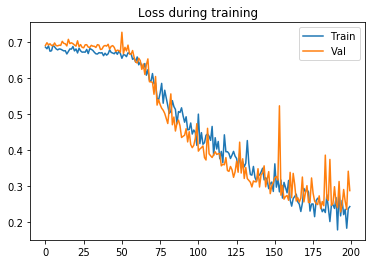

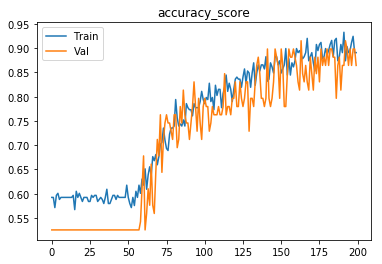

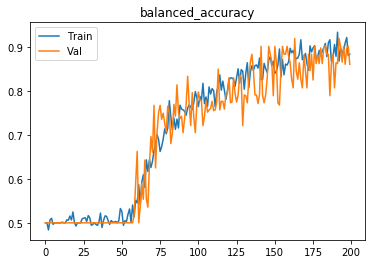

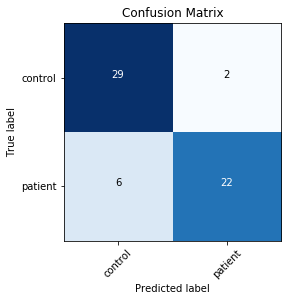

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 1303769
[0,    10] loss: 0.69574
[0,    20] loss: 0.67157
[0,    30] loss: 0.68196
Time elapsed: 0h:0m:26s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.77 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.697741
[1,    10] loss: 0.65762
[1,    20] loss: 0.71989
[1,    30] loss: 0.67988
Time elapsed: 0h:1m:6s
train accuracy_score: 56.30 %
train balanced_accuracy: 47.68 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.699467
[2,    10] loss: 0.70473
[2,    20] loss: 0.68519
[2,    30] loss: 0.69142
Time elapsed: 0h:1m:46s
train accuracy_score: 59.66 %
train balanced_accuracy: 53.73 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.721604
[3,    10] loss: 0.69566
[3,    20] loss: 0.70701
[3,    30] loss: 0.70264
Time elapsed: 0h:2m:27s
train accuracy_score: 59.24 %
train balanced_accura

Time elapsed: 0h:22m:28s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.693385
[34,    10] loss: 0.68238
[34,    20] loss: 0.67420
[34,    30] loss: 0.66069
Time elapsed: 0h:23m:8s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.700732
[35,    10] loss: 0.66182
[35,    20] loss: 0.64533
[35,    30] loss: 0.68620
Time elapsed: 0h:23m:48s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.32 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.683003
[36,    10] loss: 0.69136
[36,    20] loss: 0.67301
[36,    30] loss: 0.67499
Time elapsed: 0h:24m:29s
train accuracy_score: 56.72 %
train balanced_accuracy: 48.03 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.688339
[37,    10] loss: 0.69237
[37,    20] loss: 0.66458
[37,    30] loss: 0.67822
Time elapsed: 0h:25m:9s
t

[67,    10] loss: 0.62722
[67,    20] loss: 0.67731
[67,    30] loss: 0.62289
Time elapsed: 0h:45m:12s
train accuracy_score: 61.76 %
train balanced_accuracy: 57.27 %
val accuracy_score: 64.41 %
val balanced_accuracy: 62.85 %
Val loss: 0.596784
[68,    10] loss: 0.60651
[68,    20] loss: 0.64392
[68,    30] loss: 0.61696
Time elapsed: 0h:45m:51s
train accuracy_score: 66.39 %
train balanced_accuracy: 63.11 %
val accuracy_score: 59.32 %
val balanced_accuracy: 57.49 %
Val loss: 0.597412
[69,    10] loss: 0.60050
[69,    20] loss: 0.58714
[69,    30] loss: 0.65075
Time elapsed: 0h:46m:32s
train accuracy_score: 69.33 %
train balanced_accuracy: 65.59 %
val accuracy_score: 66.10 %
val balanced_accuracy: 64.46 %
Val loss: 0.593642
[70,    10] loss: 0.57665
[70,    20] loss: 0.66871
[70,    30] loss: 0.55031
Time elapsed: 0h:47m:12s
train accuracy_score: 66.39 %
train balanced_accuracy: 62.30 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.26 %
Val loss: 0.566860
[71,    10] loss: 0.5770

val accuracy_score: 77.97 %
val balanced_accuracy: 76.79 %
Val loss: 0.426968
[101,    10] loss: 0.38345
[101,    20] loss: 0.47545
[101,    30] loss: 0.57476
Time elapsed: 1h:7m:51s
train accuracy_score: 77.31 %
train balanced_accuracy: 75.70 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.79 %
Val loss: 0.341781
[102,    10] loss: 0.44489
[102,    20] loss: 0.37599
[102,    30] loss: 0.37645
Time elapsed: 1h:8m:31s
train accuracy_score: 82.35 %
train balanced_accuracy: 81.09 %
val accuracy_score: 77.97 %
val balanced_accuracy: 76.79 %
Val loss: 0.429799
[103,    10] loss: 0.36578
[103,    20] loss: 0.46401
[103,    30] loss: 0.51646
Time elapsed: 1h:9m:11s
train accuracy_score: 80.25 %
train balanced_accuracy: 78.67 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.97 %
Val loss: 0.351084
[104,    10] loss: 0.42187
[104,    20] loss: 0.42453
[104,    30] loss: 0.39494
Time elapsed: 1h:9m:51s
train accuracy_score: 79.83 %
train balanced_accuracy: 77.83 %
val accuracy_sco

[134,    10] loss: 0.33508
[134,    20] loss: 0.26677
[134,    30] loss: 0.36083
Time elapsed: 1h:29m:49s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.15 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.45 %
Val loss: 0.279467
[135,    10] loss: 0.24096
[135,    20] loss: 0.21728
[135,    30] loss: 0.52359
Time elapsed: 1h:30m:29s
train accuracy_score: 85.71 %
train balanced_accuracy: 84.89 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.27 %
Val loss: 0.310895
[136,    10] loss: 0.26679
[136,    20] loss: 0.26352
[136,    30] loss: 0.33288
Time elapsed: 1h:31m:8s
train accuracy_score: 89.50 %
train balanced_accuracy: 88.72 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.19 %
Val loss: 0.246976
[137,    10] loss: 0.25372
[137,    20] loss: 0.24432
[137,    30] loss: 0.27627
Time elapsed: 1h:31m:48s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.30 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.23 %
Val loss: 0.267471
[138,    10] 

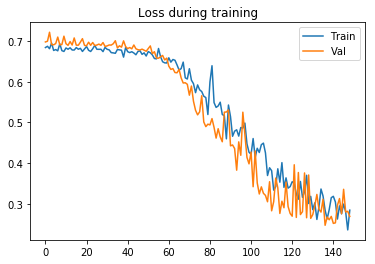

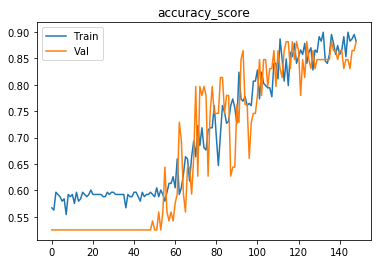

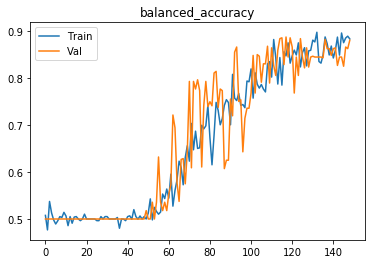

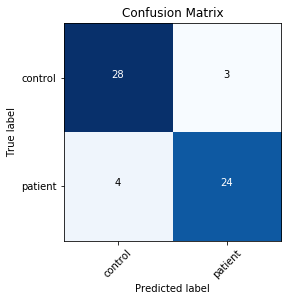

Finished outer fold.
{'final_acc': 0.9032258064516129, 'best_acc': 0.9302995391705069, 'final_iter': 156, 'best_iter': 139, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 2}
###### Starting outer fold 6
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 1303769
[0,    10] loss: 0.69942
[0,    20] loss: 0.67221
[0,    30] loss: 0.69090
Time elapsed: 0h:0m:26s
train accuracy_score: 50.84 %
train balanced_accuracy: 50.46 %
val accuracy_score: 55.93 %
val balanced_accuracy: 55.29 %
Val loss: 0.692176
[1,    10] loss: 0.68435
[1,    20] loss: 0.73946
[1,    30] loss: 0.69112
Time elapsed: 0h:1m:6s
train accuracy_score: 47.90 %
train balanced_accuracy: 45.10 %
val accuracy_score: 50.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.693362
[2,    10] loss: 0.69570
[2,    20] loss: 0.66698
[2,    30] loss: 0.72502
Time elapsed: 0h:1m:46s
train accura

[32,    30] loss: 0.69715
Time elapsed: 0h:21m:43s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.08 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694575
[33,    10] loss: 0.70246
[33,    20] loss: 0.70395
[33,    30] loss: 0.69268
Time elapsed: 0h:22m:22s
train accuracy_score: 50.00 %
train balanced_accuracy: 49.37 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.698299
[34,    10] loss: 0.69229
[34,    20] loss: 0.69392
[34,    30] loss: 0.68956
Time elapsed: 0h:23m:2s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.00 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692676
[35,    10] loss: 0.70024
[35,    20] loss: 0.65916
[35,    30] loss: 0.68875
Time elapsed: 0h:23m:42s
train accuracy_score: 55.04 %
train balanced_accuracy: 50.62 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.709208
[36,    10] loss: 0.71204
[36,    20] loss: 0.68919
[36,    30] loss: 0.68207

[66,    10] loss: 0.62426
[66,    20] loss: 0.46477
[66,    30] loss: 0.58415
Time elapsed: 0h:44m:26s
train accuracy_score: 73.53 %
train balanced_accuracy: 73.11 %
val accuracy_score: 76.27 %
val balanced_accuracy: 76.44 %
Val loss: 0.541737
[67,    10] loss: 0.54768
[67,    20] loss: 0.48495
[67,    30] loss: 0.42240
Time elapsed: 0h:45m:6s
train accuracy_score: 79.83 %
train balanced_accuracy: 78.87 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.25 %
Val loss: 0.554373
[68,    10] loss: 0.50393
[68,    20] loss: 0.50463
[68,    30] loss: 0.49257
Time elapsed: 0h:45m:45s
train accuracy_score: 76.47 %
train balanced_accuracy: 76.27 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.71 %
Val loss: 0.423452
[69,    10] loss: 0.36484
[69,    20] loss: 0.51821
[69,    30] loss: 0.56015
Time elapsed: 0h:46m:26s
train accuracy_score: 77.73 %
train balanced_accuracy: 77.50 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.99 %
Val loss: 0.479423
[70,    10] loss: 0.51322

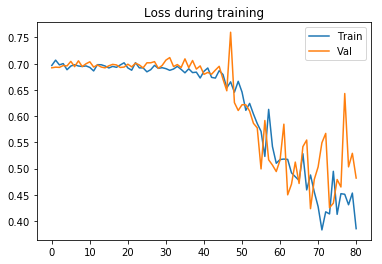

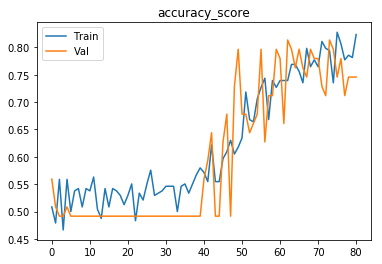

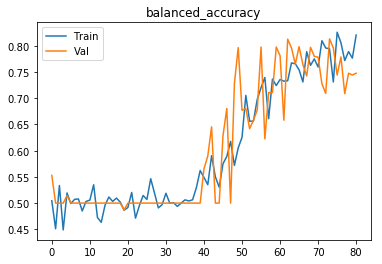

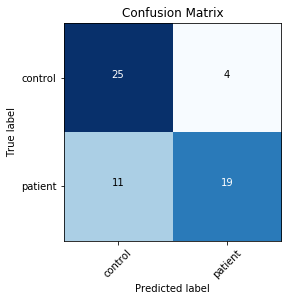

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 1303769
[0,    10] loss: 0.69565
[0,    20] loss: 0.70139
[0,    30] loss: 0.69868
[0,    40] loss: 0.68601
[0,    50] loss: 0.67692
Time elapsed: 0h:0m:27s
train accuracy_score: 54.20 %
train balanced_accuracy: 53.53 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.723333
[1,    10] loss: 0.68627
[1,    20] loss: 0.70195
[1,    30] loss: 0.68902
[1,    40] loss: 0.70008
[1,    50] loss: 0.69271
Time elapsed: 0h:1m:7s
train accuracy_score: 55.04 %
train balanced_accuracy: 51.09 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693337
[2,    10] loss: 0.68569
[2,    20] loss: 0.67352
[2,    30] loss: 0.72558
[2,    40] loss: 0.68795
[2,    50] loss: 0.69062
Time elapsed: 0h:1m:47s
train accuracy_score: 55.04 %
train balanced_accuracy: 51.56 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.696919


val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.696130
[28,    10] loss: 0.67791
[28,    20] loss: 0.67249
[28,    30] loss: 0.71036
[28,    40] loss: 0.69895
[28,    50] loss: 0.69971
Time elapsed: 0h:19m:10s
train accuracy_score: 53.78 %
train balanced_accuracy: 51.42 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.700455
[29,    10] loss: 0.65932
[29,    20] loss: 0.74281
[29,    30] loss: 0.68570
[29,    40] loss: 0.67425
[29,    50] loss: 0.67870
Time elapsed: 0h:19m:50s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.24 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.699455
[30,    10] loss: 0.66526
[30,    20] loss: 0.73822
[30,    30] loss: 0.69698
[30,    40] loss: 0.70412
[30,    50] loss: 0.68925
Time elapsed: 0h:20m:29s
train accuracy_score: 52.94 %
train balanced_accuracy: 50.34 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692004
[31,    10] loss: 0.67953
[31,    

val accuracy_score: 64.41 %
val balanced_accuracy: 64.54 %
Val loss: 0.674119
[56,    10] loss: 0.66072
[56,    20] loss: 0.66447
[56,    30] loss: 0.61681
[56,    40] loss: 0.66622
[56,    50] loss: 0.63631
Time elapsed: 0h:37m:45s
train accuracy_score: 68.49 %
train balanced_accuracy: 66.61 %
val accuracy_score: 52.54 %
val balanced_accuracy: 53.16 %
Val loss: 0.669914
[57,    10] loss: 0.63151
[57,    20] loss: 0.66282
[57,    30] loss: 0.64275
[57,    40] loss: 0.64576
[57,    50] loss: 0.67332
Time elapsed: 0h:38m:24s
train accuracy_score: 63.03 %
train balanced_accuracy: 61.77 %
val accuracy_score: 55.93 %
val balanced_accuracy: 56.49 %
Val loss: 0.671990
[58,    10] loss: 0.60833
[58,    20] loss: 0.61212
[58,    30] loss: 0.59306
[58,    40] loss: 0.69571
[58,    50] loss: 0.63228
Time elapsed: 0h:39m:3s
train accuracy_score: 64.29 %
train balanced_accuracy: 62.76 %
val accuracy_score: 61.02 %
val balanced_accuracy: 60.98 %
Val loss: 0.653305
[59,    10] loss: 0.57260
[59,    2

val accuracy_score: 69.49 %
val balanced_accuracy: 69.02 %
Val loss: 0.555604
[84,    10] loss: 0.64057
[84,    20] loss: 0.54454
[84,    30] loss: 0.45388
[84,    40] loss: 0.61863
[84,    50] loss: 0.41300
Time elapsed: 0h:56m:19s
train accuracy_score: 75.21 %
train balanced_accuracy: 74.72 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.71 %
Val loss: 0.525893
[85,    10] loss: 0.52442
[85,    20] loss: 0.46412
[85,    30] loss: 0.55609
[85,    40] loss: 0.60313
[85,    50] loss: 0.45806
Time elapsed: 0h:56m:59s
train accuracy_score: 77.31 %
train balanced_accuracy: 76.80 %
val accuracy_score: 72.88 %
val balanced_accuracy: 72.99 %
Val loss: 0.503416
[86,    10] loss: 0.40495
[86,    20] loss: 0.54226
[86,    30] loss: 0.56643
[86,    40] loss: 0.61794
[86,    50] loss: 0.47658
Time elapsed: 0h:57m:39s
train accuracy_score: 73.95 %
train balanced_accuracy: 73.33 %
val accuracy_score: 69.49 %
val balanced_accuracy: 69.60 %
Val loss: 0.529390
[87,    10] loss: 0.55936
[87,    

[111,    50] loss: 0.38734
Time elapsed: 1h:14m:19s
train accuracy_score: 83.19 %
train balanced_accuracy: 82.89 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.16 %
Val loss: 0.409820
[112,    10] loss: 0.27228
[112,    20] loss: 0.34585
[112,    30] loss: 0.39198
[112,    40] loss: 0.32125
[112,    50] loss: 0.64760
Time elapsed: 1h:14m:59s
train accuracy_score: 85.71 %
train balanced_accuracy: 85.67 %
val accuracy_score: 69.49 %
val balanced_accuracy: 69.89 %
Val loss: 0.540668
[113,    10] loss: 0.32743
[113,    20] loss: 0.31318
[113,    30] loss: 0.43376
[113,    40] loss: 0.30971
[113,    50] loss: 0.51091
Time elapsed: 1h:15m:40s
train accuracy_score: 82.35 %
train balanced_accuracy: 81.97 %
val accuracy_score: 69.49 %
val balanced_accuracy: 69.94 %
Val loss: 0.507884
[114,    10] loss: 0.27970
[114,    20] loss: 0.33336
[114,    30] loss: 0.30274
[114,    40] loss: 0.34153
[114,    50] loss: 0.38454
Time elapsed: 1h:16m:21s
train accuracy_score: 84.87 %
train balanced_

val accuracy_score: 72.88 %
val balanced_accuracy: 72.70 %
Val loss: 0.479306
[139,    10] loss: 0.26693
[139,    20] loss: 0.27893
[139,    30] loss: 0.29753
[139,    40] loss: 0.27765
[139,    50] loss: 0.35353
Time elapsed: 1h:33m:1s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.36 %
val accuracy_score: 76.27 %
val balanced_accuracy: 76.44 %
Val loss: 0.382337
[140,    10] loss: 0.16572
[140,    20] loss: 0.26136
[140,    30] loss: 0.32958
[140,    40] loss: 0.24356
[140,    50] loss: 0.29481
Time elapsed: 1h:33m:41s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.13 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.99 %
Val loss: 0.342715
[141,    10] loss: 0.24836
[141,    20] loss: 0.22221
[141,    30] loss: 0.25882
[141,    40] loss: 0.27648
[141,    50] loss: 0.28304
Time elapsed: 1h:34m:22s
train accuracy_score: 85.71 %
train balanced_accuracy: 85.67 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.83 %
Val loss: 0.390211
[142,    10] loss: 0

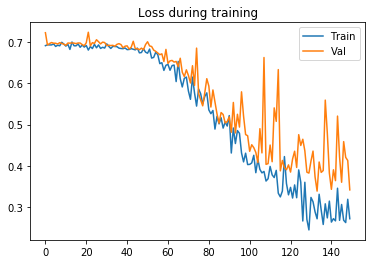

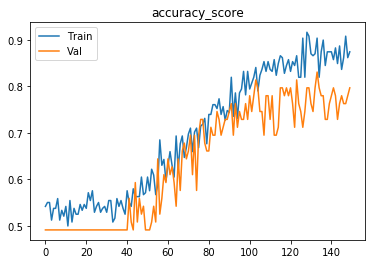

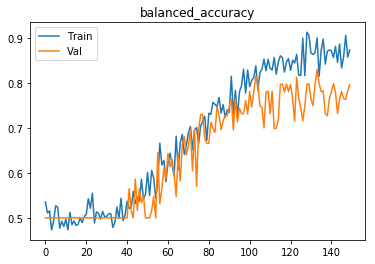

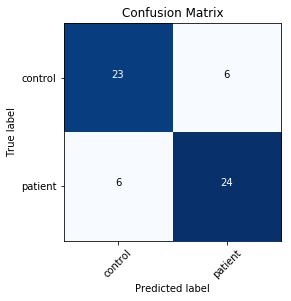

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 787785
[0,    10] loss: 0.71115
[0,    20] loss: 0.72055
[0,    30] loss: 0.69459
Time elapsed: 0h:0m:26s
train accuracy_score: 47.06 %
train balanced_accuracy: 46.68 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693727
[1,    10] loss: 0.70143
[1,    20] loss: 0.68233
[1,    30] loss: 0.69130
Time elapsed: 0h:1m:7s
train accuracy_score: 52.94 %
train balanced_accuracy: 48.93 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694199
[2,    10] loss: 0.70812
[2,    20] loss: 0.70367
[2,    30] loss: 0.70452
Time elapsed: 0h:1m:47s
train accuracy_score: 50.84 %
train balanced_accuracy: 49.28 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693323
[3,    10] loss: 0.69918
[3,    20] loss: 0.71938
[3,    30] loss: 0.72281
Time elapsed: 0h:2m:28s
train accuracy_score: 49.58 %
train balanced_accura

Time elapsed: 0h:22m:38s
train accuracy_score: 58.40 %
train balanced_accuracy: 55.81 %
val accuracy_score: 66.10 %
val balanced_accuracy: 66.15 %
Val loss: 0.675700
[34,    10] loss: 0.67757
[34,    20] loss: 0.67973
[34,    30] loss: 0.67135
Time elapsed: 0h:23m:18s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.02 %
val accuracy_score: 50.85 %
val balanced_accuracy: 51.67 %
Val loss: 0.666039
[35,    10] loss: 0.69145
[35,    20] loss: 0.67547
[35,    30] loss: 0.65250
Time elapsed: 0h:23m:59s
train accuracy_score: 57.56 %
train balanced_accuracy: 55.20 %
val accuracy_score: 52.54 %
val balanced_accuracy: 53.33 %
Val loss: 0.663633
[36,    10] loss: 0.65932
[36,    20] loss: 0.65860
[36,    30] loss: 0.68507
Time elapsed: 0h:24m:40s
train accuracy_score: 58.82 %
train balanced_accuracy: 56.75 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.43 %
Val loss: 0.645055
[37,    10] loss: 0.66701
[37,    20] loss: 0.65779
[37,    30] loss: 0.63835
Time elapsed: 0h:25m:20s

[67,    10] loss: 0.34025
[67,    20] loss: 0.39717
[67,    30] loss: 0.38210
Time elapsed: 0h:45m:35s
train accuracy_score: 82.35 %
train balanced_accuracy: 82.36 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.77 %
Val loss: 0.359898
[68,    10] loss: 0.41150
[68,    20] loss: 0.34413
[68,    30] loss: 0.38281
Time elapsed: 0h:46m:15s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.50 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.70 %
Val loss: 0.459777
[69,    10] loss: 0.37491
[69,    20] loss: 0.28848
[69,    30] loss: 0.42579
Time elapsed: 0h:46m:56s
train accuracy_score: 83.19 %
train balanced_accuracy: 83.21 %
val accuracy_score: 72.88 %
val balanced_accuracy: 72.53 %
Val loss: 0.501185
[70,    10] loss: 0.21693
[70,    20] loss: 0.37643
[70,    30] loss: 0.56627
Time elapsed: 0h:47m:36s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.90 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.38 %
Val loss: 0.356121
[71,    10] loss: 0.3494

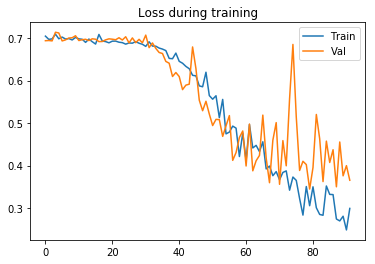

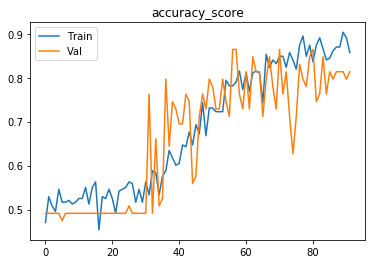

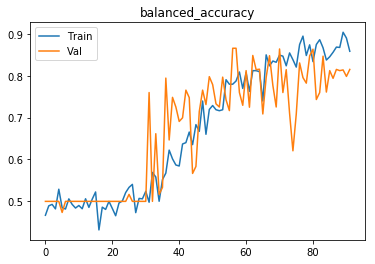

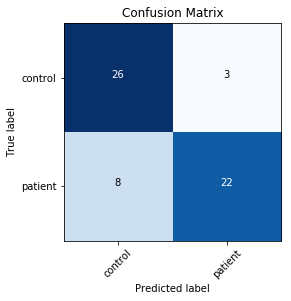

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 787785
[0,    10] loss: 0.69534
[0,    20] loss: 0.71983
[0,    30] loss: 0.68896
Time elapsed: 0h:0m:27s
train accuracy_score: 52.52 %
train balanced_accuracy: 49.80 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694451
[1,    10] loss: 0.69858
[1,    20] loss: 0.68647
[1,    30] loss: 0.68609
Time elapsed: 0h:1m:7s
train accuracy_score: 52.94 %
train balanced_accuracy: 49.25 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.702840
[2,    10] loss: 0.70071
[2,    20] loss: 0.67988
[2,    30] loss: 0.68980
Time elapsed: 0h:1m:48s
train accuracy_score: 52.94 %
train balanced_accuracy: 49.40 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.696875
[3,    10] loss: 0.70543
[3,    20] loss: 0.69644
[3,    30] loss: 0.69303
Time elapsed: 0h:2m:28s
train accuracy_score: 45.38 %
train balanced_accurac

Time elapsed: 0h:22m:35s
train accuracy_score: 53.78 %
train balanced_accuracy: 50.41 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693196
[34,    10] loss: 0.68340
[34,    20] loss: 0.68891
[34,    30] loss: 0.68059
Time elapsed: 0h:23m:15s
train accuracy_score: 55.04 %
train balanced_accuracy: 51.72 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.690117
[35,    10] loss: 0.70424
[35,    20] loss: 0.68365
[35,    30] loss: 0.66991
Time elapsed: 0h:23m:55s
train accuracy_score: 55.04 %
train balanced_accuracy: 51.72 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.699140
[36,    10] loss: 0.65174
[36,    20] loss: 0.68093
[36,    30] loss: 0.67520
Time elapsed: 0h:24m:35s
train accuracy_score: 55.46 %
train balanced_accuracy: 51.87 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.688814
[37,    10] loss: 0.70145
[37,    20] loss: 0.67842
[37,    30] loss: 0.68927
Time elapsed: 0h:25m:15s

[67,    10] loss: 0.59652
[67,    20] loss: 0.52066
[67,    30] loss: 0.61572
Time elapsed: 0h:45m:22s
train accuracy_score: 66.39 %
train balanced_accuracy: 65.86 %
val accuracy_score: 66.10 %
val balanced_accuracy: 65.86 %
Val loss: 0.544540
[68,    10] loss: 0.50316
[68,    20] loss: 0.58466
[68,    30] loss: 0.47845
Time elapsed: 0h:46m:2s
train accuracy_score: 71.01 %
train balanced_accuracy: 70.25 %
val accuracy_score: 71.19 %
val balanced_accuracy: 71.26 %
Val loss: 0.568082
[69,    10] loss: 0.54040
[69,    20] loss: 0.46652
[69,    30] loss: 0.48611
Time elapsed: 0h:46m:42s
train accuracy_score: 74.37 %
train balanced_accuracy: 73.56 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.37 %
Val loss: 0.516441
[70,    10] loss: 0.52918
[70,    20] loss: 0.44452
[70,    30] loss: 0.59813
Time elapsed: 0h:47m:23s
train accuracy_score: 74.37 %
train balanced_accuracy: 74.19 %
val accuracy_score: 72.88 %
val balanced_accuracy: 73.28 %
Val loss: 0.519234
[71,    10] loss: 0.51099

val accuracy_score: 67.80 %
val balanced_accuracy: 67.36 %
Val loss: 0.621725
[101,    10] loss: 0.41862
[101,    20] loss: 0.27473
[101,    30] loss: 0.31843
Time elapsed: 1h:8m:8s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.82 %
val accuracy_score: 72.88 %
val balanced_accuracy: 73.10 %
Val loss: 0.439369
[102,    10] loss: 0.41169
[102,    20] loss: 0.46913
[102,    30] loss: 0.31377
Time elapsed: 1h:8m:49s
train accuracy_score: 79.41 %
train balanced_accuracy: 79.27 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.32 %
Val loss: 0.420729
[103,    10] loss: 0.28413
[103,    20] loss: 0.38302
[103,    30] loss: 0.26184
Time elapsed: 1h:9m:29s
train accuracy_score: 86.13 %
train balanced_accuracy: 85.98 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.32 %
Val loss: 0.440019
[104,    10] loss: 0.26282
[104,    20] loss: 0.36165
[104,    30] loss: 0.38586
Time elapsed: 1h:10m:9s
train accuracy_score: 89.92 %
train balanced_accuracy: 89.67 %
val accuracy_scor

[134,    10] loss: 0.20347
[134,    20] loss: 0.34649
[134,    30] loss: 0.39333
Time elapsed: 1h:30m:6s
train accuracy_score: 86.13 %
train balanced_accuracy: 86.37 %
val accuracy_score: 76.27 %
val balanced_accuracy: 76.21 %
Val loss: 0.517272
[135,    10] loss: 0.21512
[135,    20] loss: 0.28195
[135,    30] loss: 0.30269
Time elapsed: 1h:30m:45s
train accuracy_score: 90.34 %
train balanced_accuracy: 90.06 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.76 %
Val loss: 0.580147
[136,    10] loss: 0.23905
[136,    20] loss: 0.28927
[136,    30] loss: 0.31265
Time elapsed: 1h:31m:25s
train accuracy_score: 88.24 %
train balanced_accuracy: 88.29 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.05 %
Val loss: 0.487209
Early stopping in epoch 137
Total time elapsed: 1h:31m:39s
Writing model to disk...
Best result during training: 0.83. Saving model..
Finished inner fold.


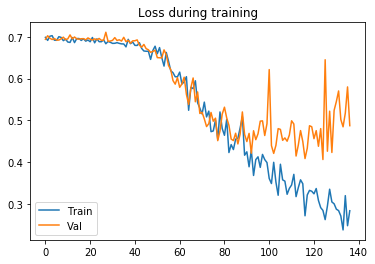

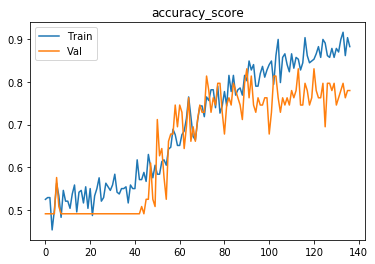

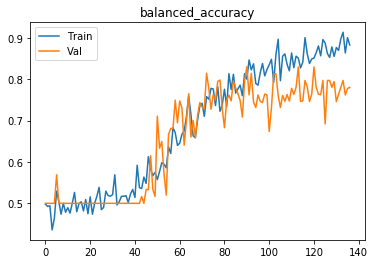

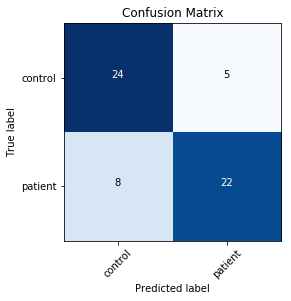

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 787785
[0,    10] loss: 0.69739
[0,    20] loss: 0.72243
[0,    30] loss: 0.66935
Time elapsed: 0h:0m:26s
train accuracy_score: 52.10 %
train balanced_accuracy: 50.90 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692962
[1,    10] loss: 0.70693
[1,    20] loss: 0.70507
[1,    30] loss: 0.69848
Time elapsed: 0h:1m:8s
train accuracy_score: 51.68 %
train balanced_accuracy: 51.07 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.702268
[2,    10] loss: 0.70287
[2,    20] loss: 0.69077
[2,    30] loss: 0.68463
Time elapsed: 0h:1m:48s
train accuracy_score: 51.68 %
train balanced_accuracy: 48.64 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.713472
[3,    10] loss: 0.68526
[3,    20] loss: 0.70835
[3,    30] loss: 0.69488
Time elapsed: 0h:2m:28s
train accuracy_score: 51.68 %
train balanced_accura

Time elapsed: 0h:22m:25s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.09 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692200
[34,    10] loss: 0.69624
[34,    20] loss: 0.68030
[34,    30] loss: 0.70209
Time elapsed: 0h:23m:5s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.09 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694242
[35,    10] loss: 0.67589
[35,    20] loss: 0.69252
[35,    30] loss: 0.70456
Time elapsed: 0h:23m:45s
train accuracy_score: 53.36 %
train balanced_accuracy: 49.63 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.690314
[36,    10] loss: 0.69497
[36,    20] loss: 0.68443
[36,    30] loss: 0.68418
Time elapsed: 0h:24m:25s
train accuracy_score: 55.88 %
train balanced_accuracy: 51.86 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.697624
[37,    10] loss: 0.67960
[37,    20] loss: 0.69519
[37,    30] loss: 0.70777
Time elapsed: 0h:25m:5s
t

[67,    10] loss: 0.50906
[67,    20] loss: 0.47074
[67,    30] loss: 0.55702
Time elapsed: 0h:45m:15s
train accuracy_score: 75.63 %
train balanced_accuracy: 75.42 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.71 %
Val loss: 0.469009
[68,    10] loss: 0.51133
[68,    20] loss: 0.42254
[68,    30] loss: 0.48175
Time elapsed: 0h:45m:55s
train accuracy_score: 74.79 %
train balanced_accuracy: 74.18 %
val accuracy_score: 76.27 %
val balanced_accuracy: 76.32 %
Val loss: 0.480814
[69,    10] loss: 0.58456
[69,    20] loss: 0.45777
[69,    30] loss: 0.37124
Time elapsed: 0h:46m:35s
train accuracy_score: 77.73 %
train balanced_accuracy: 77.42 %
val accuracy_score: 72.88 %
val balanced_accuracy: 73.05 %
Val loss: 0.520611
[70,    10] loss: 0.43612
[70,    20] loss: 0.41473
[70,    30] loss: 0.49046
Time elapsed: 0h:47m:15s
train accuracy_score: 79.83 %
train balanced_accuracy: 79.74 %
val accuracy_score: 71.19 %
val balanced_accuracy: 71.26 %
Val loss: 0.531382
[71,    10] loss: 0.5081

val accuracy_score: 71.19 %
val balanced_accuracy: 71.38 %
Val loss: 0.499236
[101,    10] loss: 0.19478
[101,    20] loss: 0.30466
[101,    30] loss: 0.14432
Time elapsed: 1h:7m:43s
train accuracy_score: 90.76 %
train balanced_accuracy: 90.52 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.32 %
Val loss: 0.391975
[102,    10] loss: 0.34137
[102,    20] loss: 0.24767
[102,    30] loss: 0.25804
Time elapsed: 1h:8m:20s
train accuracy_score: 91.18 %
train balanced_accuracy: 91.22 %
val accuracy_score: 76.27 %
val balanced_accuracy: 76.38 %
Val loss: 0.491968
[103,    10] loss: 0.20774
[103,    20] loss: 0.26269
[103,    30] loss: 0.24002
Time elapsed: 1h:8m:59s
train accuracy_score: 88.24 %
train balanced_accuracy: 87.98 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.05 %
Val loss: 0.438483
[104,    10] loss: 0.31486
[104,    20] loss: 0.24608
[104,    30] loss: 0.22099
Time elapsed: 1h:9m:36s
train accuracy_score: 89.08 %
train balanced_accuracy: 88.90 %
val accuracy_sco

[134,    10] loss: 0.22138
[134,    20] loss: 0.21940
[134,    30] loss: 0.32384
Time elapsed: 1h:28m:42s
train accuracy_score: 90.34 %
train balanced_accuracy: 90.21 %
val accuracy_score: 88.14 %
val balanced_accuracy: 87.93 %
Val loss: 0.358547
[135,    10] loss: 0.11520
[135,    20] loss: 0.24561
[135,    30] loss: 0.13279
Time elapsed: 1h:29m:20s
train accuracy_score: 93.28 %
train balanced_accuracy: 93.14 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.37 %
Val loss: 0.618046
[136,    10] loss: 0.15730
[136,    20] loss: 0.21990
[136,    30] loss: 0.37739
Time elapsed: 1h:29m:59s
train accuracy_score: 90.76 %
train balanced_accuracy: 90.68 %
val accuracy_score: 88.14 %
val balanced_accuracy: 87.93 %
Val loss: 0.358965
[137,    10] loss: 0.14729
[137,    20] loss: 0.16088
[137,    30] loss: 0.23808
Time elapsed: 1h:30m:37s
train accuracy_score: 93.70 %
train balanced_accuracy: 93.60 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.83 %
Val loss: 0.313318
[138,    10]

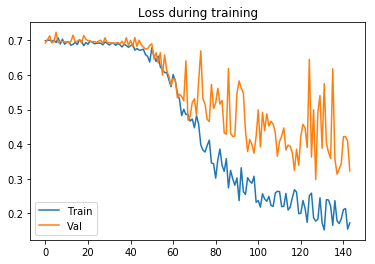

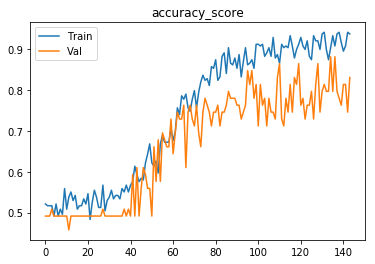

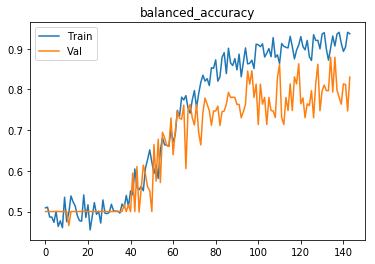

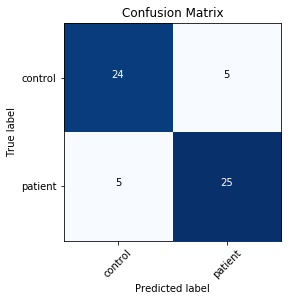

Finished outer fold.
{'final_acc': 0.8149425287356322, 'best_acc': 0.8655172413793104, 'final_iter': 92, 'best_iter': 58, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 2}
###### Starting outer fold 7
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 1303769
[0,    10] loss: 0.68996
[0,    20] loss: 0.72052
[0,    30] loss: 0.70110
Time elapsed: 0h:0m:25s
train accuracy_score: 48.74 %
train balanced_accuracy: 47.66 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.680540
[1,    10] loss: 0.66654
[1,    20] loss: 0.66375
[1,    30] loss: 0.71927
Time elapsed: 0h:1m:4s
train accuracy_score: 57.56 %
train balanced_accuracy: 55.75 %
val accuracy_score: 40.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.712933
[2,    10] loss: 0.71273
[2,    20] loss: 0.69712
[2,    30] loss: 0.73430
Time elapsed: 0h:1m:42s
train accuracy

[32,    30] loss: 0.68175
Time elapsed: 0h:20m:48s
train accuracy_score: 53.78 %
train balanced_accuracy: 51.70 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.671409
[33,    10] loss: 0.69840
[33,    20] loss: 0.68891
[33,    30] loss: 0.66591
Time elapsed: 0h:21m:26s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.79 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.669451
[34,    10] loss: 0.70026
[34,    20] loss: 0.68897
[34,    30] loss: 0.67920
Time elapsed: 0h:22m:4s
train accuracy_score: 50.42 %
train balanced_accuracy: 48.89 %
val accuracy_score: 61.02 %
val balanced_accuracy: 52.08 %
Val loss: 0.678376
[35,    10] loss: 0.67427
[35,    20] loss: 0.69910
[35,    30] loss: 0.67869
Time elapsed: 0h:22m:43s
train accuracy_score: 59.66 %
train balanced_accuracy: 58.57 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.667433
[36,    10] loss: 0.67306
[36,    20] loss: 0.69516
[36,    30] loss: 0.70735

[66,    10] loss: 0.63019
[66,    20] loss: 0.43995
[66,    30] loss: 0.50787
Time elapsed: 0h:42m:31s
train accuracy_score: 75.63 %
train balanced_accuracy: 75.41 %
val accuracy_score: 57.63 %
val balanced_accuracy: 52.50 %
Val loss: 0.635053
[67,    10] loss: 0.54321
[67,    20] loss: 0.60684
[67,    30] loss: 0.55601
Time elapsed: 0h:43m:9s
train accuracy_score: 71.43 %
train balanced_accuracy: 70.84 %
val accuracy_score: 62.71 %
val balanced_accuracy: 61.37 %
Val loss: 0.630934
[68,    10] loss: 0.55912
[68,    20] loss: 0.69262
[68,    30] loss: 0.57680
Time elapsed: 0h:43m:48s
train accuracy_score: 68.07 %
train balanced_accuracy: 67.75 %
val accuracy_score: 59.32 %
val balanced_accuracy: 55.89 %
Val loss: 0.614509
[69,    10] loss: 0.57163
[69,    20] loss: 0.56997
[69,    30] loss: 0.54391
Time elapsed: 0h:44m:26s
train accuracy_score: 68.49 %
train balanced_accuracy: 68.09 %
val accuracy_score: 66.10 %
val balanced_accuracy: 60.30 %
Val loss: 0.637603
[70,    10] loss: 0.57391

val accuracy_score: 71.19 %
val balanced_accuracy: 71.79 %
Val loss: 0.580474
[100,    10] loss: 0.52596
[100,    20] loss: 0.54778
[100,    30] loss: 0.53138
Time elapsed: 1h:4m:6s
train accuracy_score: 73.11 %
train balanced_accuracy: 72.82 %
val accuracy_score: 62.71 %
val balanced_accuracy: 63.99 %
Val loss: 0.574080
[101,    10] loss: 0.53288
[101,    20] loss: 0.60267
[101,    30] loss: 0.46657
Time elapsed: 1h:4m:45s
train accuracy_score: 77.73 %
train balanced_accuracy: 77.49 %
val accuracy_score: 77.97 %
val balanced_accuracy: 74.88 %
Val loss: 0.522865
[102,    10] loss: 0.46986
[102,    20] loss: 0.50692
[102,    30] loss: 0.55701
Time elapsed: 1h:5m:23s
train accuracy_score: 75.63 %
train balanced_accuracy: 75.07 %
val accuracy_score: 66.10 %
val balanced_accuracy: 66.19 %
Val loss: 0.550326
[103,    10] loss: 0.56860
[103,    20] loss: 0.48643
[103,    30] loss: 0.41979
Time elapsed: 1h:6m:2s
train accuracy_score: 74.79 %
train balanced_accuracy: 74.45 %
val accuracy_score

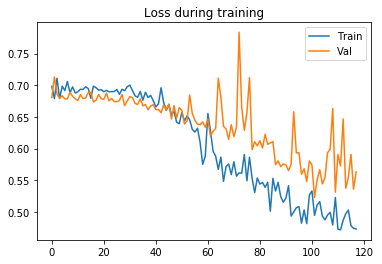

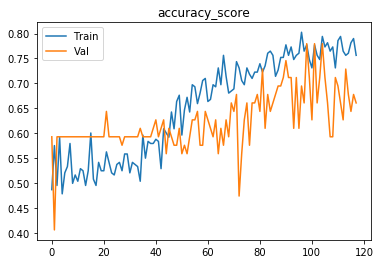

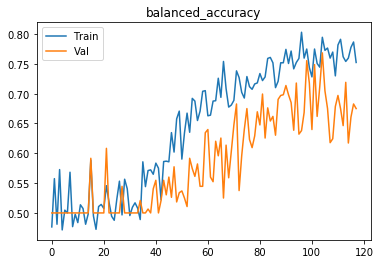

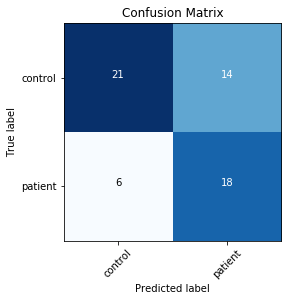

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 1303769
[0,    10] loss: 0.69958
[0,    20] loss: 0.66359
[0,    30] loss: 0.73034
Time elapsed: 0h:0m:25s
train accuracy_score: 52.10 %
train balanced_accuracy: 51.20 %
val accuracy_score: 38.98 %
val balanced_accuracy: 47.92 %
Val loss: 0.693753
[1,    10] loss: 0.69392
[1,    20] loss: 0.68888
[1,    30] loss: 0.71112
Time elapsed: 0h:1m:3s
train accuracy_score: 52.52 %
train balanced_accuracy: 51.60 %
val accuracy_score: 40.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.713706
[2,    10] loss: 0.70557
[2,    20] loss: 0.73167
[2,    30] loss: 0.70078
Time elapsed: 0h:1m:41s
train accuracy_score: 52.94 %
train balanced_accuracy: 52.39 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.675222
[3,    10] loss: 0.74968
[3,    20] loss: 0.69354
[3,    30] loss: 0.70493
Time elapsed: 0h:2m:20s
train accuracy_score: 50.84 %
train balanced_accur

Time elapsed: 0h:21m:22s
train accuracy_score: 47.48 %
train balanced_accuracy: 45.45 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.678349
[34,    10] loss: 0.69493
[34,    20] loss: 0.68686
[34,    30] loss: 0.69931
Time elapsed: 0h:22m:0s
train accuracy_score: 53.36 %
train balanced_accuracy: 51.31 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.679106
[35,    10] loss: 0.68759
[35,    20] loss: 0.71820
[35,    30] loss: 0.68141
Time elapsed: 0h:22m:37s
train accuracy_score: 50.00 %
train balanced_accuracy: 47.19 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.677390
[36,    10] loss: 0.64929
[36,    20] loss: 0.68847
[36,    30] loss: 0.70583
Time elapsed: 0h:23m:16s
train accuracy_score: 54.62 %
train balanced_accuracy: 51.75 %
val accuracy_score: 40.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.697680
[37,    10] loss: 0.69512
[37,    20] loss: 0.69314
[37,    30] loss: 0.69063
Time elapsed: 0h:23m:54s


[67,    10] loss: 0.63909
[67,    20] loss: 0.54020
[67,    30] loss: 0.61262
Time elapsed: 0h:42m:56s
train accuracy_score: 67.65 %
train balanced_accuracy: 67.42 %
val accuracy_score: 76.27 %
val balanced_accuracy: 74.76 %
Val loss: 0.549371
[68,    10] loss: 0.56627
[68,    20] loss: 0.54452
[68,    30] loss: 0.54968
Time elapsed: 0h:43m:34s
train accuracy_score: 71.85 %
train balanced_accuracy: 71.64 %
val accuracy_score: 77.97 %
val balanced_accuracy: 76.85 %
Val loss: 0.559433
[69,    10] loss: 0.55673
[69,    20] loss: 0.57691
[69,    30] loss: 0.57260
Time elapsed: 0h:44m:12s
train accuracy_score: 71.85 %
train balanced_accuracy: 71.41 %
val accuracy_score: 67.80 %
val balanced_accuracy: 69.58 %
Val loss: 0.559352
[70,    10] loss: 0.46259
[70,    20] loss: 0.63049
[70,    30] loss: 0.56454
Time elapsed: 0h:44m:50s
train accuracy_score: 72.69 %
train balanced_accuracy: 72.48 %
val accuracy_score: 81.36 %
val balanced_accuracy: 79.05 %
Val loss: 0.522973
[71,    10] loss: 0.5258

val accuracy_score: 81.36 %
val balanced_accuracy: 78.39 %
Val loss: 0.456052
[101,    10] loss: 0.35891
[101,    20] loss: 0.36993
[101,    30] loss: 0.50700
Time elapsed: 1h:4m:25s
train accuracy_score: 80.67 %
train balanced_accuracy: 80.75 %
val accuracy_score: 74.58 %
val balanced_accuracy: 76.61 %
Val loss: 0.441418
[102,    10] loss: 0.40016
[102,    20] loss: 0.36693
[102,    30] loss: 0.35770
Time elapsed: 1h:5m:3s
train accuracy_score: 84.03 %
train balanced_accuracy: 84.02 %
val accuracy_score: 81.36 %
val balanced_accuracy: 80.36 %
Val loss: 0.394169
[103,    10] loss: 0.34476
[103,    20] loss: 0.32981
[103,    30] loss: 0.51158
Time elapsed: 1h:5m:40s
train accuracy_score: 82.77 %
train balanced_accuracy: 82.72 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.50 %
Val loss: 0.436034
[104,    10] loss: 0.41052
[104,    20] loss: 0.40383
[104,    30] loss: 0.35642
Time elapsed: 1h:6m:19s
train accuracy_score: 81.09 %
train balanced_accuracy: 80.81 %
val accuracy_scor

[134,    10] loss: 0.26481
[134,    20] loss: 0.28082
[134,    30] loss: 0.33177
Time elapsed: 1h:25m:21s
train accuracy_score: 83.19 %
train balanced_accuracy: 83.00 %
val accuracy_score: 79.66 %
val balanced_accuracy: 76.31 %
Val loss: 0.357126
[135,    10] loss: 0.34567
[135,    20] loss: 0.33700
[135,    30] loss: 0.28409
Time elapsed: 1h:25m:59s
train accuracy_score: 85.29 %
train balanced_accuracy: 84.97 %
val accuracy_score: 72.88 %
val balanced_accuracy: 76.49 %
Val loss: 0.559098
[136,    10] loss: 0.35329
[136,    20] loss: 0.25985
[136,    30] loss: 0.38089
Time elapsed: 1h:26m:37s
train accuracy_score: 86.55 %
train balanced_accuracy: 86.61 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.27 %
Val loss: 0.358953
[137,    10] loss: 0.29862
[137,    20] loss: 0.24104
[137,    30] loss: 0.18986
Time elapsed: 1h:27m:15s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.67 %
val accuracy_score: 83.05 %
val balanced_accuracy: 85.06 %
Val loss: 0.382452
[138,    10]

[167,    30] loss: 0.23823
Time elapsed: 1h:46m:15s
train accuracy_score: 91.18 %
train balanced_accuracy: 91.11 %
val accuracy_score: 79.66 %
val balanced_accuracy: 76.31 %
Val loss: 0.405909
[168,    10] loss: 0.24914
[168,    20] loss: 0.14680
[168,    30] loss: 0.27121
Time elapsed: 1h:46m:52s
train accuracy_score: 90.76 %
train balanced_accuracy: 90.66 %
val accuracy_score: 84.75 %
val balanced_accuracy: 83.87 %
Val loss: 0.323177
[169,    10] loss: 0.15988
[169,    20] loss: 0.24864
[169,    30] loss: 0.13518
Time elapsed: 1h:47m:30s
train accuracy_score: 90.76 %
train balanced_accuracy: 90.66 %
val accuracy_score: 77.97 %
val balanced_accuracy: 74.88 %
Val loss: 0.332303
[170,    10] loss: 0.08381
[170,    20] loss: 0.28237
[170,    30] loss: 0.26389
Time elapsed: 1h:48m:8s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.62 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.30 %
Val loss: 0.308879
[171,    10] loss: 0.16752
[171,    20] loss: 0.36147
[171,    30] 

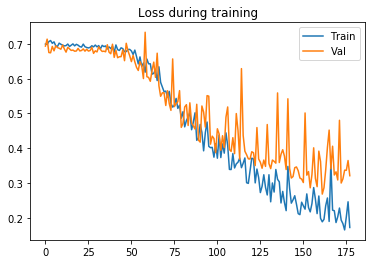

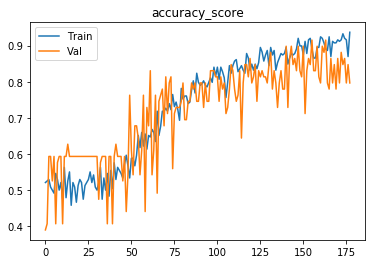

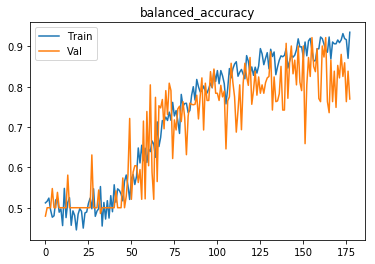

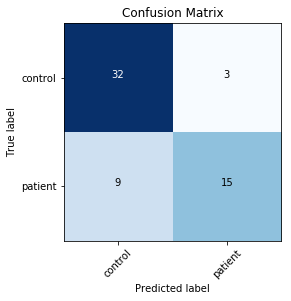

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 787785
[0,    10] loss: 0.67187
[0,    20] loss: 0.74072
[0,    30] loss: 0.66453
[0,    40] loss: 0.70805
[0,    50] loss: 0.69255
Time elapsed: 0h:0m:25s
train accuracy_score: 51.26 %
train balanced_accuracy: 49.28 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.685092
[1,    10] loss: 0.67581
[1,    20] loss: 0.72343
[1,    30] loss: 0.71064
[1,    40] loss: 0.68245
[1,    50] loss: 0.71098
Time elapsed: 0h:1m:3s
train accuracy_score: 44.54 %
train balanced_accuracy: 43.89 %
val accuracy_score: 42.37 %
val balanced_accuracy: 50.77 %
Val loss: 0.693716
[2,    10] loss: 0.68767
[2,    20] loss: 0.71004
[2,    30] loss: 0.69626
[2,    40] loss: 0.71041
[2,    50] loss: 0.69247
Time elapsed: 0h:1m:41s
train accuracy_score: 53.36 %
train balanced_accuracy: 52.27 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.679393
[

val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.678621
[28,    10] loss: 0.68233
[28,    20] loss: 0.70174
[28,    30] loss: 0.70905
[28,    40] loss: 0.68399
[28,    50] loss: 0.65510
Time elapsed: 0h:17m:56s
train accuracy_score: 51.68 %
train balanced_accuracy: 49.96 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.668694
[29,    10] loss: 0.66874
[29,    20] loss: 0.70303
[29,    30] loss: 0.68432
[29,    40] loss: 0.70975
[29,    50] loss: 0.69752
Time elapsed: 0h:18m:34s
train accuracy_score: 49.58 %
train balanced_accuracy: 47.19 %
val accuracy_score: 64.41 %
val balanced_accuracy: 58.87 %
Val loss: 0.686132
[30,    10] loss: 0.69701
[30,    20] loss: 0.68374
[30,    30] loss: 0.66952
[30,    40] loss: 0.73310
[30,    50] loss: 0.68965
Time elapsed: 0h:19m:12s
train accuracy_score: 50.42 %
train balanced_accuracy: 48.55 %
val accuracy_score: 66.10 %
val balanced_accuracy: 59.64 %
Val loss: 0.686505
[31,    10] loss: 0.68649
[31,    

Time elapsed: 0h:34m:59s
train accuracy_score: 56.30 %
train balanced_accuracy: 55.93 %
val accuracy_score: 71.19 %
val balanced_accuracy: 65.24 %
Val loss: 0.605918
[56,    10] loss: 0.62916
[56,    20] loss: 0.59970
[56,    30] loss: 0.57416
[56,    40] loss: 0.62341
[56,    50] loss: 0.60202
Time elapsed: 0h:35m:36s
train accuracy_score: 68.49 %
train balanced_accuracy: 67.75 %
val accuracy_score: 67.80 %
val balanced_accuracy: 60.42 %
Val loss: 0.598747
[57,    10] loss: 0.65658
[57,    20] loss: 0.60256
[57,    30] loss: 0.62003
[57,    40] loss: 0.57364
[57,    50] loss: 0.63417
Time elapsed: 0h:36m:14s
train accuracy_score: 66.39 %
train balanced_accuracy: 65.72 %
val accuracy_score: 69.49 %
val balanced_accuracy: 71.01 %
Val loss: 0.614150
[58,    10] loss: 0.55018
[58,    20] loss: 0.63117
[58,    30] loss: 0.61452
[58,    40] loss: 0.64979
[58,    50] loss: 0.70109
Time elapsed: 0h:36m:52s
train accuracy_score: 67.23 %
train balanced_accuracy: 67.02 %
val accuracy_score: 72.8

[83,    30] loss: 0.40353
[83,    40] loss: 0.36291
[83,    50] loss: 0.34921
Time elapsed: 0h:52m:47s
train accuracy_score: 81.93 %
train balanced_accuracy: 81.99 %
val accuracy_score: 83.05 %
val balanced_accuracy: 81.79 %
Val loss: 0.430704
[84,    10] loss: 0.45460
[84,    20] loss: 0.64395
[84,    30] loss: 0.37875
[84,    40] loss: 0.41654
[84,    50] loss: 0.60579
Time elapsed: 0h:53m:25s
train accuracy_score: 79.41 %
train balanced_accuracy: 79.46 %
val accuracy_score: 81.36 %
val balanced_accuracy: 79.70 %
Val loss: 0.456108
[85,    10] loss: 0.30971
[85,    20] loss: 0.36501
[85,    30] loss: 0.62451
[85,    40] loss: 0.60111
[85,    50] loss: 0.42815
Time elapsed: 0h:54m:3s
train accuracy_score: 79.41 %
train balanced_accuracy: 79.06 %
val accuracy_score: 76.27 %
val balanced_accuracy: 78.69 %
Val loss: 0.456491
[86,    10] loss: 0.36895
[86,    20] loss: 0.41402
[86,    30] loss: 0.46178
[86,    40] loss: 0.65098
[86,    50] loss: 0.61225
Time elapsed: 0h:54m:41s
train accu

[111,    10] loss: 0.38395
[111,    20] loss: 0.31432
[111,    30] loss: 0.37491
[111,    40] loss: 0.42883
[111,    50] loss: 0.42512
Time elapsed: 1h:10m:39s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.85 %
val accuracy_score: 89.83 %
val balanced_accuracy: 88.81 %
Val loss: 0.366295
[112,    10] loss: 0.37340
[112,    20] loss: 0.35946
[112,    30] loss: 0.39175
[112,    40] loss: 0.38921
[112,    50] loss: 0.36326
Time elapsed: 1h:11m:16s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.96 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.67 %
Val loss: 0.368019
[113,    10] loss: 0.46541
[113,    20] loss: 0.35508
[113,    30] loss: 0.38821
[113,    40] loss: 0.36365
[113,    50] loss: 0.49811
Time elapsed: 1h:11m:53s
train accuracy_score: 84.45 %
train balanced_accuracy: 84.58 %
val accuracy_score: 84.75 %
val balanced_accuracy: 81.90 %
Val loss: 0.372601
[114,    10] loss: 0.34724
[114,    20] loss: 0.30674
[114,    30] loss: 0.39035
[114,    40] los

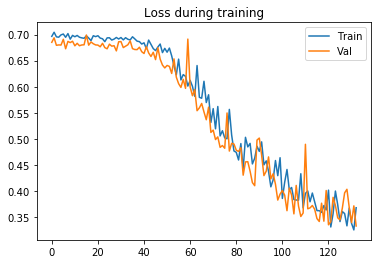

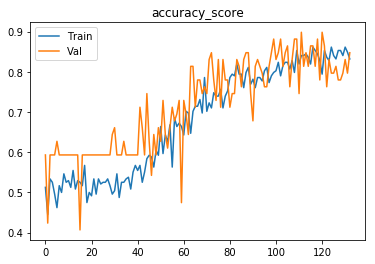

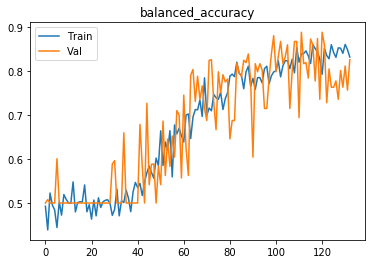

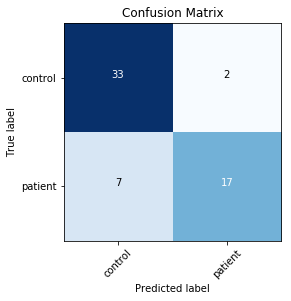

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 787785
[0,    10] loss: 0.70534
Time elapsed: 0h:0m:27s
train accuracy_score: 49.16 %
train balanced_accuracy: 47.14 %
val accuracy_score: 40.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.695270
[1,    10] loss: 0.70550
Time elapsed: 0h:1m:6s
train accuracy_score: 48.32 %
train balanced_accuracy: 48.23 %
val accuracy_score: 57.63 %
val balanced_accuracy: 51.85 %
Val loss: 0.689646
[2,    10] loss: 0.69861
Time elapsed: 0h:1m:46s
train accuracy_score: 49.58 %
train balanced_accuracy: 47.42 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.686951
[3,    10] loss: 0.69370
Time elapsed: 0h:2m:25s
train accuracy_score: 47.90 %
train balanced_accuracy: 47.15 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.681495
[4,    10] loss: 0.68034
Time elapsed: 0h:3m:4s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.11 

val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.649853
[43,    10] loss: 0.68644
Time elapsed: 0h:28m:33s
train accuracy_score: 52.52 %
train balanced_accuracy: 50.69 %
val accuracy_score: 66.10 %
val balanced_accuracy: 68.15 %
Val loss: 0.668837
[44,    10] loss: 0.66994
Time elapsed: 0h:29m:12s
train accuracy_score: 58.40 %
train balanced_accuracy: 57.62 %
val accuracy_score: 64.41 %
val balanced_accuracy: 56.25 %
Val loss: 0.648420
[45,    10] loss: 0.65109
Time elapsed: 0h:29m:51s
train accuracy_score: 57.98 %
train balanced_accuracy: 56.09 %
val accuracy_score: 69.49 %
val balanced_accuracy: 62.50 %
Val loss: 0.652037
[46,    10] loss: 0.65760
Time elapsed: 0h:30m:31s
train accuracy_score: 59.66 %
train balanced_accuracy: 57.78 %
val accuracy_score: 74.58 %
val balanced_accuracy: 70.71 %
Val loss: 0.650644
[47,    10] loss: 0.65350
Time elapsed: 0h:31m:9s
train accuracy_score: 63.45 %
train balanced_accuracy: 64.22 %
val accuracy_score: 76.27 %
val balanced_

val accuracy_score: 77.97 %
val balanced_accuracy: 74.88 %
Val loss: 0.377540
[86,    10] loss: 0.32525
Time elapsed: 0h:56m:41s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.86 %
val accuracy_score: 81.36 %
val balanced_accuracy: 77.74 %
Val loss: 0.390007
[87,    10] loss: 0.34855
Time elapsed: 0h:57m:20s
train accuracy_score: 83.19 %
train balanced_accuracy: 82.78 %
val accuracy_score: 74.58 %
val balanced_accuracy: 68.75 %
Val loss: 0.506644
[88,    10] loss: 0.48405
Time elapsed: 0h:58m:0s
train accuracy_score: 79.83 %
train balanced_accuracy: 79.51 %
val accuracy_score: 81.36 %
val balanced_accuracy: 77.74 %
Val loss: 0.382331
[89,    10] loss: 0.28770
Time elapsed: 0h:58m:39s
train accuracy_score: 82.35 %
train balanced_accuracy: 82.16 %
val accuracy_score: 67.80 %
val balanced_accuracy: 72.86 %
Val loss: 0.609269
[90,    10] loss: 0.45549
Time elapsed: 0h:59m:18s
train accuracy_score: 77.31 %
train balanced_accuracy: 77.04 %
val accuracy_score: 77.97 %
val balanced_

val accuracy_score: 84.75 %
val balanced_accuracy: 85.83 %
Val loss: 0.359755
Early stopping in epoch 129
Total time elapsed: 1h:24m:22s
Writing model to disk...
Best result during training: 0.89. Saving model..
Finished inner fold.


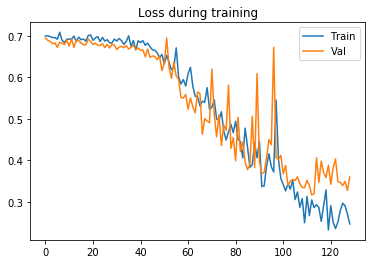

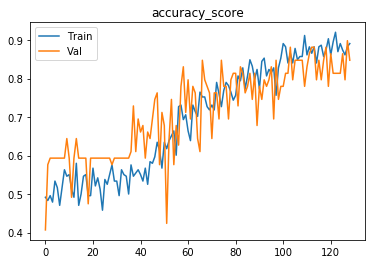

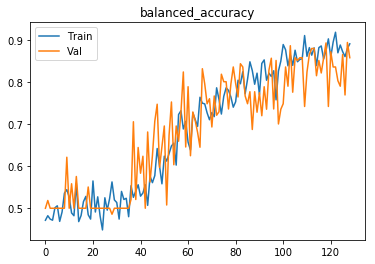

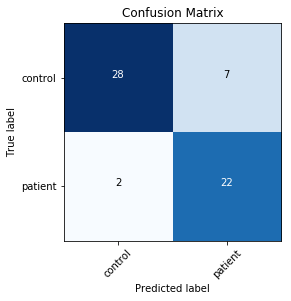

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 787785
[0,    10] loss: 0.70802
[0,    20] loss: 0.69466
[0,    30] loss: 0.69163
Time elapsed: 0h:0m:25s
train accuracy_score: 48.32 %
train balanced_accuracy: 47.26 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.686574
[1,    10] loss: 0.69179
[1,    20] loss: 0.68023
[1,    30] loss: 0.71505
Time elapsed: 0h:1m:3s
train accuracy_score: 54.20 %
train balanced_accuracy: 53.85 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.688077
[2,    10] loss: 0.70327
[2,    20] loss: 0.71306
[2,    30] loss: 0.69331
Time elapsed: 0h:1m:42s
train accuracy_score: 47.90 %
train balanced_accuracy: 46.36 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.682486
[3,    10] loss: 0.70103
[3,    20] loss: 0.69378
[3,    30] loss: 0.68917
Time elapsed: 0h:2m:19s
train accuracy_score: 52.52 %
train balanced_accura

Time elapsed: 0h:21m:28s
train accuracy_score: 64.71 %
train balanced_accuracy: 64.26 %
val accuracy_score: 62.71 %
val balanced_accuracy: 54.17 %
Val loss: 0.668001
[34,    10] loss: 0.62328
[34,    20] loss: 0.61770
[34,    30] loss: 0.63370
Time elapsed: 0h:22m:6s
train accuracy_score: 62.18 %
train balanced_accuracy: 61.56 %
val accuracy_score: 57.63 %
val balanced_accuracy: 52.50 %
Val loss: 0.632456
[35,    10] loss: 0.64679
[35,    20] loss: 0.68342
[35,    30] loss: 0.56465
Time elapsed: 0h:22m:44s
train accuracy_score: 64.29 %
train balanced_accuracy: 64.44 %
val accuracy_score: 54.24 %
val balanced_accuracy: 49.64 %
Val loss: 0.640742
[36,    10] loss: 0.61728
[36,    20] loss: 0.59415
[36,    30] loss: 0.58673
Time elapsed: 0h:23m:22s
train accuracy_score: 71.01 %
train balanced_accuracy: 70.45 %
val accuracy_score: 59.32 %
val balanced_accuracy: 54.58 %
Val loss: 0.640239
[37,    10] loss: 0.60094
[37,    20] loss: 0.62130
[37,    30] loss: 0.55896
Time elapsed: 0h:24m:1s
t

[67,    10] loss: 0.51901
[67,    20] loss: 0.49668
[67,    30] loss: 0.45891
Time elapsed: 0h:43m:39s
train accuracy_score: 73.53 %
train balanced_accuracy: 72.98 %
val accuracy_score: 55.93 %
val balanced_accuracy: 60.24 %
Val loss: 0.700112
[68,    10] loss: 0.51337
[68,    20] loss: 0.63963
[68,    30] loss: 0.54431
Time elapsed: 0h:44m:18s
train accuracy_score: 73.53 %
train balanced_accuracy: 73.10 %
val accuracy_score: 67.80 %
val balanced_accuracy: 68.93 %
Val loss: 0.600926
[69,    10] loss: 0.56836
[69,    20] loss: 0.46242
[69,    30] loss: 0.51536
Time elapsed: 0h:44m:57s
train accuracy_score: 74.79 %
train balanced_accuracy: 74.22 %
val accuracy_score: 57.63 %
val balanced_accuracy: 61.67 %
Val loss: 0.665223
[70,    10] loss: 0.55685
[70,    20] loss: 0.51972
[70,    30] loss: 0.53822
Time elapsed: 0h:45m:36s
train accuracy_score: 75.21 %
train balanced_accuracy: 74.90 %
val accuracy_score: 66.10 %
val balanced_accuracy: 63.57 %
Val loss: 0.616944
[71,    10] loss: 0.5683

val accuracy_score: 74.58 %
val balanced_accuracy: 73.99 %
Val loss: 0.501267
[101,    10] loss: 0.40293
[101,    20] loss: 0.51162
[101,    30] loss: 0.48060
Time elapsed: 1h:5m:48s
train accuracy_score: 80.25 %
train balanced_accuracy: 80.19 %
val accuracy_score: 76.27 %
val balanced_accuracy: 75.42 %
Val loss: 0.469099
[102,    10] loss: 0.48508
[102,    20] loss: 0.50063
[102,    30] loss: 0.37348
Time elapsed: 1h:6m:27s
train accuracy_score: 81.51 %
train balanced_accuracy: 81.49 %
val accuracy_score: 71.19 %
val balanced_accuracy: 65.89 %
Val loss: 0.523503
[103,    10] loss: 0.45773
[103,    20] loss: 0.37677
[103,    30] loss: 0.55081
Time elapsed: 1h:7m:6s
train accuracy_score: 79.83 %
train balanced_accuracy: 79.29 %
val accuracy_score: 72.88 %
val balanced_accuracy: 72.56 %
Val loss: 0.473472
[104,    10] loss: 0.37319
[104,    20] loss: 0.48920
[104,    30] loss: 0.45546
Time elapsed: 1h:7m:45s
train accuracy_score: 78.15 %
train balanced_accuracy: 77.94 %
val accuracy_scor

[134,    10] loss: 0.37625
[134,    20] loss: 0.28409
[134,    30] loss: 0.34583
Time elapsed: 1h:27m:21s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.86 %
val accuracy_score: 79.66 %
val balanced_accuracy: 75.00 %
Val loss: 0.392907
[135,    10] loss: 0.41437
[135,    20] loss: 0.34278
[135,    30] loss: 0.29064
Time elapsed: 1h:28m:1s
train accuracy_score: 83.61 %
train balanced_accuracy: 83.45 %
val accuracy_score: 76.27 %
val balanced_accuracy: 70.83 %
Val loss: 0.491409
[136,    10] loss: 0.33123
[136,    20] loss: 0.41279
[136,    30] loss: 0.30992
Time elapsed: 1h:28m:40s
train accuracy_score: 84.45 %
train balanced_accuracy: 84.58 %
val accuracy_score: 81.36 %
val balanced_accuracy: 77.08 %
Val loss: 0.382567
[137,    10] loss: 0.40354
[137,    20] loss: 0.25676
[137,    30] loss: 0.29457
Time elapsed: 1h:29m:19s
train accuracy_score: 88.24 %
train balanced_accuracy: 87.95 %
val accuracy_score: 79.66 %
val balanced_accuracy: 75.00 %
Val loss: 0.399976
[138,    10] 

[167,    30] loss: 0.35550
Time elapsed: 1h:48m:55s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.67 %
val accuracy_score: 83.05 %
val balanced_accuracy: 79.82 %
Val loss: 0.306429
[168,    10] loss: 0.20793
[168,    20] loss: 0.28661
[168,    30] loss: 0.26445
Time elapsed: 1h:49m:34s
train accuracy_score: 89.50 %
train balanced_accuracy: 89.31 %
val accuracy_score: 81.36 %
val balanced_accuracy: 77.74 %
Val loss: 0.343407
[169,    10] loss: 0.23468
[169,    20] loss: 0.30872
[169,    30] loss: 0.29540
Time elapsed: 1h:50m:14s
train accuracy_score: 86.97 %
train balanced_accuracy: 86.83 %
val accuracy_score: 86.44 %
val balanced_accuracy: 83.99 %
Val loss: 0.277366
[170,    10] loss: 0.15183
[170,    20] loss: 0.30327
[170,    30] loss: 0.24436
Time elapsed: 1h:50m:53s
train accuracy_score: 89.92 %
train balanced_accuracy: 89.76 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.64 %
Val loss: 0.434327
[171,    10] loss: 0.24844
[171,    20] loss: 0.20299
[171,    30]

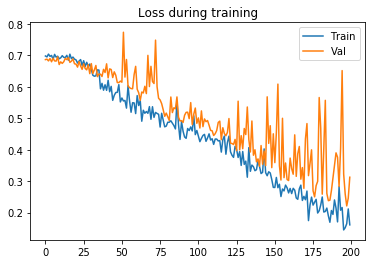

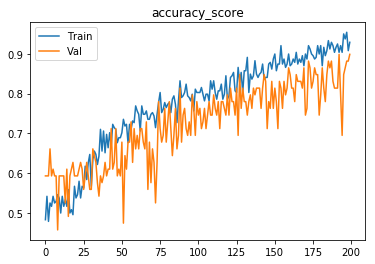

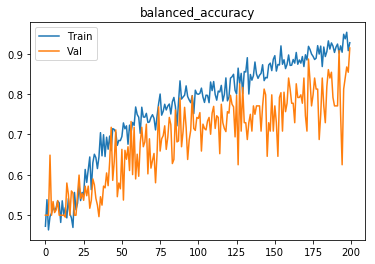

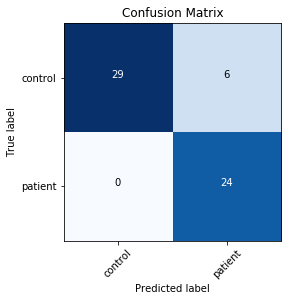

Finished outer fold.
{'final_acc': 0.8583333333333334, 'best_acc': 0.8946428571428571, 'final_iter': 129, 'best_iter': 128, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 3}
###### Starting outer fold 8
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 1303769
[0,    10] loss: 0.70802
Time elapsed: 0h:0m:27s
train accuracy_score: 50.42 %
train balanced_accuracy: 49.91 %
val accuracy_score: 35.59 %
val balanced_accuracy: 50.00 %
Val loss: 0.708988
[1,    10] loss: 0.70382
Time elapsed: 0h:1m:7s
train accuracy_score: 51.68 %
train balanced_accuracy: 51.68 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.668323
[2,    10] loss: 0.69789
Time elapsed: 0h:1m:47s
train accuracy_score: 48.32 %
train balanced_accuracy: 47.68 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.677866
[3,    10] loss: 0

[41,    10] loss: 0.69100
Time elapsed: 0h:27m:56s
train accuracy_score: 49.16 %
train balanced_accuracy: 48.84 %
val accuracy_score: 67.80 %
val balanced_accuracy: 54.76 %
Val loss: 0.679345
[42,    10] loss: 0.69504
Time elapsed: 0h:28m:36s
train accuracy_score: 52.94 %
train balanced_accuracy: 51.69 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.673857
[43,    10] loss: 0.69382
Time elapsed: 0h:29m:16s
train accuracy_score: 55.46 %
train balanced_accuracy: 54.39 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.675098
[44,    10] loss: 0.69069
Time elapsed: 0h:29m:56s
train accuracy_score: 55.04 %
train balanced_accuracy: 53.88 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.668040
[45,    10] loss: 0.68621
Time elapsed: 0h:30m:36s
train accuracy_score: 54.62 %
train balanced_accuracy: 53.23 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.664383
[46,    10] loss: 0.67937
Time elapsed: 

[84,    10] loss: 0.58625
Time elapsed: 0h:56m:35s
train accuracy_score: 67.23 %
train balanced_accuracy: 67.10 %
val accuracy_score: 86.44 %
val balanced_accuracy: 83.08 %
Val loss: 0.423057
[85,    10] loss: 0.53458
Time elapsed: 0h:57m:15s
train accuracy_score: 72.27 %
train balanced_accuracy: 72.15 %
val accuracy_score: 81.36 %
val balanced_accuracy: 73.81 %
Val loss: 0.397476
[86,    10] loss: 0.47823
Time elapsed: 0h:57m:55s
train accuracy_score: 77.73 %
train balanced_accuracy: 77.53 %
val accuracy_score: 86.44 %
val balanced_accuracy: 83.08 %
Val loss: 0.367923
[87,    10] loss: 0.58210
Time elapsed: 0h:58m:35s
train accuracy_score: 71.43 %
train balanced_accuracy: 71.52 %
val accuracy_score: 84.75 %
val balanced_accuracy: 86.03 %
Val loss: 0.396640
[88,    10] loss: 0.51272
Time elapsed: 0h:59m:14s
train accuracy_score: 75.21 %
train balanced_accuracy: 75.29 %
val accuracy_score: 88.14 %
val balanced_accuracy: 89.72 %
Val loss: 0.390330
[89,    10] loss: 0.52670
Time elapsed: 

[127,    10] loss: 0.31678
Time elapsed: 1h:25m:22s
train accuracy_score: 83.61 %
train balanced_accuracy: 83.64 %
val accuracy_score: 81.36 %
val balanced_accuracy: 85.53 %
Val loss: 0.315091
[128,    10] loss: 0.43184
Time elapsed: 1h:26m:2s
train accuracy_score: 81.93 %
train balanced_accuracy: 81.92 %
val accuracy_score: 91.53 %
val balanced_accuracy: 90.23 %
Val loss: 0.209109
[129,    10] loss: 0.33407
Time elapsed: 1h:26m:42s
train accuracy_score: 83.19 %
train balanced_accuracy: 83.23 %
val accuracy_score: 93.22 %
val balanced_accuracy: 90.48 %
Val loss: 0.194880
[130,    10] loss: 0.35637
Time elapsed: 1h:27m:23s
train accuracy_score: 83.19 %
train balanced_accuracy: 82.99 %
val accuracy_score: 89.83 %
val balanced_accuracy: 86.78 %
Val loss: 0.203928
[131,    10] loss: 0.32155
Time elapsed: 1h:28m:3s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.97 %
val accuracy_score: 96.61 %
val balanced_accuracy: 96.30 %
Val loss: 0.180467
[132,    10] loss: 0.24931
Time elaps

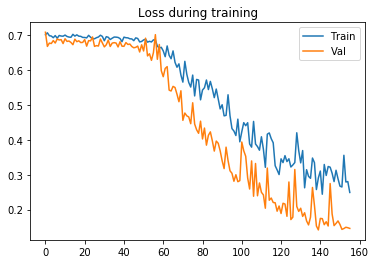

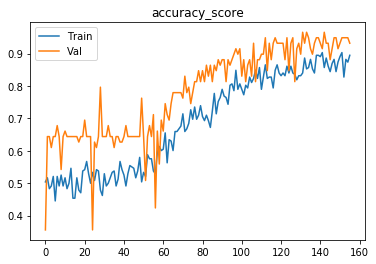

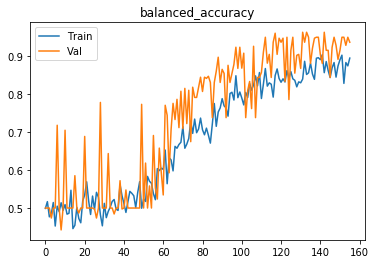

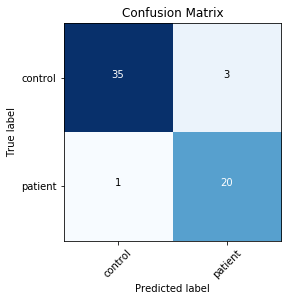

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 1303769
[0,    10] loss: 0.65821
[0,    20] loss: 0.71481
[0,    30] loss: 0.76497
[0,    40] loss: 0.74844
[0,    50] loss: 0.69898
Time elapsed: 0h:0m:26s
train accuracy_score: 47.48 %
train balanced_accuracy: 47.16 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.682278
[1,    10] loss: 0.71075
[1,    20] loss: 0.71640
[1,    30] loss: 0.69999
[1,    40] loss: 0.71621
[1,    50] loss: 0.69519
Time elapsed: 0h:1m:6s
train accuracy_score: 50.00 %
train balanced_accuracy: 48.90 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.666907
[2,    10] loss: 0.71037
[2,    20] loss: 0.71219
[2,    30] loss: 0.67179
[2,    40] loss: 0.71961
[2,    50] loss: 0.69754
Time elapsed: 0h:1m:44s
train accuracy_score: 52.52 %
train balanced_accuracy: 51.54 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.684579

val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.657344
[28,    10] loss: 0.70642
[28,    20] loss: 0.69902
[28,    30] loss: 0.68874
[28,    40] loss: 0.70217
[28,    50] loss: 0.69465
Time elapsed: 0h:18m:46s
train accuracy_score: 50.42 %
train balanced_accuracy: 50.37 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.659910
[29,    10] loss: 0.66553
[29,    20] loss: 0.65365
[29,    30] loss: 0.71431
[29,    40] loss: 0.72996
[29,    50] loss: 0.67179
Time elapsed: 0h:19m:26s
train accuracy_score: 54.62 %
train balanced_accuracy: 53.98 %
val accuracy_score: 62.71 %
val balanced_accuracy: 49.75 %
Val loss: 0.643155
[30,    10] loss: 0.70871
[30,    20] loss: 0.67606
[30,    30] loss: 0.65539
[30,    40] loss: 0.75727
[30,    50] loss: 0.69586
Time elapsed: 0h:20m:5s
train accuracy_score: 51.26 %
train balanced_accuracy: 50.01 %
val accuracy_score: 42.37 %
val balanced_accuracy: 55.26 %
Val loss: 0.712812
[31,    10] loss: 0.67808
[31,    2

Time elapsed: 0h:36m:23s
train accuracy_score: 79.83 %
train balanced_accuracy: 79.76 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.29 %
Val loss: 0.275442
[56,    10] loss: 0.36654
[56,    20] loss: 0.51916
[56,    30] loss: 0.41583
[56,    40] loss: 0.35385
[56,    50] loss: 0.56201
Time elapsed: 0h:37m:1s
train accuracy_score: 78.15 %
train balanced_accuracy: 78.25 %
val accuracy_score: 91.53 %
val balanced_accuracy: 92.36 %
Val loss: 0.336820
[57,    10] loss: 0.56533
[57,    20] loss: 0.33752
[57,    30] loss: 0.39730
[57,    40] loss: 0.58527
[57,    50] loss: 0.43800
Time elapsed: 0h:37m:41s
train accuracy_score: 77.73 %
train balanced_accuracy: 77.82 %
val accuracy_score: 79.66 %
val balanced_accuracy: 72.49 %
Val loss: 0.344226
[58,    10] loss: 0.54120
[58,    20] loss: 0.54439
[58,    30] loss: 0.40444
[58,    40] loss: 0.48140
[58,    50] loss: 0.39154
Time elapsed: 0h:38m:21s
train accuracy_score: 80.25 %
train balanced_accuracy: 80.16 %
val accuracy_score: 91.53

[83,    30] loss: 0.36021
[83,    40] loss: 0.25710
[83,    50] loss: 0.20001
Time elapsed: 0h:54m:45s
train accuracy_score: 89.92 %
train balanced_accuracy: 90.00 %
val accuracy_score: 88.14 %
val balanced_accuracy: 83.33 %
Val loss: 0.231085
[84,    10] loss: 0.13993
[84,    20] loss: 0.27143
[84,    30] loss: 0.43600
[84,    40] loss: 0.33801
[84,    50] loss: 0.27188
Time elapsed: 0h:55m:25s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.78 %
val accuracy_score: 93.22 %
val balanced_accuracy: 94.74 %
Val loss: 0.179017
[85,    10] loss: 0.31630
[85,    20] loss: 0.26369
[85,    30] loss: 0.37362
[85,    40] loss: 0.52743
[85,    50] loss: 0.34693
Time elapsed: 0h:56m:4s
train accuracy_score: 86.13 %
train balanced_accuracy: 86.16 %
val accuracy_score: 93.22 %
val balanced_accuracy: 91.54 %
Val loss: 0.155263
[86,    10] loss: 0.27627
[86,    20] loss: 0.29838
[86,    30] loss: 0.23429
[86,    40] loss: 0.31798
[86,    50] loss: 0.21265
Time elapsed: 0h:56m:43s
train accu

[111,    10] loss: 0.17290
[111,    20] loss: 0.11905
[111,    30] loss: 0.12768
[111,    40] loss: 0.31941
[111,    50] loss: 0.22809
Time elapsed: 1h:12m:58s
train accuracy_score: 91.18 %
train balanced_accuracy: 91.21 %
val accuracy_score: 88.14 %
val balanced_accuracy: 90.79 %
Val loss: 0.244204
[112,    10] loss: 0.24674
[112,    20] loss: 0.22528
[112,    30] loss: 0.28613
[112,    40] loss: 0.18488
[112,    50] loss: 0.32936
Time elapsed: 1h:13m:36s
train accuracy_score: 88.66 %
train balanced_accuracy: 88.65 %
val accuracy_score: 94.92 %
val balanced_accuracy: 96.05 %
Val loss: 0.135895
[113,    10] loss: 0.13513
[113,    20] loss: 0.15985
[113,    30] loss: 0.23743
[113,    40] loss: 0.29410
[113,    50] loss: 0.14015
Time elapsed: 1h:14m:15s
train accuracy_score: 92.86 %
train balanced_accuracy: 92.86 %
val accuracy_score: 91.53 %
val balanced_accuracy: 88.10 %
Val loss: 0.141413
[114,    10] loss: 0.18221
[114,    20] loss: 0.16568
[114,    30] loss: 0.20787
[114,    40] los

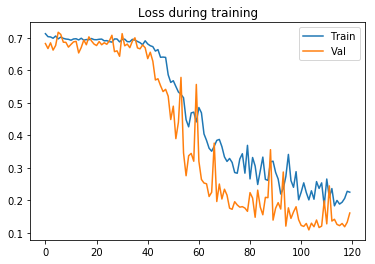

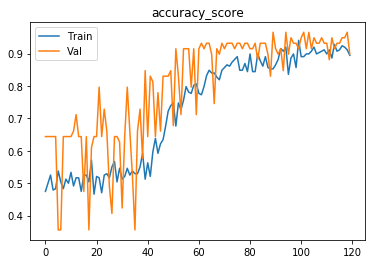

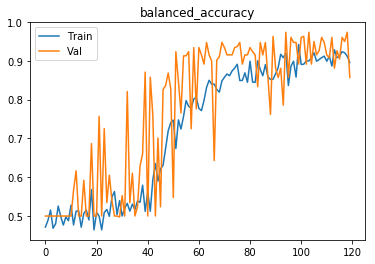

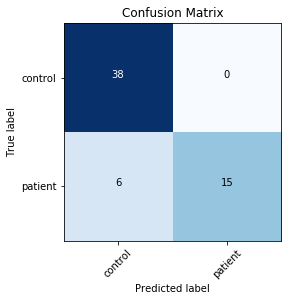

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 787785
[0,    10] loss: 0.71214
Time elapsed: 0h:0m:27s
train accuracy_score: 47.06 %
train balanced_accuracy: 47.39 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.672192
[1,    10] loss: 0.69630
Time elapsed: 0h:1m:6s
train accuracy_score: 49.16 %
train balanced_accuracy: 47.50 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.674661
[2,    10] loss: 0.68985
Time elapsed: 0h:1m:46s
train accuracy_score: 52.94 %
train balanced_accuracy: 50.98 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.680701
[3,    10] loss: 0.70085
Time elapsed: 0h:2m:26s
train accuracy_score: 50.84 %
train balanced_accuracy: 49.50 %
val accuracy_score: 40.68 %
val balanced_accuracy: 53.95 %
Val loss: 0.695192
[4,    10] loss: 0.69804
Time elapsed: 0h:3m:5s
train accuracy_score: 46.64 %
train balanced_accuracy: 47.48 

val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.669110
[43,    10] loss: 0.68164
Time elapsed: 0h:28m:44s
train accuracy_score: 53.36 %
train balanced_accuracy: 52.73 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.671295
[44,    10] loss: 0.69208
Time elapsed: 0h:29m:25s
train accuracy_score: 56.30 %
train balanced_accuracy: 55.02 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.666717
[45,    10] loss: 0.68461
Time elapsed: 0h:30m:5s
train accuracy_score: 50.84 %
train balanced_accuracy: 49.82 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.663951
[46,    10] loss: 0.69457
Time elapsed: 0h:30m:45s
train accuracy_score: 51.68 %
train balanced_accuracy: 50.37 %
val accuracy_score: 83.05 %
val balanced_accuracy: 80.45 %
Val loss: 0.677624
[47,    10] loss: 0.68687
Time elapsed: 0h:31m:25s
train accuracy_score: 60.08 %
train balanced_accuracy: 59.75 %
val accuracy_score: 77.97 %
val balanced_

val accuracy_score: 89.83 %
val balanced_accuracy: 86.78 %
Val loss: 0.283660
[86,    10] loss: 0.35497
Time elapsed: 0h:57m:34s
train accuracy_score: 82.77 %
train balanced_accuracy: 82.62 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.29 %
Val loss: 0.300979
[87,    10] loss: 0.52607
Time elapsed: 0h:58m:14s
train accuracy_score: 76.05 %
train balanced_accuracy: 76.31 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.96 %
Val loss: 0.393541
[88,    10] loss: 0.37613
Time elapsed: 0h:58m:54s
train accuracy_score: 84.45 %
train balanced_accuracy: 84.30 %
val accuracy_score: 89.83 %
val balanced_accuracy: 86.78 %
Val loss: 0.302304
[89,    10] loss: 0.42301
Time elapsed: 0h:59m:34s
train accuracy_score: 78.57 %
train balanced_accuracy: 78.45 %
val accuracy_score: 88.14 %
val balanced_accuracy: 86.53 %
Val loss: 0.280434
[90,    10] loss: 0.38270
Time elapsed: 1h:0m:15s
train accuracy_score: 85.29 %
train balanced_accuracy: 85.36 %
val accuracy_score: 88.14 %
val balanced_

val accuracy_score: 88.14 %
val balanced_accuracy: 83.33 %
Val loss: 0.273735
[129,    10] loss: 0.25719
Time elapsed: 1h:26m:27s
train accuracy_score: 88.24 %
train balanced_accuracy: 88.21 %
val accuracy_score: 91.53 %
val balanced_accuracy: 89.16 %
Val loss: 0.208565
[130,    10] loss: 0.26537
Time elapsed: 1h:27m:7s
train accuracy_score: 86.55 %
train balanced_accuracy: 86.53 %
val accuracy_score: 89.83 %
val balanced_accuracy: 87.84 %
Val loss: 0.225476
[131,    10] loss: 0.21651
Time elapsed: 1h:27m:47s
train accuracy_score: 89.92 %
train balanced_accuracy: 89.93 %
val accuracy_score: 91.53 %
val balanced_accuracy: 88.10 %
Val loss: 0.219691
[132,    10] loss: 0.22599
Time elapsed: 1h:28m:26s
train accuracy_score: 89.50 %
train balanced_accuracy: 89.53 %
val accuracy_score: 89.83 %
val balanced_accuracy: 85.71 %
Val loss: 0.224957
[133,    10] loss: 0.19632
Time elapsed: 1h:29m:7s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.37 %
val accuracy_score: 91.53 %
val balan

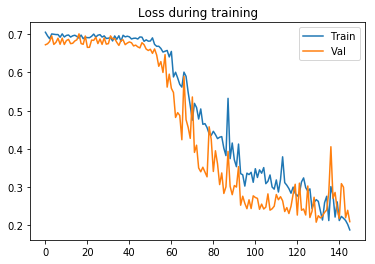

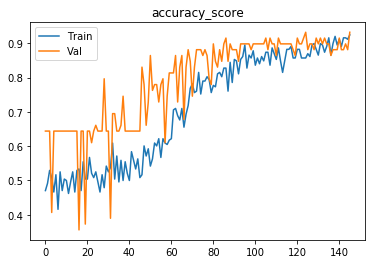

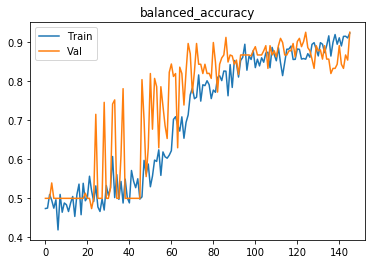

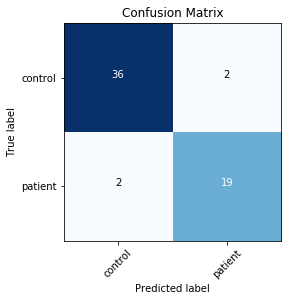

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 787785
[0,    10] loss: 0.69846
[0,    20] loss: 0.70219
[0,    30] loss: 0.69716
Time elapsed: 0h:0m:26s
train accuracy_score: 48.32 %
train balanced_accuracy: 48.49 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.687682
[1,    10] loss: 0.70378
[1,    20] loss: 0.69381
[1,    30] loss: 0.67981
Time elapsed: 0h:1m:5s
train accuracy_score: 50.84 %
train balanced_accuracy: 49.25 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.675376
[2,    10] loss: 0.67697
[2,    20] loss: 0.72890
[2,    30] loss: 0.69145
Time elapsed: 0h:1m:45s
train accuracy_score: 50.42 %
train balanced_accuracy: 49.98 %
val accuracy_score: 35.59 %
val balanced_accuracy: 50.00 %
Val loss: 0.704398
[3,    10] loss: 0.69030
[3,    20] loss: 0.69367
[3,    30] loss: 0.69452
Time elapsed: 0h:2m:24s
train accuracy_score: 50.84 %
train balanced_accurac

Time elapsed: 0h:22m:11s
train accuracy_score: 54.20 %
train balanced_accuracy: 54.81 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.674893
[34,    10] loss: 0.67095
[34,    20] loss: 0.73017
[34,    30] loss: 0.69528
Time elapsed: 0h:22m:51s
train accuracy_score: 50.42 %
train balanced_accuracy: 50.05 %
val accuracy_score: 69.49 %
val balanced_accuracy: 66.73 %
Val loss: 0.686258
[35,    10] loss: 0.68794
[35,    20] loss: 0.69779
[35,    30] loss: 0.70002
Time elapsed: 0h:23m:31s
train accuracy_score: 51.68 %
train balanced_accuracy: 50.45 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.677887
[36,    10] loss: 0.68229
[36,    20] loss: 0.67492
[36,    30] loss: 0.71406
Time elapsed: 0h:24m:10s
train accuracy_score: 52.10 %
train balanced_accuracy: 50.42 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.675902
[37,    10] loss: 0.69932
[37,    20] loss: 0.69670
[37,    30] loss: 0.69926
Time elapsed: 0h:24m:51s

[67,    10] loss: 0.65879
[67,    20] loss: 0.64789
[67,    30] loss: 0.63943
Time elapsed: 0h:44m:33s
train accuracy_score: 63.87 %
train balanced_accuracy: 63.34 %
val accuracy_score: 66.10 %
val balanced_accuracy: 73.68 %
Val loss: 0.661371
[68,    10] loss: 0.64848
[68,    20] loss: 0.65522
[68,    30] loss: 0.65078
Time elapsed: 0h:45m:12s
train accuracy_score: 61.34 %
train balanced_accuracy: 61.21 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.95 %
Val loss: 0.622412
[69,    10] loss: 0.65571
[69,    20] loss: 0.68479
[69,    30] loss: 0.62289
Time elapsed: 0h:45m:52s
train accuracy_score: 63.03 %
train balanced_accuracy: 62.78 %
val accuracy_score: 69.49 %
val balanced_accuracy: 62.47 %
Val loss: 0.590639
[70,    10] loss: 0.67594
[70,    20] loss: 0.65502
[70,    30] loss: 0.63882
Time elapsed: 0h:46m:31s
train accuracy_score: 64.71 %
train balanced_accuracy: 64.54 %
val accuracy_score: 84.75 %
val balanced_accuracy: 80.70 %
Val loss: 0.606177
[71,    10] loss: 0.6361

val accuracy_score: 83.05 %
val balanced_accuracy: 77.26 %
Val loss: 0.347278
[101,    10] loss: 0.45314
[101,    20] loss: 0.50873
[101,    30] loss: 0.51889
Time elapsed: 1h:6m:51s
train accuracy_score: 78.99 %
train balanced_accuracy: 78.81 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.29 %
Val loss: 0.375998
[102,    10] loss: 0.44787
[102,    20] loss: 0.39534
[102,    30] loss: 0.57121
Time elapsed: 1h:7m:30s
train accuracy_score: 81.09 %
train balanced_accuracy: 81.04 %
val accuracy_score: 86.44 %
val balanced_accuracy: 82.02 %
Val loss: 0.339079
[103,    10] loss: 0.42780
[103,    20] loss: 0.48687
[103,    30] loss: 0.47006
Time elapsed: 1h:8m:10s
train accuracy_score: 77.73 %
train balanced_accuracy: 77.53 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.28 %
Val loss: 0.380406
[104,    10] loss: 0.45301
[104,    20] loss: 0.57449
[104,    30] loss: 0.42168
Time elapsed: 1h:8m:50s
train accuracy_score: 79.41 %
train balanced_accuracy: 79.15 %
val accuracy_sco

[134,    10] loss: 0.35744
[134,    20] loss: 0.40771
[134,    30] loss: 0.45589
Time elapsed: 1h:28m:34s
train accuracy_score: 81.93 %
train balanced_accuracy: 81.81 %
val accuracy_score: 94.92 %
val balanced_accuracy: 94.99 %
Val loss: 0.262459
[135,    10] loss: 0.32443
[135,    20] loss: 0.37246
[135,    30] loss: 0.36537
Time elapsed: 1h:29m:13s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.37 %
val accuracy_score: 96.61 %
val balanced_accuracy: 96.30 %
Val loss: 0.241744
[136,    10] loss: 0.27921
[136,    20] loss: 0.36478
[136,    30] loss: 0.35257
Time elapsed: 1h:29m:53s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.27 %
val accuracy_score: 89.83 %
val balanced_accuracy: 86.78 %
Val loss: 0.241303
[137,    10] loss: 0.32786
[137,    20] loss: 0.34261
[137,    30] loss: 0.32451
Time elapsed: 1h:30m:33s
train accuracy_score: 84.45 %
train balanced_accuracy: 84.44 %
val accuracy_score: 89.83 %
val balanced_accuracy: 86.78 %
Val loss: 0.253735
[138,    10]

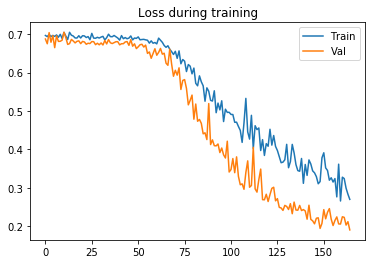

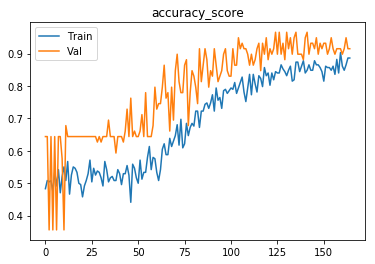

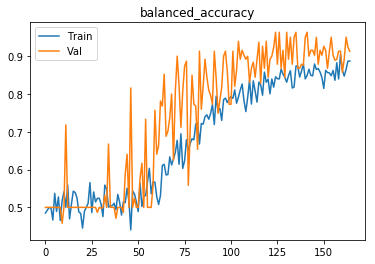

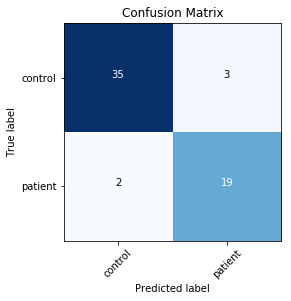

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 787785
[0,    10] loss: 0.70281
Time elapsed: 0h:0m:26s
train accuracy_score: 46.64 %
train balanced_accuracy: 46.07 %
val accuracy_score: 35.59 %
val balanced_accuracy: 50.00 %
Val loss: 0.704567
[1,    10] loss: 0.68937
Time elapsed: 0h:1m:7s
train accuracy_score: 51.68 %
train balanced_accuracy: 50.30 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.670454
[2,    10] loss: 0.70872
Time elapsed: 0h:1m:47s
train accuracy_score: 49.58 %
train balanced_accuracy: 49.17 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.687770
[3,    10] loss: 0.68799
Time elapsed: 0h:2m:27s
train accuracy_score: 54.62 %
train balanced_accuracy: 53.66 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.664218
[4,    10] loss: 0.70053
Time elapsed: 0h:3m:7s
train accuracy_score: 51.26 %
train balanced_accuracy: 49.79 

val accuracy_score: 79.66 %
val balanced_accuracy: 79.95 %
Val loss: 0.674887
[43,    10] loss: 0.68724
Time elapsed: 0h:29m:15s
train accuracy_score: 57.56 %
train balanced_accuracy: 57.26 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.621420
[44,    10] loss: 0.70064
Time elapsed: 0h:29m:56s
train accuracy_score: 58.82 %
train balanced_accuracy: 58.33 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.628833
[45,    10] loss: 0.68079
Time elapsed: 0h:30m:36s
train accuracy_score: 55.46 %
train balanced_accuracy: 53.90 %
val accuracy_score: 69.49 %
val balanced_accuracy: 58.21 %
Val loss: 0.645997
[46,    10] loss: 0.68665
Time elapsed: 0h:31m:16s
train accuracy_score: 55.04 %
train balanced_accuracy: 55.37 %
val accuracy_score: 66.10 %
val balanced_accuracy: 54.51 %
Val loss: 0.625340
[47,    10] loss: 0.68889
Time elapsed: 0h:31m:57s
train accuracy_score: 53.78 %
train balanced_accuracy: 52.60 %
val accuracy_score: 37.29 %
val balanced

val accuracy_score: 91.53 %
val balanced_accuracy: 92.36 %
Val loss: 0.349416
[86,    10] loss: 0.39909
Time elapsed: 0h:58m:12s
train accuracy_score: 81.09 %
train balanced_accuracy: 80.94 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.29 %
Val loss: 0.310745
[87,    10] loss: 0.39643
Time elapsed: 0h:58m:53s
train accuracy_score: 82.77 %
train balanced_accuracy: 82.80 %
val accuracy_score: 86.44 %
val balanced_accuracy: 88.41 %
Val loss: 0.395169
[88,    10] loss: 0.45766
Time elapsed: 0h:59m:33s
train accuracy_score: 82.35 %
train balanced_accuracy: 82.32 %
val accuracy_score: 84.75 %
val balanced_accuracy: 82.83 %
Val loss: 0.334323
[89,    10] loss: 0.41460
Time elapsed: 1h:0m:13s
train accuracy_score: 78.99 %
train balanced_accuracy: 79.03 %
val accuracy_score: 84.75 %
val balanced_accuracy: 82.83 %
Val loss: 0.301849
[90,    10] loss: 0.39234
Time elapsed: 1h:0m:54s
train accuracy_score: 82.77 %
train balanced_accuracy: 82.87 %
val accuracy_score: 91.53 %
val balanced_a

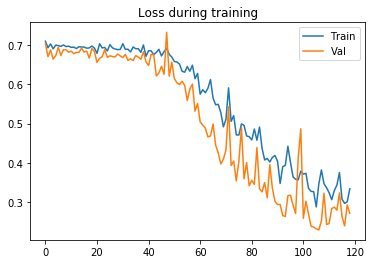

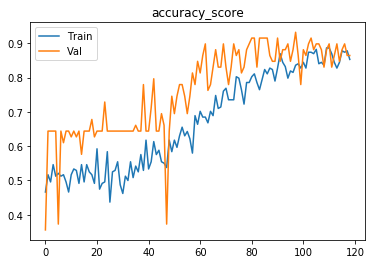

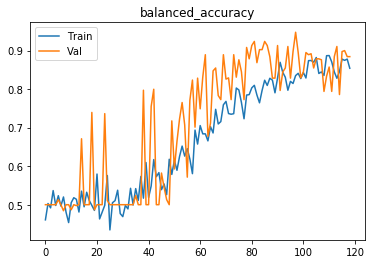

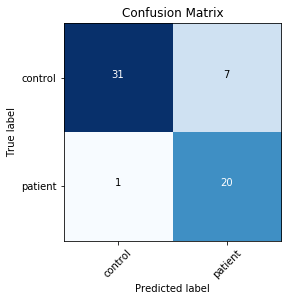

Finished outer fold.
{'final_acc': 0.9367167919799498, 'best_acc': 0.963032581453634, 'final_iter': 156, 'best_iter': 143, 'params': {'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0}
###### Starting outer fold 9
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 1303769
[0,    10] loss: 0.69842
Time elapsed: 0h:0m:27s
train accuracy_score: 49.16 %
train balanced_accuracy: 48.31 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.685794
[1,    10] loss: 0.68734
Time elapsed: 0h:1m:7s
train accuracy_score: 51.68 %
train balanced_accuracy: 49.95 %
val accuracy_score: 52.54 %
val balanced_accuracy: 46.97 %
Val loss: 0.689596
[2,    10] loss: 0.72161
Time elapsed: 0h:1m:48s
train accuracy_score: 47.06 %
train balanced_accuracy: 47.07 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.685053
[3,    10] loss: 0.

[41,    10] loss: 0.68571
Time elapsed: 0h:28m:1s
train accuracy_score: 55.88 %
train balanced_accuracy: 53.97 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.683455
[42,    10] loss: 0.70334
Time elapsed: 0h:28m:41s
train accuracy_score: 49.16 %
train balanced_accuracy: 47.92 %
val accuracy_score: 54.24 %
val balanced_accuracy: 48.48 %
Val loss: 0.686653
[43,    10] loss: 0.68732
Time elapsed: 0h:29m:21s
train accuracy_score: 53.78 %
train balanced_accuracy: 51.54 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.682956
[44,    10] loss: 0.70189
Time elapsed: 0h:30m:2s
train accuracy_score: 54.62 %
train balanced_accuracy: 52.98 %
val accuracy_score: 54.24 %
val balanced_accuracy: 48.48 %
Val loss: 0.685418
[45,    10] loss: 0.69043
Time elapsed: 0h:30m:43s
train accuracy_score: 52.10 %
train balanced_accuracy: 50.35 %
val accuracy_score: 69.49 %
val balanced_accuracy: 70.28 %
Val loss: 0.687751
[46,    10] loss: 0.68400
Time elapsed: 0h

[84,    10] loss: 0.55803
Time elapsed: 0h:56m:53s
train accuracy_score: 74.79 %
train balanced_accuracy: 74.80 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.55 %
Val loss: 0.518918
[85,    10] loss: 0.63329
Time elapsed: 0h:57m:34s
train accuracy_score: 70.17 %
train balanced_accuracy: 69.84 %
val accuracy_score: 79.66 %
val balanced_accuracy: 77.74 %
Val loss: 0.515761
[86,    10] loss: 0.49561
Time elapsed: 0h:58m:14s
train accuracy_score: 72.27 %
train balanced_accuracy: 72.02 %
val accuracy_score: 76.27 %
val balanced_accuracy: 75.93 %
Val loss: 0.512797
[87,    10] loss: 0.44181
Time elapsed: 0h:58m:54s
train accuracy_score: 78.99 %
train balanced_accuracy: 78.97 %
val accuracy_score: 69.49 %
val balanced_accuracy: 71.91 %
Val loss: 0.550043
[88,    10] loss: 0.49749
Time elapsed: 0h:59m:34s
train accuracy_score: 79.41 %
train balanced_accuracy: 79.56 %
val accuracy_score: 71.19 %
val balanced_accuracy: 73.83 %
Val loss: 0.513763
[89,    10] loss: 0.51316
Time elapsed: 

[127,    10] loss: 0.22259
Time elapsed: 1h:25m:53s
train accuracy_score: 88.24 %
train balanced_accuracy: 88.14 %
val accuracy_score: 89.83 %
val balanced_accuracy: 90.50 %
Val loss: 0.280110
[128,    10] loss: 0.24412
Time elapsed: 1h:26m:32s
train accuracy_score: 90.34 %
train balanced_accuracy: 90.38 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.32 %
Val loss: 0.287164
[129,    10] loss: 0.30334
Time elapsed: 1h:27m:13s
train accuracy_score: 86.97 %
train balanced_accuracy: 87.00 %
val accuracy_score: 83.05 %
val balanced_accuracy: 84.44 %
Val loss: 0.345323
[130,    10] loss: 0.28466
Time elapsed: 1h:27m:54s
train accuracy_score: 86.97 %
train balanced_accuracy: 87.10 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.61 %
Val loss: 0.266146
[131,    10] loss: 0.24118
Time elapsed: 1h:28m:33s
train accuracy_score: 88.66 %
train balanced_accuracy: 88.49 %
val accuracy_score: 81.36 %
val balanced_accuracy: 79.25 %
Val loss: 0.384740
[132,    10] loss: 0.29872
Time ela

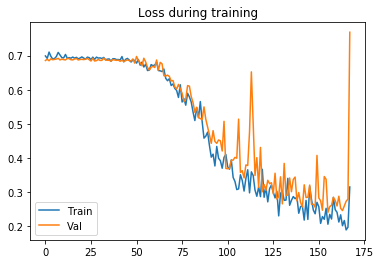

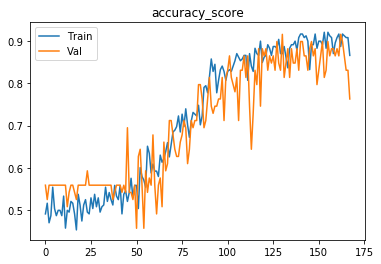

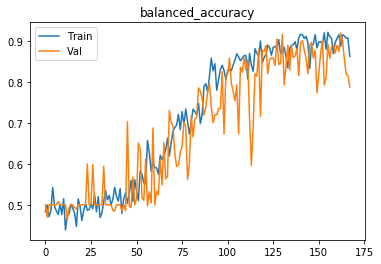

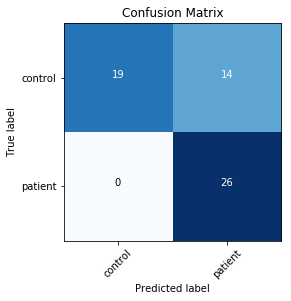

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 1303769
[0,    10] loss: 0.69877
Time elapsed: 0h:0m:27s
train accuracy_score: 46.64 %
train balanced_accuracy: 45.78 %
val accuracy_score: 44.07 %
val balanced_accuracy: 50.00 %
Val loss: 0.697777
[1,    10] loss: 0.70924
Time elapsed: 0h:1m:6s
train accuracy_score: 52.52 %
train balanced_accuracy: 50.45 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.687896
[2,    10] loss: 0.70329
Time elapsed: 0h:1m:47s
train accuracy_score: 50.42 %
train balanced_accuracy: 48.76 %
val accuracy_score: 44.07 %
val balanced_accuracy: 50.00 %
Val loss: 0.697029
[3,    10] loss: 0.69406
Time elapsed: 0h:2m:28s
train accuracy_score: 49.16 %
train balanced_accuracy: 47.57 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.689437
[4,    10] loss: 0.69142
Time elapsed: 0h:3m:8s
train accuracy_score: 52.94 %
train balanced_accuracy: 50.60

val accuracy_score: 55.93 %
val balanced_accuracy: 58.97 %
Val loss: 0.700707
[43,    10] loss: 0.63928
Time elapsed: 0h:29m:29s
train accuracy_score: 61.76 %
train balanced_accuracy: 61.06 %
val accuracy_score: 57.63 %
val balanced_accuracy: 55.19 %
Val loss: 0.665104
[44,    10] loss: 0.61568
Time elapsed: 0h:30m:10s
train accuracy_score: 65.13 %
train balanced_accuracy: 65.03 %
val accuracy_score: 57.63 %
val balanced_accuracy: 55.19 %
Val loss: 0.669886
[45,    10] loss: 0.63899
Time elapsed: 0h:30m:51s
train accuracy_score: 65.13 %
train balanced_accuracy: 64.09 %
val accuracy_score: 54.24 %
val balanced_accuracy: 52.97 %
Val loss: 0.665616
[46,    10] loss: 0.64219
Time elapsed: 0h:31m:31s
train accuracy_score: 68.49 %
train balanced_accuracy: 67.91 %
val accuracy_score: 61.02 %
val balanced_accuracy: 61.07 %
Val loss: 0.665993
[47,    10] loss: 0.61753
Time elapsed: 0h:32m:11s
train accuracy_score: 64.29 %
train balanced_accuracy: 64.34 %
val accuracy_score: 66.10 %
val balanced

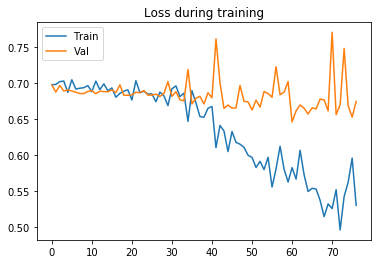

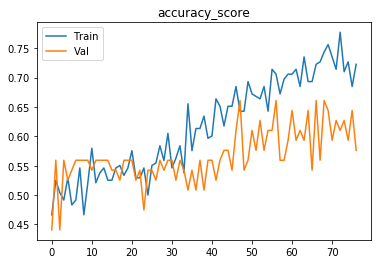

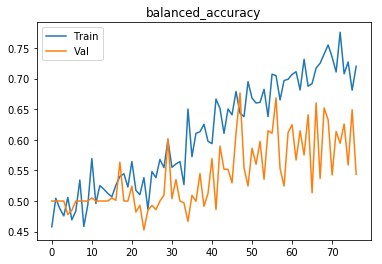

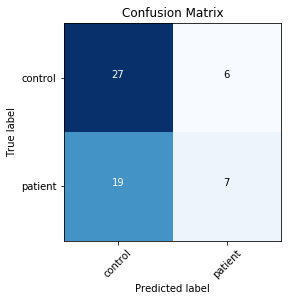

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 787785
[0,    10] loss: 0.69036
Time elapsed: 0h:0m:26s
train accuracy_score: 52.94 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.689323
[1,    10] loss: 0.69714
Time elapsed: 0h:1m:6s
train accuracy_score: 43.28 %
train balanced_accuracy: 42.66 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.688754
[2,    10] loss: 0.69884
Time elapsed: 0h:1m:47s
train accuracy_score: 52.94 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.688746
[3,    10] loss: 0.68633
Time elapsed: 0h:2m:27s
train accuracy_score: 52.94 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.688419
[4,    10] loss: 0.69788
Time elapsed: 0h:3m:8s
train accuracy_score: 49.16 %
train balanced_accuracy: 47.37 %

val accuracy_score: 62.71 %
val balanced_accuracy: 62.59 %
Val loss: 0.685905
[43,    10] loss: 0.67151
Time elapsed: 0h:29m:24s
train accuracy_score: 54.62 %
train balanced_accuracy: 52.83 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.52 %
Val loss: 0.685697
[44,    10] loss: 0.68748
Time elapsed: 0h:30m:5s
train accuracy_score: 54.62 %
train balanced_accuracy: 54.81 %
val accuracy_score: 55.93 %
val balanced_accuracy: 51.22 %
Val loss: 0.681947
[45,    10] loss: 0.69339
Time elapsed: 0h:30m:45s
train accuracy_score: 53.36 %
train balanced_accuracy: 51.84 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.676389
[46,    10] loss: 0.68207
Time elapsed: 0h:31m:26s
train accuracy_score: 53.78 %
train balanced_accuracy: 52.18 %
val accuracy_score: 54.24 %
val balanced_accuracy: 49.71 %
Val loss: 0.681975
[47,    10] loss: 0.67141
Time elapsed: 0h:32m:6s
train accuracy_score: 65.55 %
train balanced_accuracy: 64.73 %
val accuracy_score: 49.15 %
val balanced_a

val accuracy_score: 64.41 %
val balanced_accuracy: 61.66 %
Val loss: 0.688609
[86,    10] loss: 0.51483
Time elapsed: 0h:58m:24s
train accuracy_score: 75.63 %
train balanced_accuracy: 75.50 %
val accuracy_score: 66.10 %
val balanced_accuracy: 63.58 %
Val loss: 0.673767
[87,    10] loss: 0.53900
Time elapsed: 0h:59m:5s
train accuracy_score: 74.37 %
train balanced_accuracy: 74.21 %
val accuracy_score: 66.10 %
val balanced_accuracy: 63.58 %
Val loss: 0.682771
[88,    10] loss: 0.46351
Time elapsed: 0h:59m:46s
train accuracy_score: 74.79 %
train balanced_accuracy: 74.50 %
val accuracy_score: 62.71 %
val balanced_accuracy: 60.14 %
Val loss: 0.618321
[89,    10] loss: 0.50489
Time elapsed: 1h:0m:25s
train accuracy_score: 77.31 %
train balanced_accuracy: 76.64 %
val accuracy_score: 62.71 %
val balanced_accuracy: 60.55 %
Val loss: 0.622807
[90,    10] loss: 0.52135
Time elapsed: 1h:1m:6s
train accuracy_score: 77.73 %
train balanced_accuracy: 77.63 %
val accuracy_score: 62.71 %
val balanced_acc

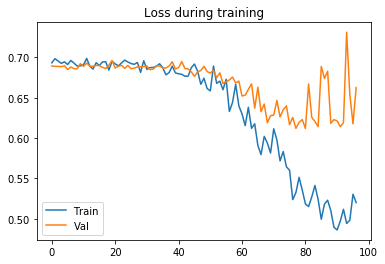

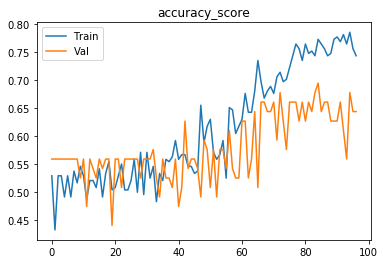

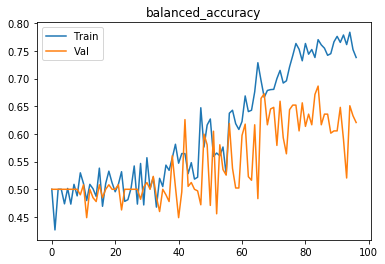

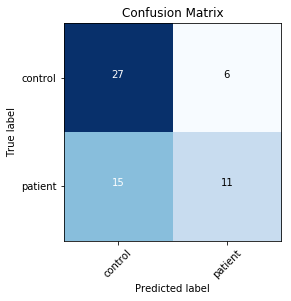

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 787785
[0,    10] loss: 0.69393
Time elapsed: 0h:0m:27s
train accuracy_score: 52.94 %
train balanced_accuracy: 53.97 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.686295
[1,    10] loss: 0.69865
Time elapsed: 0h:1m:7s
train accuracy_score: 52.10 %
train balanced_accuracy: 49.75 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.688494
[2,    10] loss: 0.69670
Time elapsed: 0h:1m:48s
train accuracy_score: 50.84 %
train balanced_accuracy: 48.86 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.684599
[3,    10] loss: 0.70183
Time elapsed: 0h:2m:28s
train accuracy_score: 51.68 %
train balanced_accuracy: 49.11 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.687518
[4,    10] loss: 0.69243
Time elapsed: 0h:3m:8s
train accuracy_score: 44.54 %
train balanced_accuracy: 42.91 %

val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.685077
[43,    10] loss: 0.69843
Time elapsed: 0h:29m:23s
train accuracy_score: 51.68 %
train balanced_accuracy: 48.91 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.687279
[44,    10] loss: 0.68039
Time elapsed: 0h:30m:3s
train accuracy_score: 54.20 %
train balanced_accuracy: 51.49 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.683844
[45,    10] loss: 0.68666
Time elapsed: 0h:30m:45s
train accuracy_score: 55.04 %
train balanced_accuracy: 53.12 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.684180
[46,    10] loss: 0.69613
Time elapsed: 0h:31m:25s
train accuracy_score: 53.78 %
train balanced_accuracy: 52.33 %
val accuracy_score: 54.24 %
val balanced_accuracy: 48.48 %
Val loss: 0.688148
[47,    10] loss: 0.69540
Time elapsed: 0h:32m:6s
train accuracy_score: 52.52 %
train balanced_accuracy: 50.55 %
val accuracy_score: 55.93 %
val balanced_a

val accuracy_score: 52.54 %
val balanced_accuracy: 47.38 %
Val loss: 0.669319
[86,    10] loss: 0.67259
Time elapsed: 0h:58m:21s
train accuracy_score: 60.08 %
train balanced_accuracy: 58.18 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.52 %
Val loss: 0.671111
[87,    10] loss: 0.65912
Time elapsed: 0h:59m:1s
train accuracy_score: 60.92 %
train balanced_accuracy: 60.66 %
val accuracy_score: 50.85 %
val balanced_accuracy: 47.49 %
Val loss: 0.671767
[88,    10] loss: 0.62667
Time elapsed: 0h:59m:43s
train accuracy_score: 65.97 %
train balanced_accuracy: 65.48 %
val accuracy_score: 47.46 %
val balanced_accuracy: 44.87 %
Val loss: 0.676705
[89,    10] loss: 0.64928
Time elapsed: 1h:0m:23s
train accuracy_score: 60.92 %
train balanced_accuracy: 60.52 %
val accuracy_score: 61.02 %
val balanced_accuracy: 61.48 %
Val loss: 0.673242
[90,    10] loss: 0.68195
Time elapsed: 1h:1m:3s
train accuracy_score: 59.24 %
train balanced_accuracy: 59.57 %
val accuracy_score: 54.24 %
val balanced_acc

val accuracy_score: 71.19 %
val balanced_accuracy: 70.16 %
Val loss: 0.594975
[129,    10] loss: 0.55697
Time elapsed: 1h:27m:23s
train accuracy_score: 71.01 %
train balanced_accuracy: 71.03 %
val accuracy_score: 66.10 %
val balanced_accuracy: 66.43 %
Val loss: 0.611866
[130,    10] loss: 0.53893
Time elapsed: 1h:28m:3s
train accuracy_score: 69.33 %
train balanced_accuracy: 69.20 %
val accuracy_score: 69.49 %
val balanced_accuracy: 67.83 %
Val loss: 0.587487
[131,    10] loss: 0.50738
Time elapsed: 1h:28m:44s
train accuracy_score: 77.73 %
train balanced_accuracy: 77.48 %
val accuracy_score: 67.80 %
val balanced_accuracy: 64.69 %
Val loss: 0.606938
[132,    10] loss: 0.56872
Time elapsed: 1h:29m:24s
train accuracy_score: 70.59 %
train balanced_accuracy: 69.84 %
val accuracy_score: 71.19 %
val balanced_accuracy: 71.39 %
Val loss: 0.598203
[133,    10] loss: 0.58218
Time elapsed: 1h:30m:5s
train accuracy_score: 75.63 %
train balanced_accuracy: 76.04 %
val accuracy_score: 69.49 %
val balan

Time elapsed: 1h:55m:41s
train accuracy_score: 81.51 %
train balanced_accuracy: 81.60 %
val accuracy_score: 71.19 %
val balanced_accuracy: 70.16 %
Val loss: 0.523880
[172,    10] loss: 0.46783
Time elapsed: 1h:56m:22s
train accuracy_score: 78.57 %
train balanced_accuracy: 78.57 %
val accuracy_score: 71.19 %
val balanced_accuracy: 69.35 %
Val loss: 0.533960
[173,    10] loss: 0.50476
Time elapsed: 1h:57m:2s
train accuracy_score: 80.67 %
train balanced_accuracy: 80.41 %
val accuracy_score: 71.19 %
val balanced_accuracy: 69.35 %
Val loss: 0.525895
[174,    10] loss: 0.38451
Time elapsed: 1h:57m:44s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.88 %
val accuracy_score: 72.88 %
val balanced_accuracy: 72.09 %
Val loss: 0.513211
[175,    10] loss: 0.41266
Time elapsed: 1h:58m:24s
train accuracy_score: 81.51 %
train balanced_accuracy: 81.40 %
val accuracy_score: 71.19 %
val balanced_accuracy: 70.16 %
Val loss: 0.504787
[176,    10] loss: 0.40445
Time elapsed: 1h:59m:5s
train accura

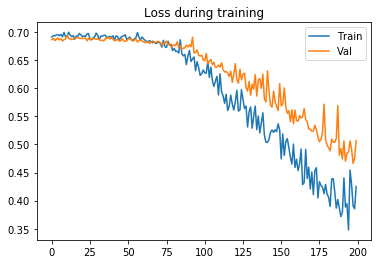

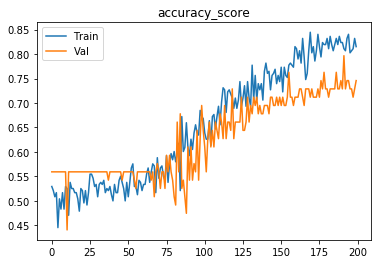

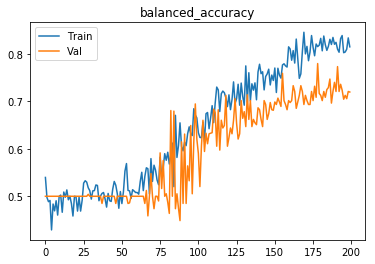

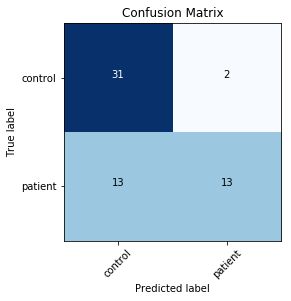

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 1303769
[0,    10] loss: 0.70461
Time elapsed: 0h:0m:27s
train accuracy_score: 49.16 %
train balanced_accuracy: 49.21 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.685436
[1,    10] loss: 0.68228
Time elapsed: 0h:1m:8s
train accuracy_score: 54.62 %
train balanced_accuracy: 52.73 %
val accuracy_score: 44.07 %
val balanced_accuracy: 50.00 %
Val loss: 0.716908
[2,    10] loss: 0.71367
Time elapsed: 0h:1m:47s
train accuracy_score: 52.52 %
train balanced_accuracy: 52.68 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.688944
[3,    10] loss: 0.72290
Time elapsed: 0h:2m:28s
train accuracy_score: 54.62 %
train balanced_accuracy: 53.62 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.691059
[4,    10] loss: 0.71172
Time elapsed: 0h:3m:8s
train accuracy_score: 54.62 %
train balanced_accuracy: 52.98

val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.688524
[43,    10] loss: 0.67339
Time elapsed: 0h:29m:28s
train accuracy_score: 56.30 %
train balanced_accuracy: 54.51 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.683689
[44,    10] loss: 0.69564
Time elapsed: 0h:30m:8s
train accuracy_score: 57.56 %
train balanced_accuracy: 55.46 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.686761
[45,    10] loss: 0.68438
Time elapsed: 0h:30m:48s
train accuracy_score: 52.10 %
train balanced_accuracy: 50.10 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.687146
[46,    10] loss: 0.68737
Time elapsed: 0h:31m:28s
train accuracy_score: 57.14 %
train balanced_accuracy: 56.10 %
val accuracy_score: 54.24 %
val balanced_accuracy: 49.71 %
Val loss: 0.686927
[47,    10] loss: 0.68358
Time elapsed: 0h:32m:8s
train accuracy_score: 57.14 %
train balanced_accuracy: 55.70 %
val accuracy_score: 55.93 %
val balanced_a

val accuracy_score: 64.41 %
val balanced_accuracy: 63.29 %
Val loss: 0.629475
[86,    10] loss: 0.59018
Time elapsed: 0h:58m:22s
train accuracy_score: 69.75 %
train balanced_accuracy: 69.59 %
val accuracy_score: 61.02 %
val balanced_accuracy: 58.62 %
Val loss: 0.639213
[87,    10] loss: 0.58228
Time elapsed: 0h:59m:2s
train accuracy_score: 69.33 %
train balanced_accuracy: 69.25 %
val accuracy_score: 47.46 %
val balanced_accuracy: 51.81 %
Val loss: 0.806862
[88,    10] loss: 0.68831
Time elapsed: 0h:59m:42s
train accuracy_score: 64.29 %
train balanced_accuracy: 64.24 %
val accuracy_score: 67.80 %
val balanced_accuracy: 65.91 %
Val loss: 0.627169
[89,    10] loss: 0.59684
Time elapsed: 1h:0m:23s
train accuracy_score: 68.91 %
train balanced_accuracy: 68.30 %
val accuracy_score: 66.10 %
val balanced_accuracy: 65.62 %
Val loss: 0.626049
[90,    10] loss: 0.58046
Time elapsed: 1h:1m:3s
train accuracy_score: 65.97 %
train balanced_accuracy: 66.12 %
val accuracy_score: 52.54 %
val balanced_acc

val accuracy_score: 71.19 %
val balanced_accuracy: 68.94 %
Val loss: 0.525114
[129,    10] loss: 0.36222
Time elapsed: 1h:27m:19s
train accuracy_score: 78.57 %
train balanced_accuracy: 78.92 %
val accuracy_score: 71.19 %
val balanced_accuracy: 67.31 %
Val loss: 0.611049
[130,    10] loss: 0.37803
Time elapsed: 1h:27m:59s
train accuracy_score: 81.51 %
train balanced_accuracy: 81.10 %
val accuracy_score: 74.58 %
val balanced_accuracy: 73.19 %
Val loss: 0.485496
[131,    10] loss: 0.39780
Time elapsed: 1h:28m:41s
train accuracy_score: 82.35 %
train balanced_accuracy: 82.39 %
val accuracy_score: 74.58 %
val balanced_accuracy: 73.19 %
Val loss: 0.483952
[132,    10] loss: 0.46037
Time elapsed: 1h:29m:21s
train accuracy_score: 81.51 %
train balanced_accuracy: 81.35 %
val accuracy_score: 74.58 %
val balanced_accuracy: 72.38 %
Val loss: 0.513899
[133,    10] loss: 0.41288
Time elapsed: 1h:30m:2s
train accuracy_score: 78.99 %
train balanced_accuracy: 78.57 %
val accuracy_score: 71.19 %
val bala

Time elapsed: 1h:55m:32s
train accuracy_score: 86.97 %
train balanced_accuracy: 87.00 %
val accuracy_score: 79.66 %
val balanced_accuracy: 81.00 %
Val loss: 0.393113
[172,    10] loss: 0.29513
Time elapsed: 1h:56m:12s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.30 %
val accuracy_score: 81.36 %
val balanced_accuracy: 80.48 %
Val loss: 0.338967
[173,    10] loss: 0.27669
Time elapsed: 1h:56m:52s
train accuracy_score: 86.97 %
train balanced_accuracy: 86.86 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.62 %
Val loss: 0.384561
[174,    10] loss: 0.38574
Time elapsed: 1h:57m:32s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.82 %
val accuracy_score: 84.75 %
val balanced_accuracy: 83.51 %
Val loss: 0.346358
[175,    10] loss: 0.27846
Time elapsed: 1h:58m:12s
train accuracy_score: 86.97 %
train balanced_accuracy: 86.81 %
val accuracy_score: 77.97 %
val balanced_accuracy: 76.22 %
Val loss: 0.373276
[176,    10] loss: 0.23822
Time elapsed: 1h:58m:52s
train accu

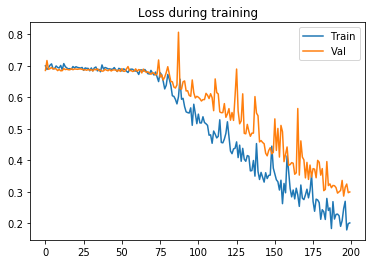

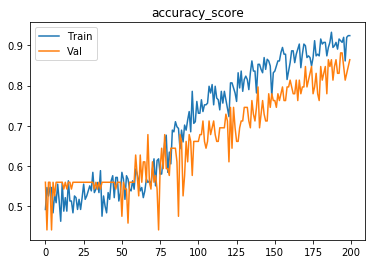

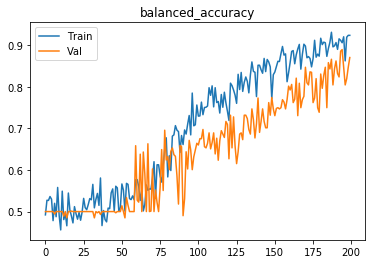

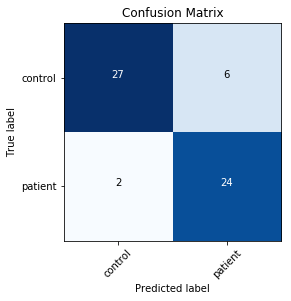

Finished outer fold.
{'final_acc': 0.8706293706293706, 'best_acc': 0.8898601398601399, 'final_iter': 200, 'best_iter': 195, 'params': {'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 4}
################################
################################
All accuracies: [0.546875, 0.853587962962963, 0.7980324074074074, 0.7314814814814814, 0.5, 0.6011764705882353, 0.88, 0.871764705882353, 0.9211764705882352, 0.8476470588235295, 0.8927738927738929, 0.7925407925407926, 0.8694638694638694, 0.7115384615384616, 0.916083916083916, 0.8300691244239631, 0.5, 0.8963133640552995, 0.8444700460829493, 0.8035714285714286, 0.8049768518518519, 0.7708333333333333, 0.8263888888888888, 0.6898148148148149, 0.7407407407407407, 0.8231566820276498, 0.7851382488479263, 0.9032258064516129, 0.8605990783410138, 0.880184331797235, 0.7477011494252873, 0.7965517241379311, 0.8149425287356322, 0.7804597701149425, 0.8304597701149427, 0.675, 0.7696428571428571, 0.825595238095238, 0.858

In [19]:
fold_metric, models = run(net=None, data=df,
                  k_folds=-1,
                  callbacks=None,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  augmentations=augmentations,
                  b=None
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [20]:
5/0

ZeroDivisionError: division by zero

In [16]:
training_res = [{'final_acc': 0.853587962962963, 'best_acc': 0.8564814814814814, 'final_iter': 147, 'best_iter': 140, 'params': {'model': 'ModelA', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 1}, {'final_acc': 0.8476470588235295, 'best_acc': 0.9852941176470589, 'final_iter': 161, 'best_iter': 145, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 4}, {'final_acc': 0.916083916083916, 'best_acc': 0.9312354312354313, 'final_iter': 200, 'best_iter': 162, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 4}, {'final_acc': 0.8963133640552995, 'best_acc': 0.9320276497695852, 'final_iter': 161, 'best_iter': 118, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 2}, {'final_acc': 0.8263888888888888, 'best_acc': 0.8605324074074074, 'final_iter': 111, 'best_iter': 103, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 2}, {'final_acc': 0.9032258064516129, 'best_acc': 0.9302995391705069, 'final_iter': 156, 'best_iter': 139, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 2}, {'final_acc': 0.8149425287356322, 'best_acc': 0.8655172413793104, 'final_iter': 92, 'best_iter': 58, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 2}, {'final_acc': 0.8583333333333334, 'best_acc': 0.8946428571428571, 'final_iter': 129, 'best_iter': 128, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 3}, {'final_acc': 0.9367167919799498, 'best_acc': 0.963032581453634, 'final_iter': 156, 'best_iter': 143, 'params': {'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0}, {'final_acc': 0.8706293706293706, 'best_acc': 0.8898601398601399, 'final_iter': 200, 'best_iter': 195, 'params': {'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 4}]

In [17]:
len(training_res)

10

In [18]:
res_df = pd.DataFrame(training_res)

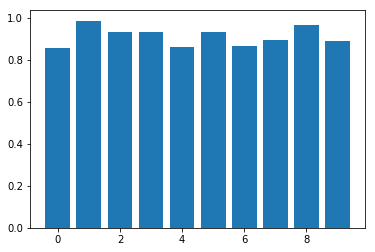

0.9108923446547413
0.8723869021944497


In [19]:
plt.bar(np.arange(len(res_df["best_acc"])), res_df["best_acc"])
plt.show()
print(np.mean(res_df["best_acc"]))
print(np.mean(res_df["final_acc"]))

In [20]:
print(np.mean(res_df["final_iter"]))

151.3


In [21]:
print(res_df["final_iter"])

0    147
1    161
2    200
3    161
4    111
5    156
6     92
7    129
8    156
9    200
Name: final_iter, dtype: int64


# Start inference

In [26]:
from collections import OrderedDict

In [27]:
metrics = []

random_states = np.arange(20, 30) # important to use the same values as during training

for outer_fold, r in enumerate(random_states):
    print("Outer fold {}".format(outer_fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    
    train_res = training_res[outer_fold]
    model_dir = os.path.join(output_dir,"outer_{}_inner_{}_cv_fold_{}_BEST_ITERATION.h5".format(outer_fold, train_res["inner_fold_idx"], outer_fold * 5 + train_res["inner_fold_idx"]))
    model_name = train_res["params"]["model"]
    net = pick_model(model_name)
    state_dict = torch.load(model_dir, map_location='cpu')
    new_state_dict = OrderedDict()
    for param in state_dict.items():
        new_state_dict.update([(param[0].replace("module.", ""), param[1])])
    
    net.load_state_dict(new_state_dict)
    net = net.cuda(gpu)
    net.eval()
    
    # load data
    # separate new test set each run
    no_test_df = df.sample(frac=0.8, random_state=r) # split according 
    test_df = df[~df["PTID"].isin(no_test_df["PTID"])]

    if zero_one_normalize:
        intensity = IntensityRescale()
        ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
    else:
        ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([ToTensor()]), mask=mask)
        
    test_loader = DataLoader(
            ukb_data_test, batch_size=1, num_workers=1, shuffle=False
    )
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Bal Acc"])*100, np.std(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["ROC AUC"])*100, np.std(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Sensitivity"])*100, np.std(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Specificity"])*100, np.std(metrics_df["Specificity"])*100))

Outer fold 0
Bal. accuracy 84.516 %
ROC AUC Score 93.865 %
Sensitivity 78.788 %
Specificity 90.244 %
Outer fold 1
Bal. accuracy 90.586 %
ROC AUC Score 97.289 %
Sensitivity 91.429 %
Specificity 89.744 %
Outer fold 2
Bal. accuracy 85.789 %
ROC AUC Score 95.015 %
Sensitivity 80.952 %
Specificity 90.625 %
Outer fold 3
Bal. accuracy 87.251 %
ROC AUC Score 94.309 %
Sensitivity 81.818 %
Specificity 92.683 %
Outer fold 4
Bal. accuracy 79.706 %
ROC AUC Score 92.868 %
Sensitivity 79.412 %
Specificity 80.000 %
Outer fold 5
Bal. accuracy 82.500 %
ROC AUC Score 91.970 %
Sensitivity 75.000 %
Specificity 90.000 %
Outer fold 6
Bal. accuracy 76.894 %
ROC AUC Score 86.609 %
Sensitivity 67.742 %
Specificity 86.047 %
Outer fold 7
Bal. accuracy 90.809 %
ROC AUC Score 97.279 %
Sensitivity 94.118 %
Specificity 87.500 %
Outer fold 8
Bal. accuracy 90.000 %
ROC AUC Score 96.618 %
Sensitivity 100.000 %
Specificity 80.000 %
Outer fold 9
Bal. accuracy 87.209 %
ROC AUC Score 97.149 %
Sensitivity 100.000 %
Specifici

In [28]:
net = pick_model("ModelA")
print(count_parameters(net))
net = pick_model("ModelB")
print(count_parameters(net))

1303769
787785
